# Gaussian fitting loop for S I Lines
With the new and revised version on fitting the COS data, we can create a loop that will semi-automatically return the parameters and brightness for the given wavelength.

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.table import Table
import scipy as scipy
from scipy import optimize
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import matplotlib.ticker as ticker
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [19]:
line = 1250.8140
hdulist = fits.open('../data/composite_Io_eclipsed.fits')
evt_data = Table(hdulist[1].data)
image_data = hdulist[1].data
df = pd.read_csv('../data/Io_Master_Line_List (1).csv') #spaces in csv file will make df object type and not float64
line = "S I"
target_mask = df.Species.str.endswith(line) #probably a better function but idk it right now
df = df[target_mask]
df_wavelength = df['Wavelength']
df_species = df['Species']

In [20]:
df_results = pd.DataFrame()
problem_files = {}

In [21]:
wavelength_list = df_wavelength.values.tolist()

In [22]:
def _1gaussian(x, amp1,cen1,sigma1):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((wl_array-cen1)/sigma1)**2)))

  0%|                                                                                           | 0/52 [00:00<?, ?it/s]


given line is = 1208.85 
amplitude = 1.226362e-16 (+/-) 2.081115e-17
mu = 1209.0435910647195 (+/-) 1.191156e-01
sigma = 0.6363473213359625 (+/-) 1.337316e-01


  2%|█▌                                                                                 | 1/52 [00:03<02:57,  3.48s/it]


given line is = 1211.212 
amplitude = 1.760220e-16 (+/-) 6.326826e-17
mu = 1211.7597926041117 (+/-) 3.635902e-01
sigma = 0.977505719386946 (+/-) 3.981149e-01


  4%|███▏                                                                               | 2/52 [00:06<02:47,  3.35s/it]

Fail: 1211.38
Fail: 1212.795

given line is = 1218.595 
amplitude = 1.023675e-15 (+/-) 4.611344e-16
mu = 1217.0788362965236 (+/-) 5.899465e-01
sigma = 1.178916458657625 (+/-) 3.071791e-01


 10%|███████▉                                                                           | 5/52 [00:10<01:29,  1.91s/it]


given line is = 1224.424 
amplitude = 9.358910e-17 (+/-) 1.114011e-17
mu = 1224.4915796498024 (+/-) 3.254565e-02
sigma = 0.23677629491100852 (+/-) 3.254565e-02


 12%|█████████▌                                                                         | 6/52 [00:14<01:46,  2.32s/it]


given line is = 1224.479 
amplitude = 9.358843e-17 (+/-) 1.098170e-17
mu = 1224.4915778033 (+/-) 3.208181e-02
sigma = 0.23677293604250946 (+/-) 3.208181e-02


 13%|███████████▏                                                                       | 7/52 [00:17<01:56,  2.59s/it]


given line is = 1224.544 
amplitude = 9.358836e-17 (+/-) 1.086838e-17
mu = 1224.4915798284276 (+/-) 3.175155e-02
sigma = 0.23677270540370934 (+/-) 3.175156e-02


 15%|████████████▊                                                                      | 8/52 [00:21<02:07,  2.90s/it]


given line is = 1227.089 
amplitude = 1.764135e-16 (+/-) 1.767280e-17
mu = 1227.0197852836368 (+/-) 6.112399e-02
sigma = 0.5350667178790326 (+/-) 6.335128e-02


 17%|██████████████▎                                                                    | 9/52 [00:25<02:16,  3.18s/it]


given line is = 1233.922 
amplitude = 3.435484e-16 (+/-) 1.939436e-17
mu = 1234.112572980138 (+/-) 2.536080e-02
sigma = 0.38957225387719724 (+/-) 2.545968e-02


 19%|███████████████▊                                                                  | 10/52 [00:30<02:38,  3.77s/it]


given line is = 1241.905 
amplitude = 1.261357e-17 (+/-) 2.702897e-18
mu = 1241.955876690618 (+/-) 8.830229e-03
sigma = 0.03568402756258613 (+/-) 8.830229e-03


 21%|█████████████████▎                                                                | 11/52 [00:34<02:40,  3.92s/it]


given line is = 1247.16 
amplitude = 1.794973e-16 (+/-) 1.387368e-17
mu = 1247.2222541413448 (+/-) 2.844543e-02
sigma = 0.3187105948550844 (+/-) 2.844588e-02


 23%|██████████████████▉                                                               | 12/52 [00:38<02:35,  3.89s/it]


given line is = 1248.045 
amplitude = 1.784483e-16 (+/-) 1.650556e-17
mu = 1247.2243647230127 (+/-) 3.251476e-02
sigma = 0.31701031436632443 (+/-) 3.630245e-02


 25%|████████████████████▌                                                             | 13/52 [00:43<02:41,  4.15s/it]


given line is = 1250.814 
amplitude = 2.133412e-15 (+/-) 4.160655e-17
mu = 1250.6202308602265 (+/-) 7.106599e-03
sigma = 0.31559239132825123 (+/-) 7.107569e-03


 27%|██████████████████████                                                            | 14/52 [00:47<02:41,  4.24s/it]


given line is = 1253.297 
amplitude = 4.678583e-15 (+/-) 6.089117e-17
mu = 1253.8376187456208 (+/-) 5.046818e-03
sigma = 0.33922051123791247 (+/-) 5.198602e-03


 29%|███████████████████████▋                                                          | 15/52 [00:51<02:32,  4.11s/it]


given line is = 1253.325 
amplitude = 4.678256e-15 (+/-) 6.060628e-17
mu = 1253.8375963786837 (+/-) 5.034285e-03
sigma = 0.3391816732121429 (+/-) 5.151935e-03


 31%|█████████████████████████▏                                                        | 16/52 [00:54<02:18,  3.86s/it]


given line is = 1256.093 
amplitude = 4.080986e-17 (+/-) 9.270541e-18
mu = 1256.2141138666966 (+/-) 8.657877e-02
sigma = 0.33011757363886657 (+/-) 8.658544e-02


 33%|██████████████████████████▊                                                       | 17/52 [00:58<02:13,  3.81s/it]


given line is = 1262.86 
amplitude = 1.162656e-15 (+/-) 5.318487e-15
mu = 1259.1012034255884 (+/-) 9.106008e+00
sigma = 2.1519030154056473 (+/-) 2.869868e+00


 35%|████████████████████████████▍                                                     | 18/52 [01:02<02:10,  3.84s/it]

Fail: 1269.209

given line is = 1270.782 
amplitude = -3.733383e-16 (+/-) 1.476693e-17
mu = 1270.7821073636062 (+/-) 7.095531e-03
sigma = -0.15535116026363952 (+/-) 7.095530e-03


 38%|███████████████████████████████▌                                                  | 20/52 [01:07<01:41,  3.18s/it]

Fail: 1277.199

given line is = 1277.212 
amplitude = 3.005719e-17 (+/-) 6.975944e-18
mu = 1275.9576820181767 (+/-) 3.242870e-02
sigma = 0.1194746611312408 (+/-) 2.261832e-02


 42%|██████████████████████████████████▋                                               | 22/52 [01:11<01:24,  2.82s/it]


given line is = 1280.099 
amplitude = 1.120577e-32 (+/-) 1.338730e-33
mu = 1280.0989999995215 (+/-) 8.796022e-10
sigma = 1.0000000008991992 (+/-) 1.321814e-09


 44%|████████████████████████████████████▎                                             | 23/52 [01:15<01:26,  2.97s/it]


given line is = 1295.652 
amplitude = 1.204048e-15 (+/-) 3.828900e-17
mu = 1295.6985033745357 (+/-) 1.281664e-02
sigma = 0.3490411664298578 (+/-) 1.281714e-02


 46%|█████████████████████████████████████▊                                            | 24/52 [01:19<01:34,  3.38s/it]C:\Users\jojoa\.conda\envs\io_env\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



given line is = 1296.174 
amplitude = 1.205938e-15 (+/-) 3.850895e-17
mu = 1295.6982891369048 (+/-) 1.284174e-02
sigma = 0.34996648792271123 (+/-) 1.302764e-02


 48%|███████████████████████████████████████▍                                          | 25/52 [01:23<01:33,  3.45s/it]


given line is = 1302.337 
amplitude = 7.533097e-15 (+/-) 1.015472e-16
mu = 1302.2389688308128 (+/-) 4.307018e-03
sigma = 0.2767042491804854 (+/-) 4.307019e-03


 50%|█████████████████████████████████████████                                         | 26/52 [01:27<01:29,  3.46s/it]


given line is = 1302.863 
amplitude = 7.530559e-15 (+/-) 1.018444e-16
mu = 1302.2390067850495 (+/-) 4.305274e-03
sigma = 0.276543532192016 (+/-) 4.345042e-03


 52%|██████████████████████████████████████████▌                                       | 27/52 [01:30<01:28,  3.53s/it]


given line is = 1303.111 
amplitude = 7.620814e-15 (+/-) 1.155276e-16
mu = 1302.236870305832 (+/-) 4.762236e-03
sigma = 0.28158700538170534 (+/-) 5.242296e-03


 54%|████████████████████████████████████████████▏                                     | 28/52 [01:34<01:25,  3.54s/it]


given line is = 1303.4295 
amplitude = 1.811411e-14 (+/-) 5.528395e-15
mu = 1301.8665802127548 (+/-) 1.594280e-01
sigma = 0.4929114793450178 (+/-) 6.757739e-02


 56%|█████████████████████████████████████████████▋                                    | 29/52 [01:37<01:20,  3.50s/it]


given line is = 1305.883 
amplitude = 3.804228e-14 (+/-) 2.369763e-14
mu = 1303.4002141737822 (+/-) 9.194508e-01
sigma = 1.475772132170062 (+/-) 3.397848e-01


 58%|███████████████████████████████████████████████▎                                  | 30/52 [01:41<01:17,  3.51s/it]


given line is = 1310.194 
amplitude = 9.906088e-17 (+/-) 1.068956e-17
mu = 1310.2470010082877 (+/-) 2.998260e-02
sigma = 0.2406178350537103 (+/-) 2.998260e-02


 60%|████████████████████████████████████████████████▉                                 | 31/52 [01:44<01:13,  3.48s/it]


given line is = 1313.249 
amplitude = 3.637400e-17 (+/-) 8.288021e-18
mu = 1313.1517202785906 (+/-) 5.038180e-02
sigma = 0.1915100906132453 (+/-) 5.038181e-02


 62%|██████████████████████████████████████████████████▍                               | 32/52 [01:47<01:07,  3.38s/it]


given line is = 1316.542 
amplitude = 1.278631e-15 (+/-) 3.032898e-17
mu = 1316.563238166985 (+/-) 5.559621e-03
sigma = 0.20298275892038892 (+/-) 5.559621e-03


 63%|████████████████████████████████████████████████████                              | 33/52 [01:51<01:05,  3.43s/it]


given line is = 1316.618 
amplitude = 1.278631e-15 (+/-) 3.039094e-17
mu = 1316.5632382670829 (+/-) 5.570993e-03
sigma = 0.20298296645628636 (+/-) 5.570993e-03


 65%|█████████████████████████████████████████████████████▌                            | 34/52 [01:54<01:01,  3.43s/it]


given line is = 1323.515 
amplitude = 5.890264e-16 (+/-) 2.108640e-17
mu = 1323.5479761316578 (+/-) 8.624672e-03
sigma = 0.20865026786929575 (+/-) 8.624672e-03


 67%|███████████████████████████████████████████████████████▏                          | 35/52 [01:58<00:57,  3.38s/it]


given line is = 1323.522 
amplitude = 5.890269e-16 (+/-) 2.107174e-17
mu = 1323.547976263241 (+/-) 8.618702e-03
sigma = 0.20865055922341125 (+/-) 8.618702e-03


 69%|████████████████████████████████████████████████████████▊                         | 36/52 [02:01<00:54,  3.38s/it]


given line is = 1326.643 
amplitude = 1.605437e-16 (+/-) 1.158215e-17
mu = 1326.6853916661303 (+/-) 1.539067e-02
sigma = 0.18476375045162904 (+/-) 1.539067e-02


 71%|██████████████████████████████████████████████████████████▎                       | 37/52 [02:04<00:49,  3.32s/it]


given line is = 1381.552 
amplitude = 9.236590e-16 (+/-) 2.634636e-17
mu = 1381.4814866694328 (+/-) 8.370114e-03
sigma = 0.2541264325054982 (+/-) 8.370114e-03


 73%|███████████████████████████████████████████████████████████▉                      | 38/52 [02:07<00:45,  3.26s/it]


given line is = 1385.51 
amplitude = 5.398596e-16 (+/-) 1.965834e-17
mu = 1385.5179038531514 (+/-) 1.089984e-02
sigma = 0.2592311630747204 (+/-) 1.089984e-02


 75%|█████████████████████████████████████████████████████████████▌                    | 39/52 [02:11<00:43,  3.32s/it]


given line is = 1388.435 
amplitude = 2.507181e-15 (+/-) 9.006681e-17
mu = 1388.4698963515582 (+/-) 1.344727e-02
sigma = 0.3241710314464428 (+/-) 1.344727e-02


 77%|███████████████████████████████████████████████████████████████                   | 40/52 [02:14<00:39,  3.27s/it]


given line is = 1389.154 
amplitude = 2.521316e-15 (+/-) 1.042967e-16
mu = 1388.4699646408224 (+/-) 1.551109e-02
sigma = 0.32741285404209997 (+/-) 1.589274e-02


 79%|████████████████████████████████████████████████████████████████▋                 | 41/52 [02:17<00:36,  3.28s/it]


given line is = 1392.588 
amplitude = 9.123427e-16 (+/-) 2.777249e-17
mu = 1392.595852214082 (+/-) 9.278242e-03
sigma = 0.26396301046420195 (+/-) 9.278242e-03


 81%|██████████████████████████████████████████████████████████████████▏               | 42/52 [02:21<00:33,  3.31s/it]


given line is = 1396.112 
amplitude = 2.243061e-15 (+/-) 3.897363e-17
mu = 1396.129267376595 (+/-) 5.470707e-03
sigma = 0.27267214188628514 (+/-) 5.470707e-03


 83%|███████████████████████████████████████████████████████████████████▊              | 43/52 [02:24<00:29,  3.30s/it]


given line is = 1401.514 
amplitude = 7.459818e-16 (+/-) 2.404539e-17
mu = 1401.5185149046845 (+/-) 8.583406e-03
sigma = 0.23061821970363894 (+/-) 8.583406e-03


 85%|█████████████████████████████████████████████████████████████████████▍            | 44/52 [02:27<00:25,  3.25s/it]


given line is = 1409.337 
amplitude = 4.521772e-16 (+/-) 1.921886e-17
mu = 1409.3250419191181 (+/-) 9.756463e-03
sigma = 0.1987888294598253 (+/-) 9.756463e-03


 87%|██████████████████████████████████████████████████████████████████████▉           | 45/52 [02:31<00:23,  3.38s/it]


given line is = 1412.873 
amplitude = 1.860217e-16 (+/-) 1.387342e-17
mu = 1412.9470230457132 (+/-) 2.106138e-02
sigma = 0.24457258930285536 (+/-) 2.106138e-02


 88%|████████████████████████████████████████████████████████████████████████▌         | 46/52 [02:35<00:21,  3.51s/it]


given line is = 1425.03 
amplitude = 3.814472e-15 (+/-) 6.529337e-17
mu = 1425.0736467810673 (+/-) 4.109221e-03
sigma = 0.20790233323521046 (+/-) 4.109221e-03


 90%|██████████████████████████████████████████████████████████████████████████        | 47/52 [02:38<00:17,  3.44s/it]


given line is = 1425.219 
amplitude = 3.814473e-15 (+/-) 6.494478e-17
mu = 1425.0736468029772 (+/-) 4.087286e-03
sigma = 0.20790242713976248 (+/-) 4.087286e-03


 92%|███████████████████████████████████████████████████████████████████████████▋      | 48/52 [02:41<00:13,  3.44s/it]


given line is = 1433.28 
amplitude = 2.578207e-33 (+/-) 2.489019e-34
mu = 1433.2799999995011 (+/-) 1.726328e-10
sigma = 0.9999999995892186 (+/-) 2.345957e-10


 94%|█████████████████████████████████████████████████████████████████████████████▎    | 49/52 [02:45<00:10,  3.40s/it]


given line is = 1433.311 
amplitude = 4.799409e-33 (+/-) 4.660207e-34
mu = 1433.3110000002262 (+/-) 2.780666e-10
sigma = 0.9999999995626705 (+/-) 3.789550e-10


 96%|██████████████████████████████████████████████████████████████████████████████▊   | 50/52 [02:48<00:06,  3.42s/it]


given line is = 1436.968 
amplitude = -1.367506e-33 (+/-) 1.320192e-34
mu = 1436.9680000006472 (+/-) 1.494022e-10
sigma = 0.9999999985329815 (+/-) 2.030282e-10


 98%|████████████████████████████████████████████████████████████████████████████████▍ | 51/52 [02:52<00:03,  3.49s/it]


given line is = 1448.229 
amplitude = -1.424056e-32 (+/-) 1.351579e-33
mu = 1448.228999999908 (+/-) 8.646059e-10
sigma = 1.0000000001163563 (+/-) 1.165053e-09


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [02:55<00:00,  3.38s/it]


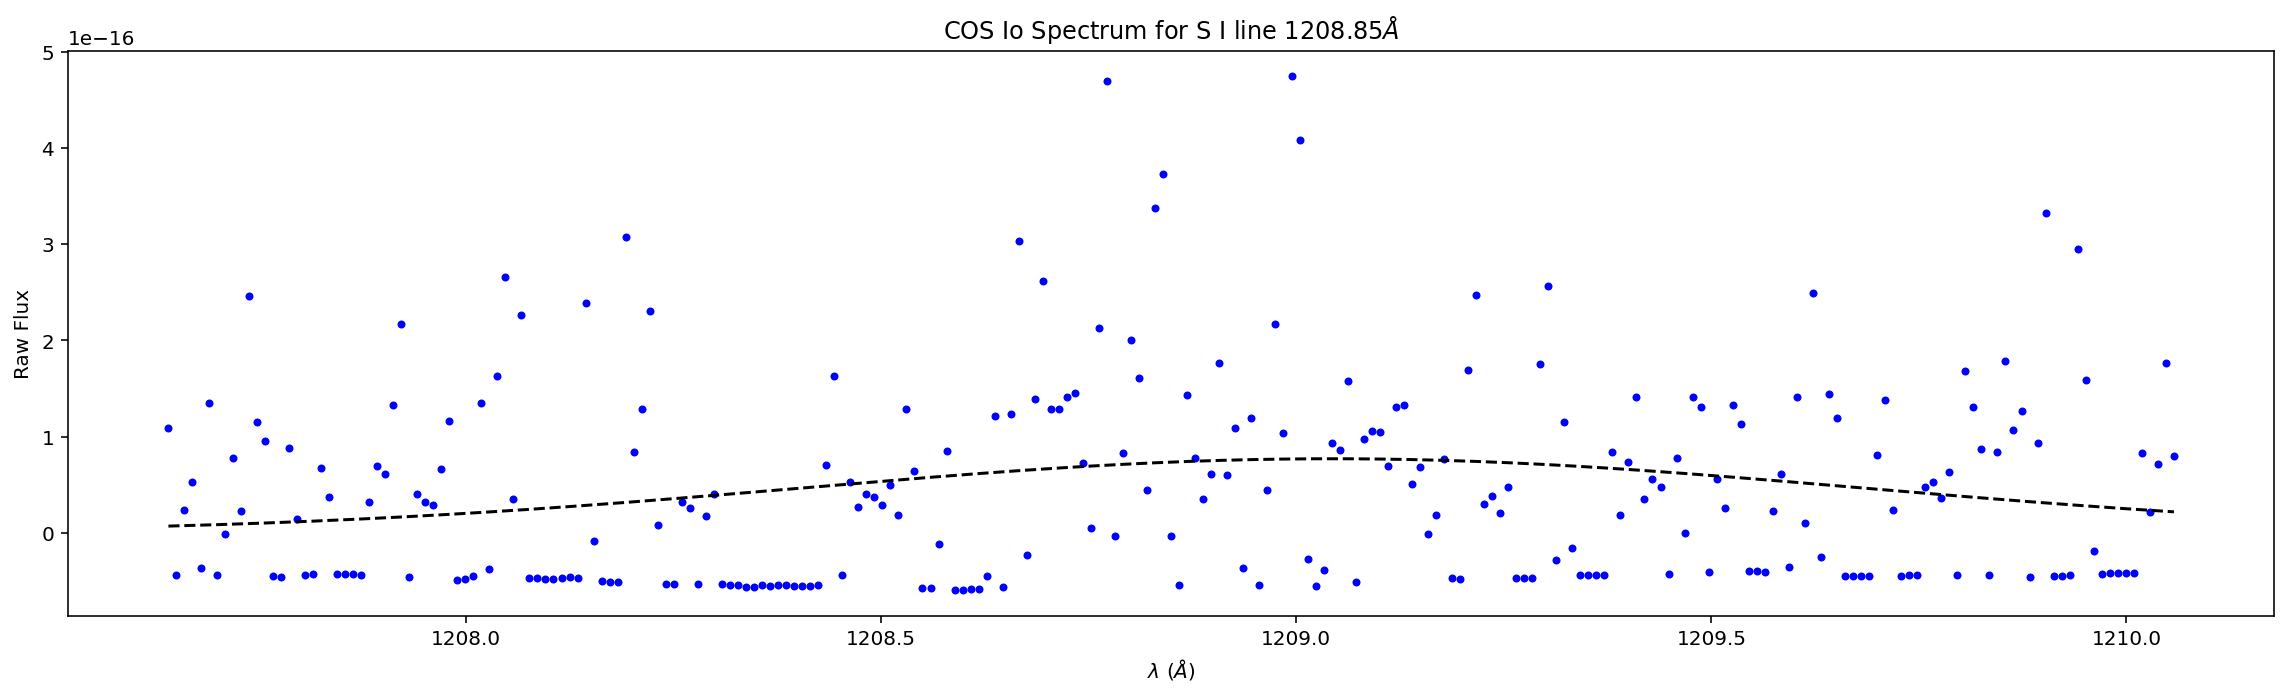

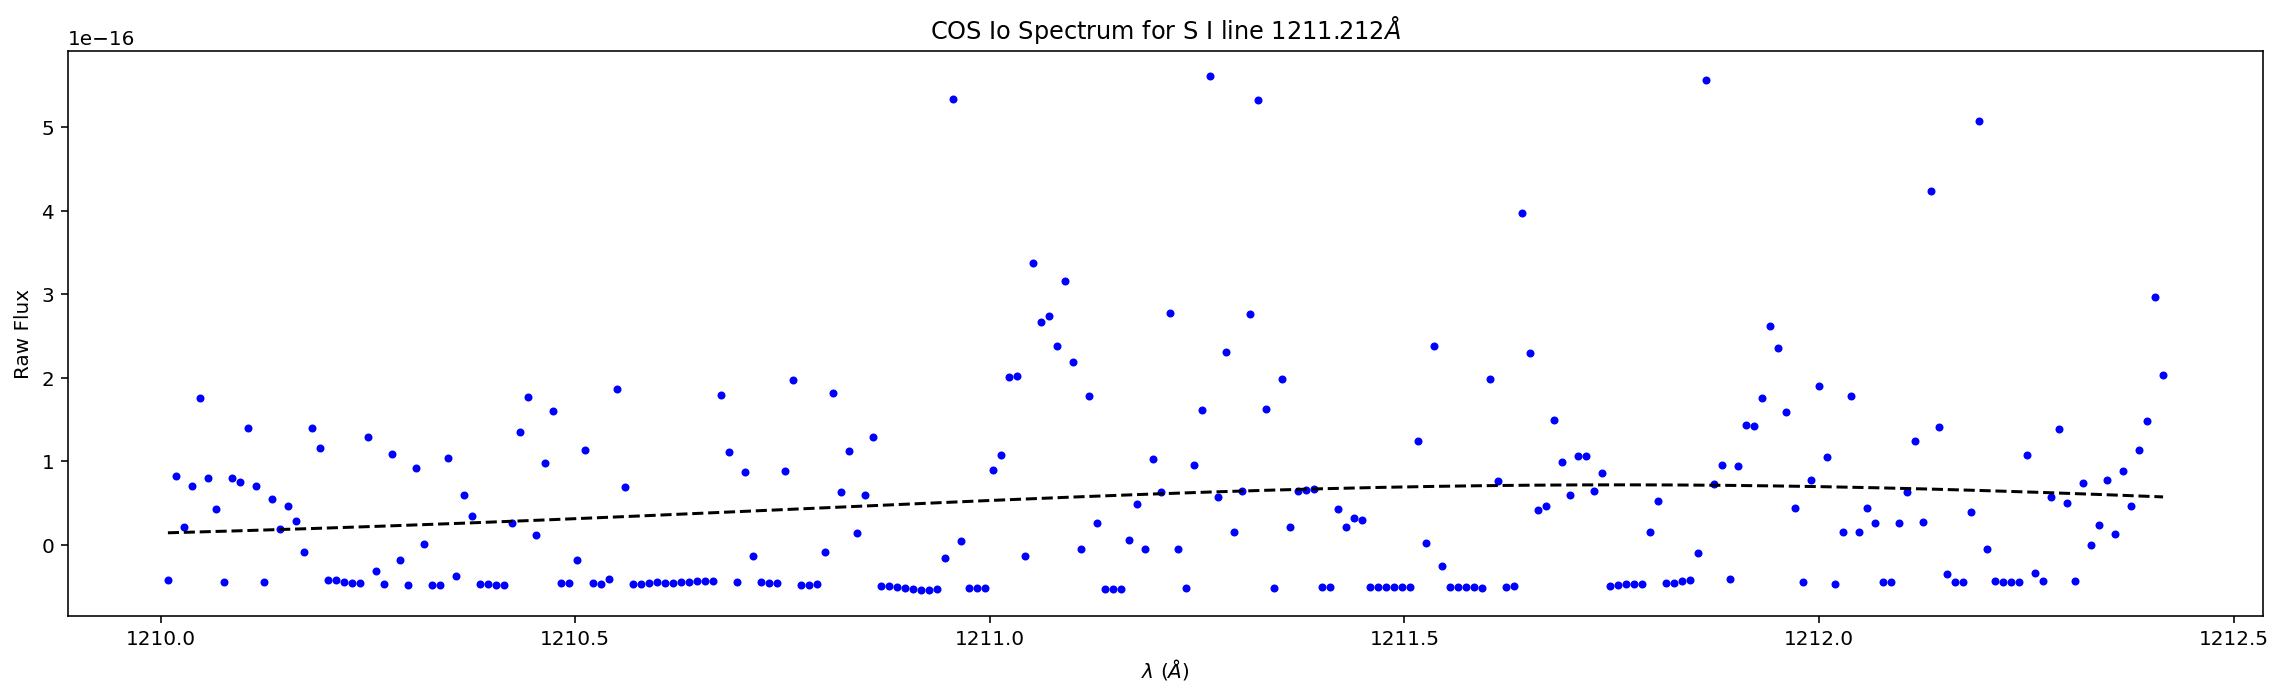

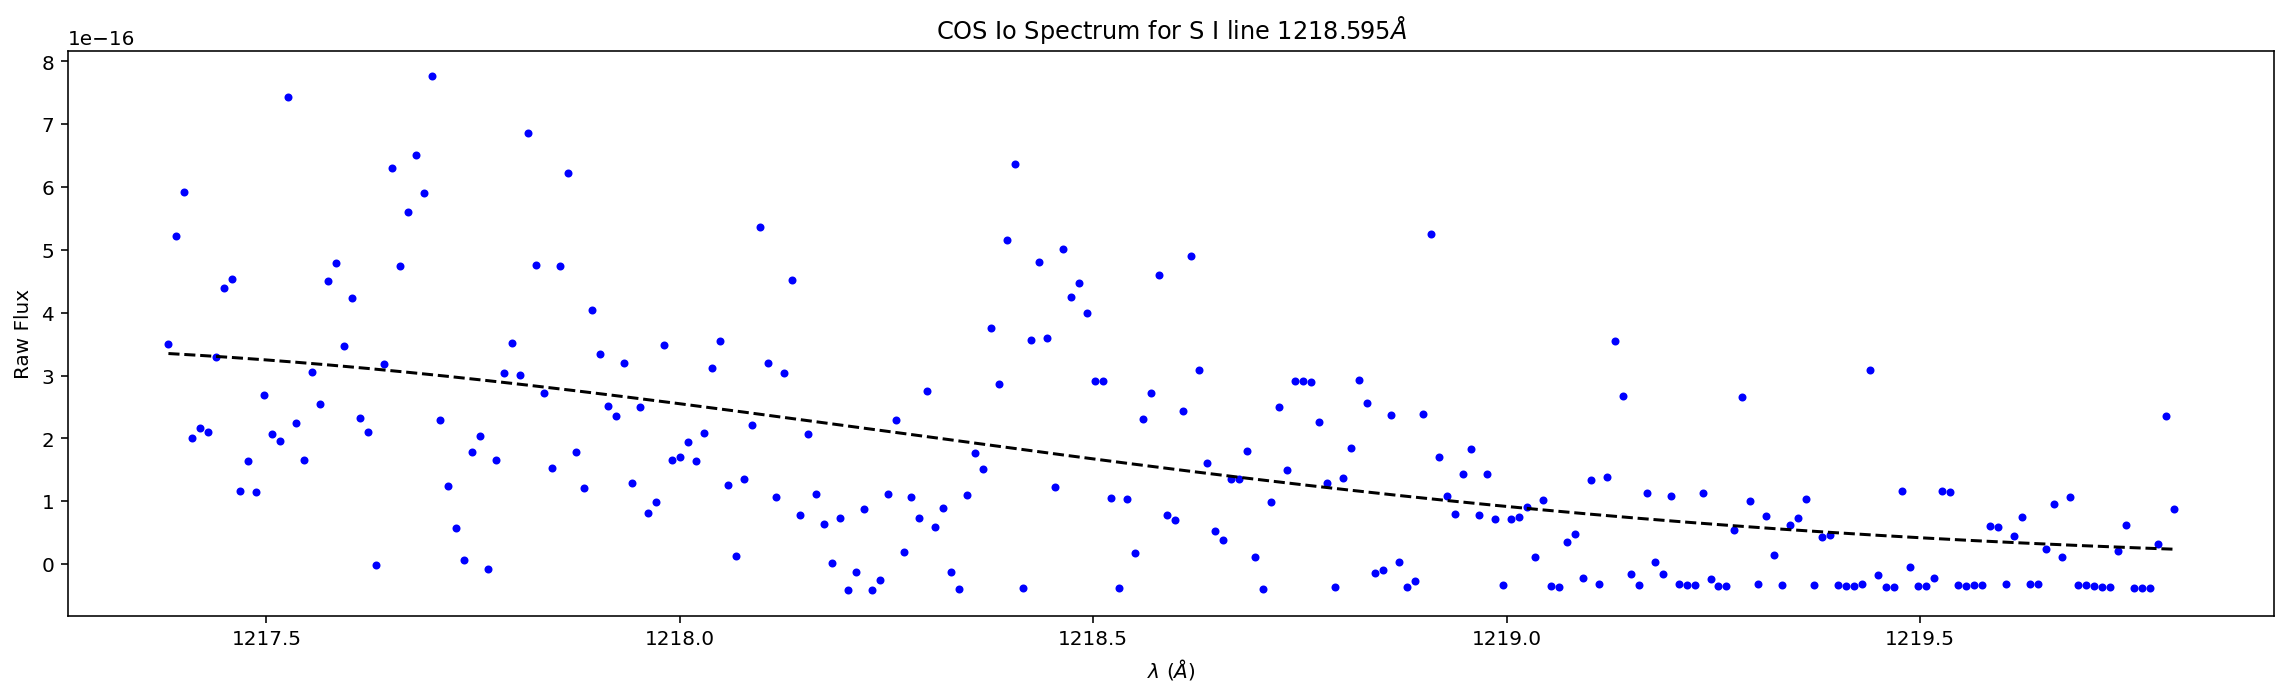

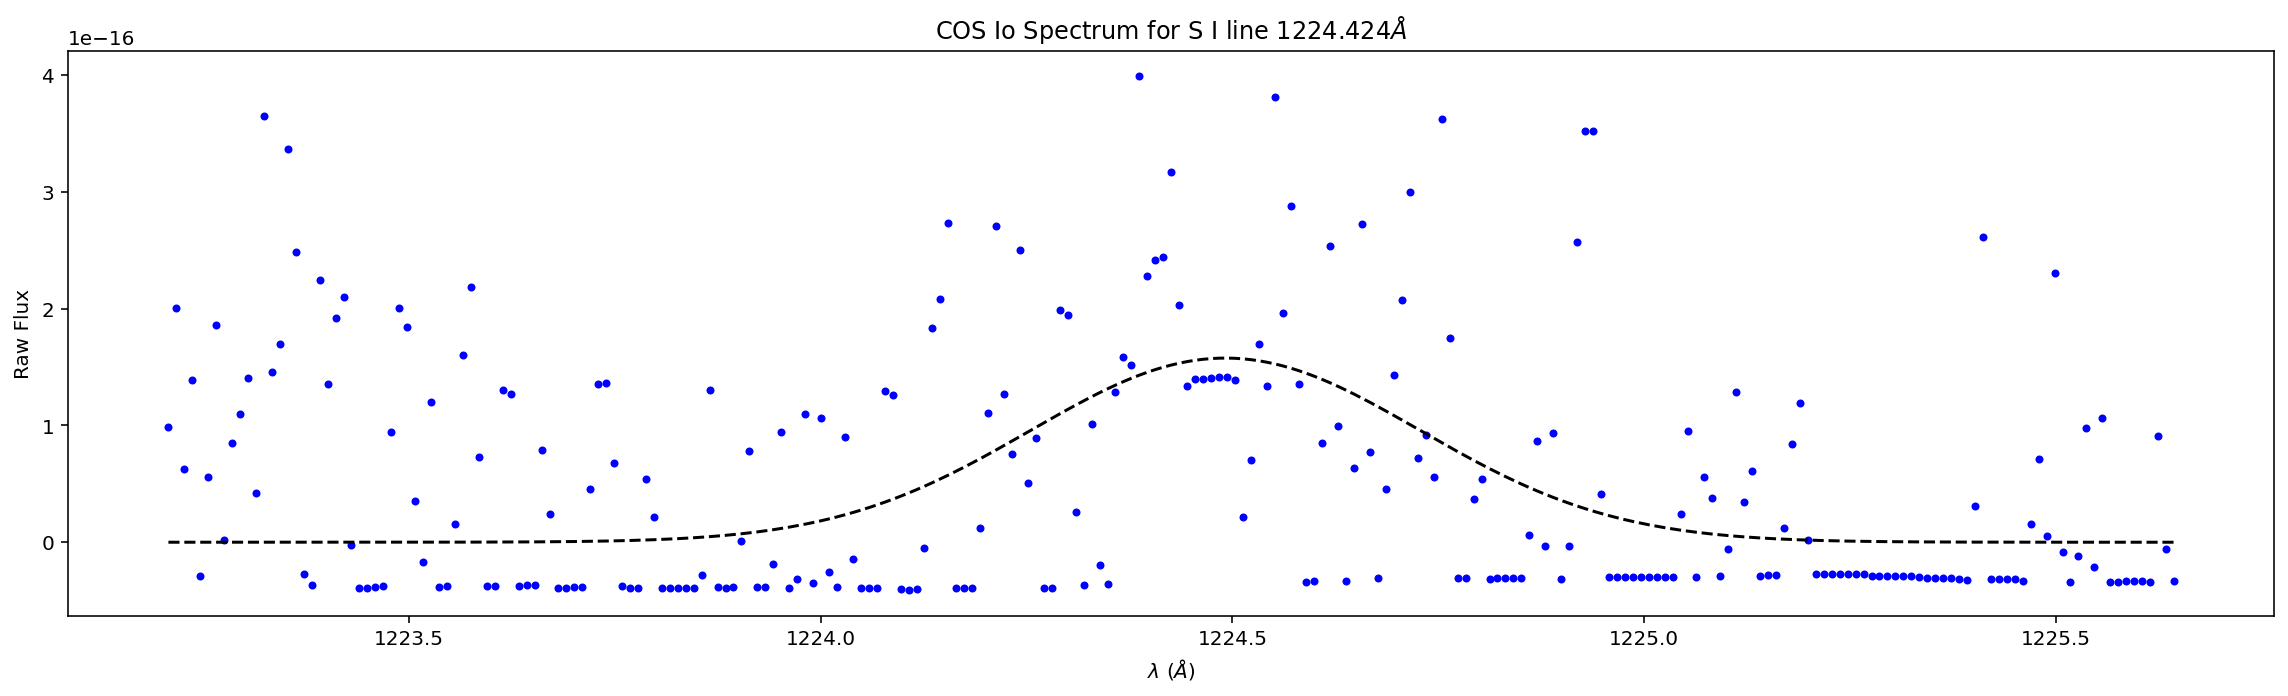

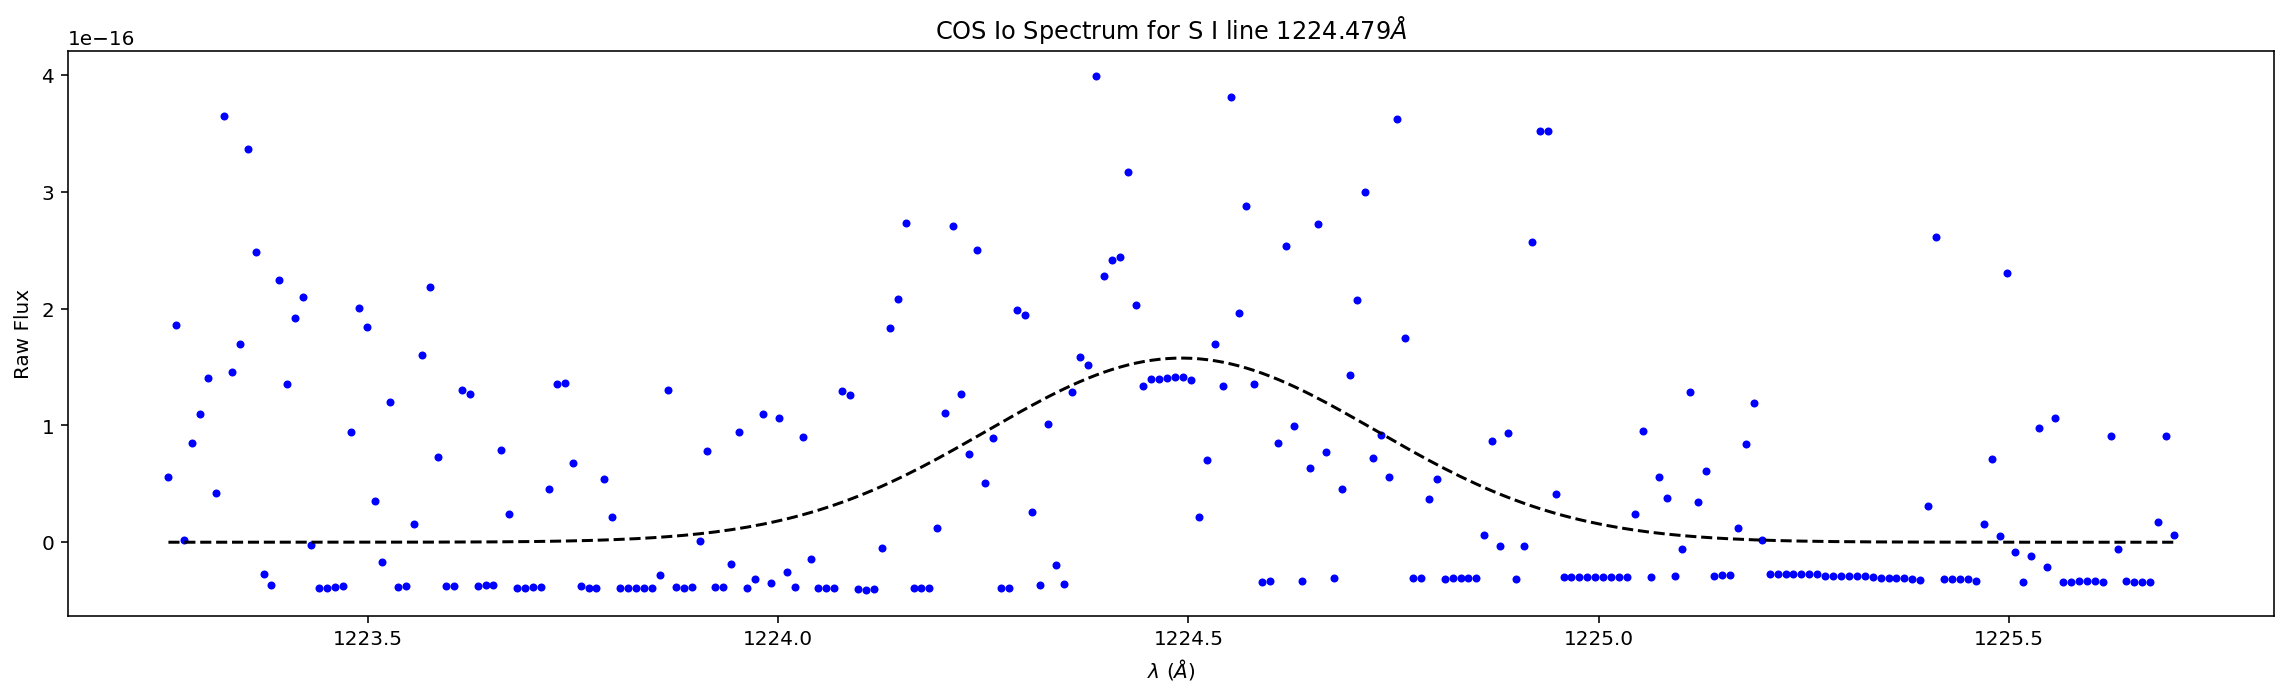

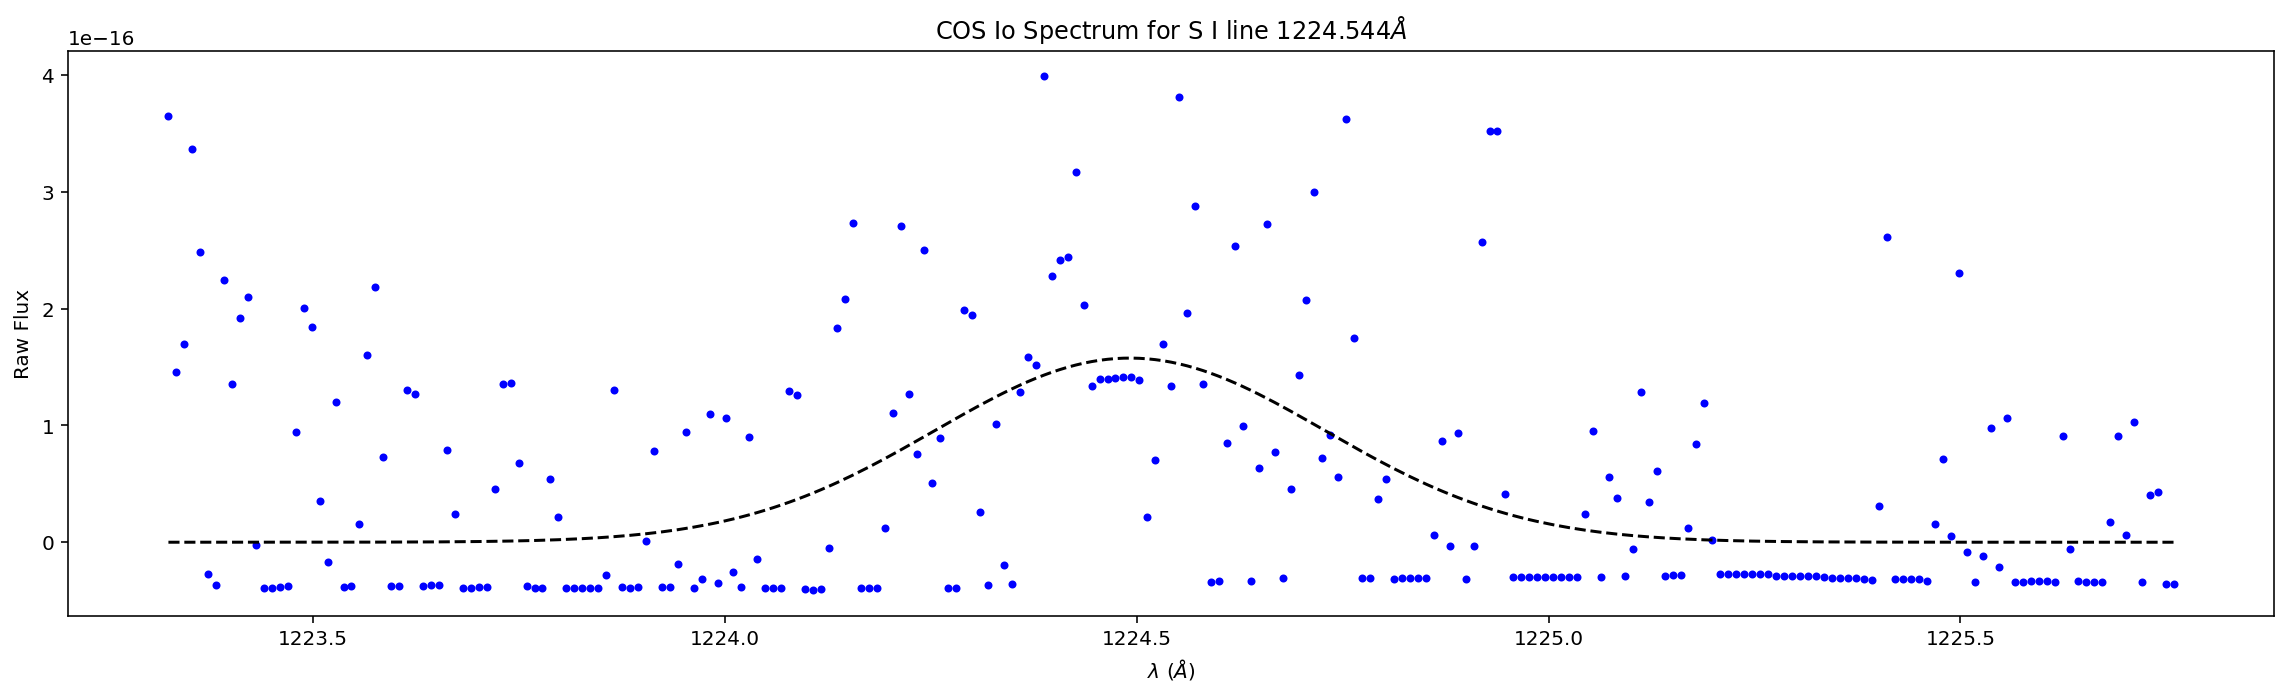

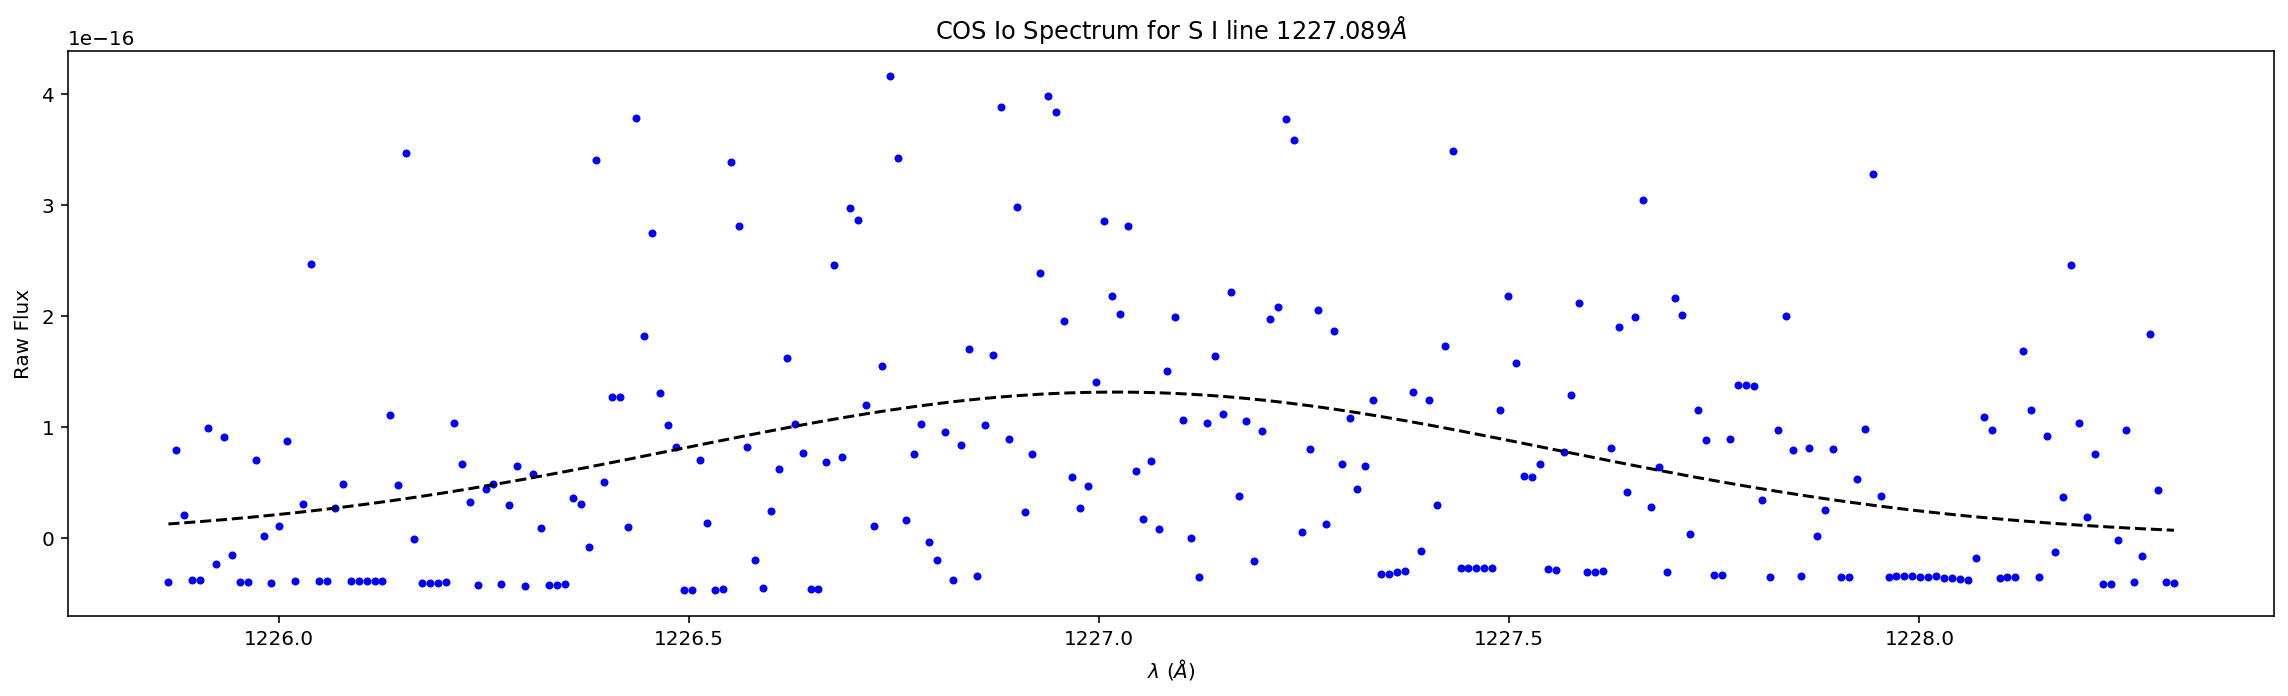

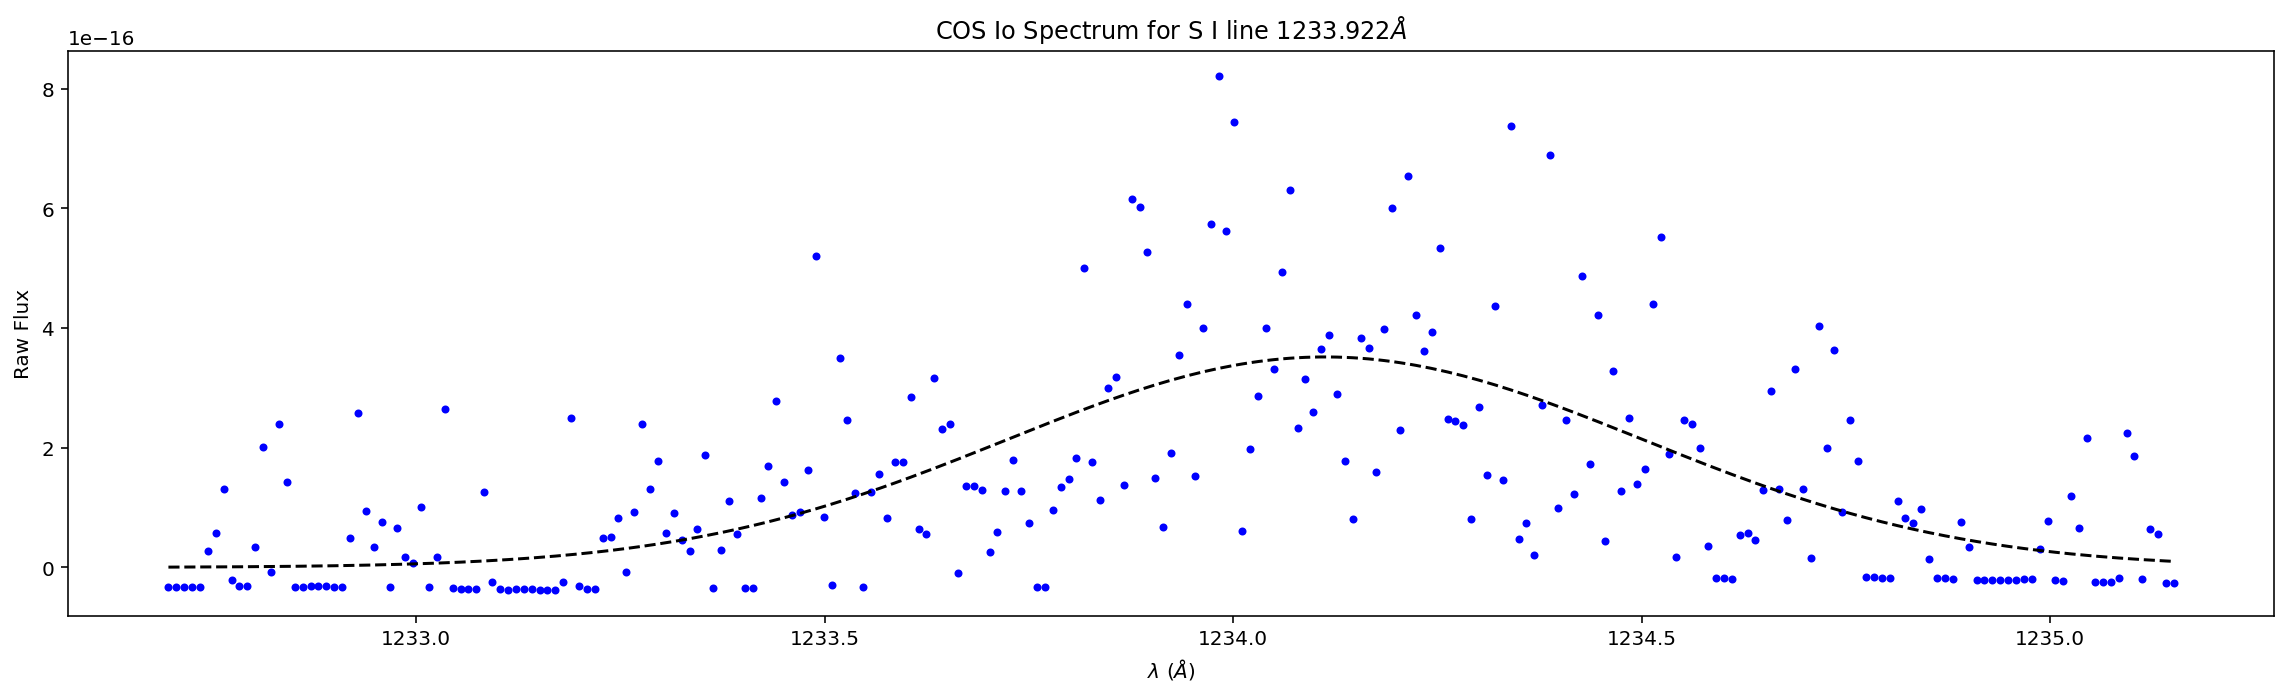

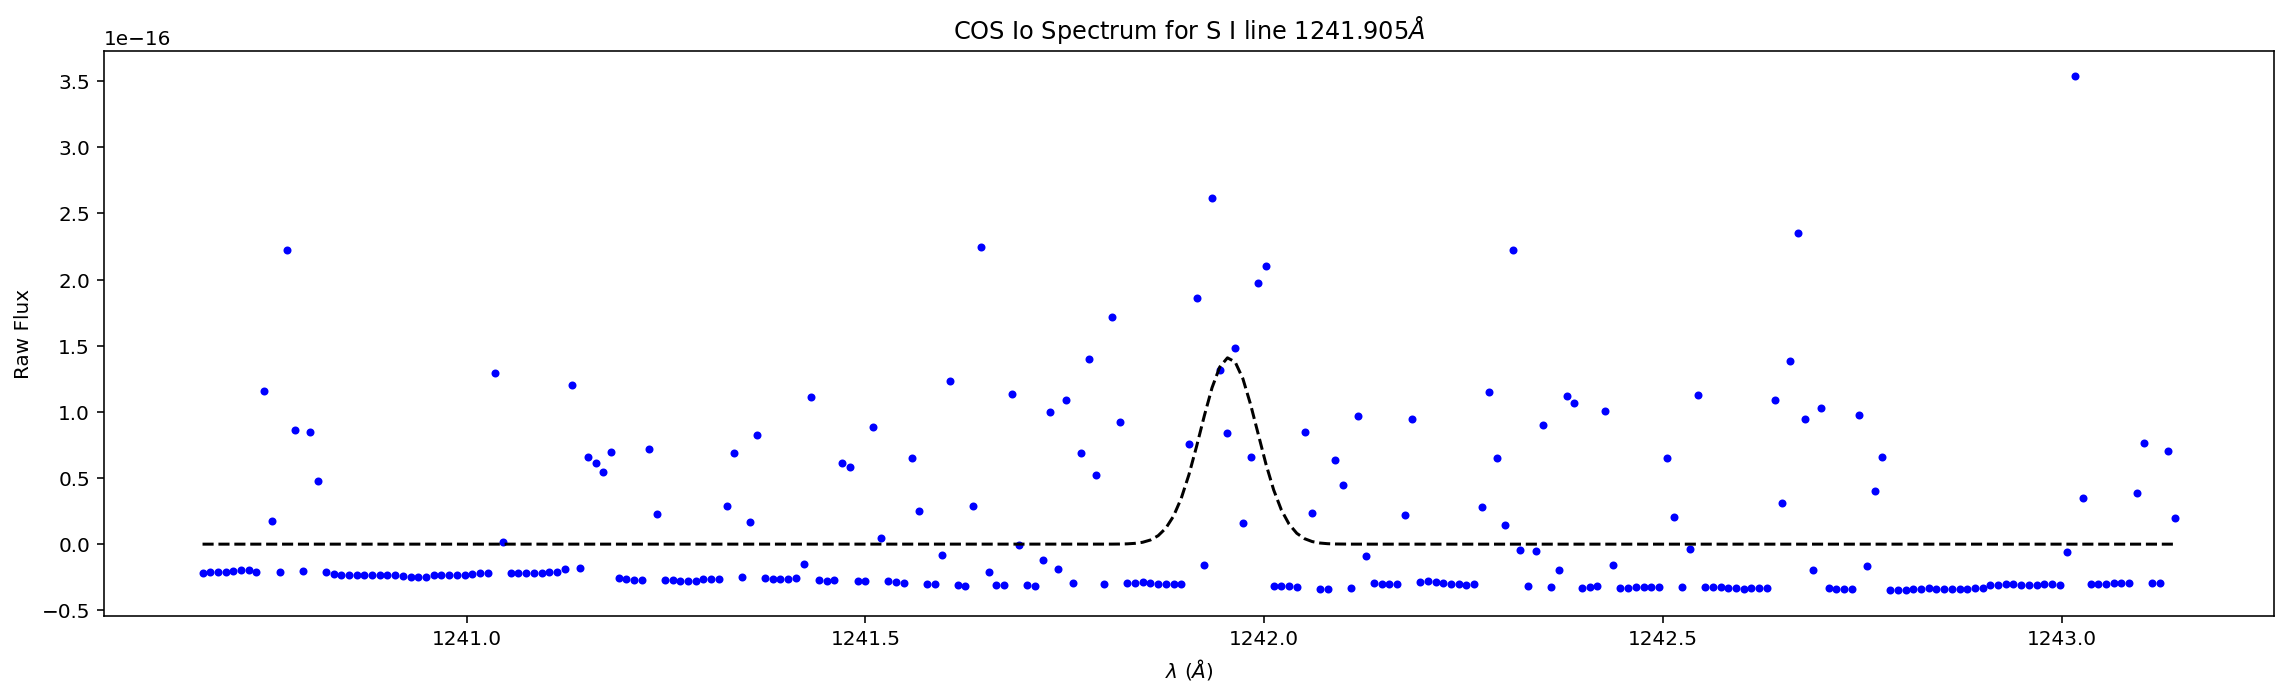

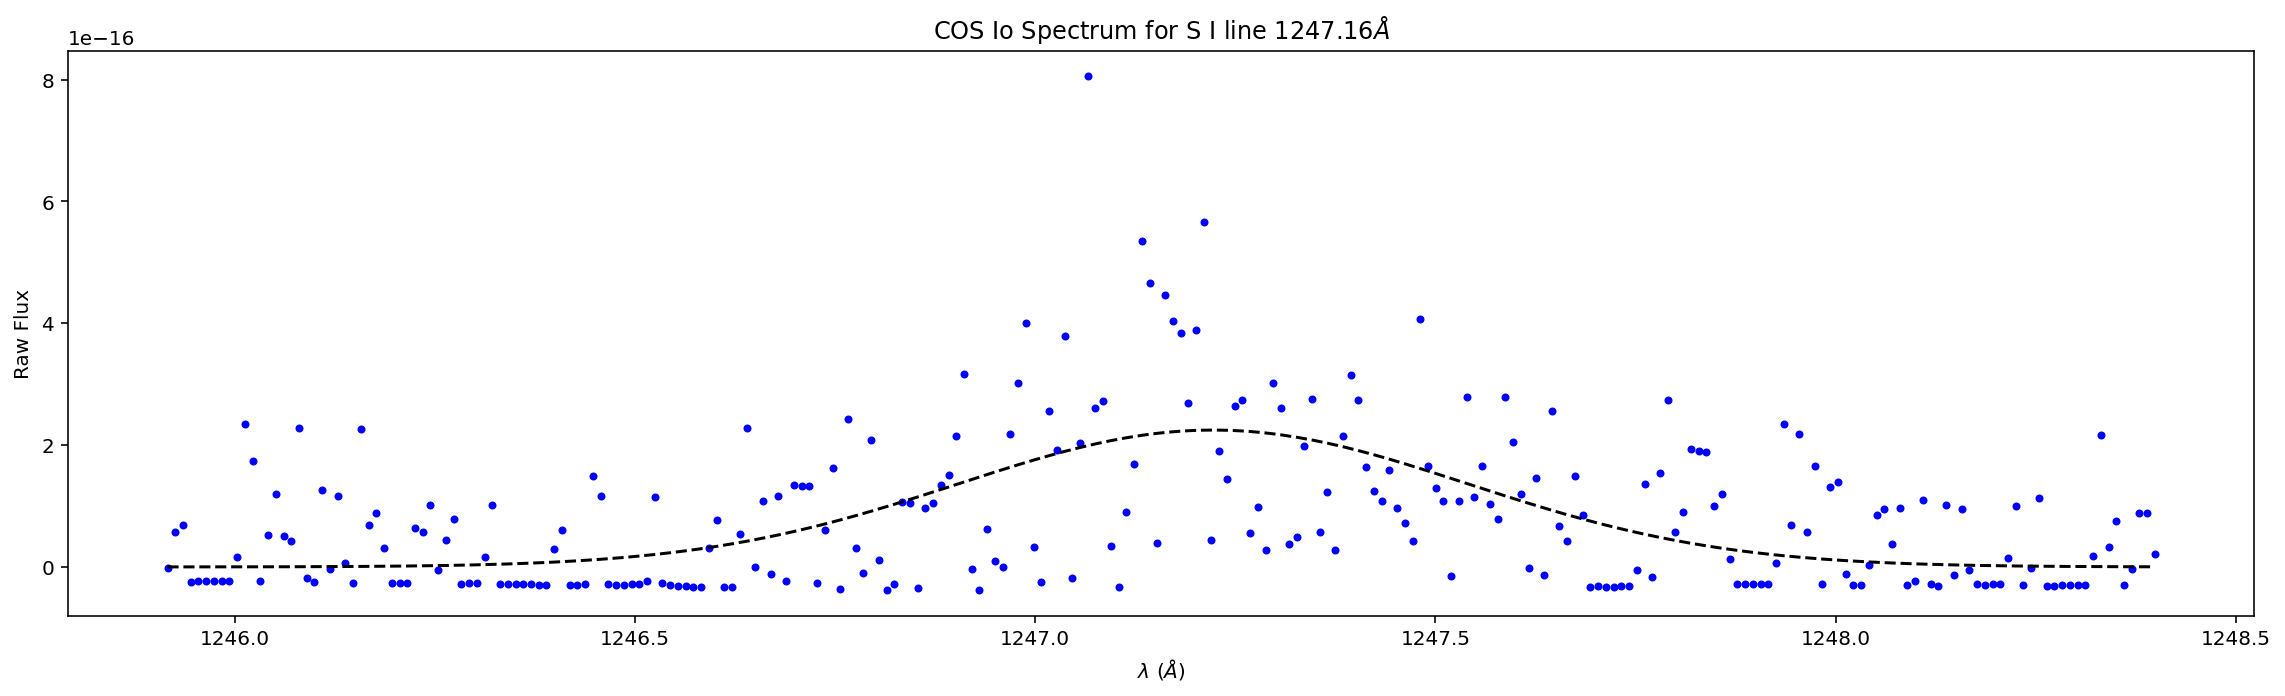

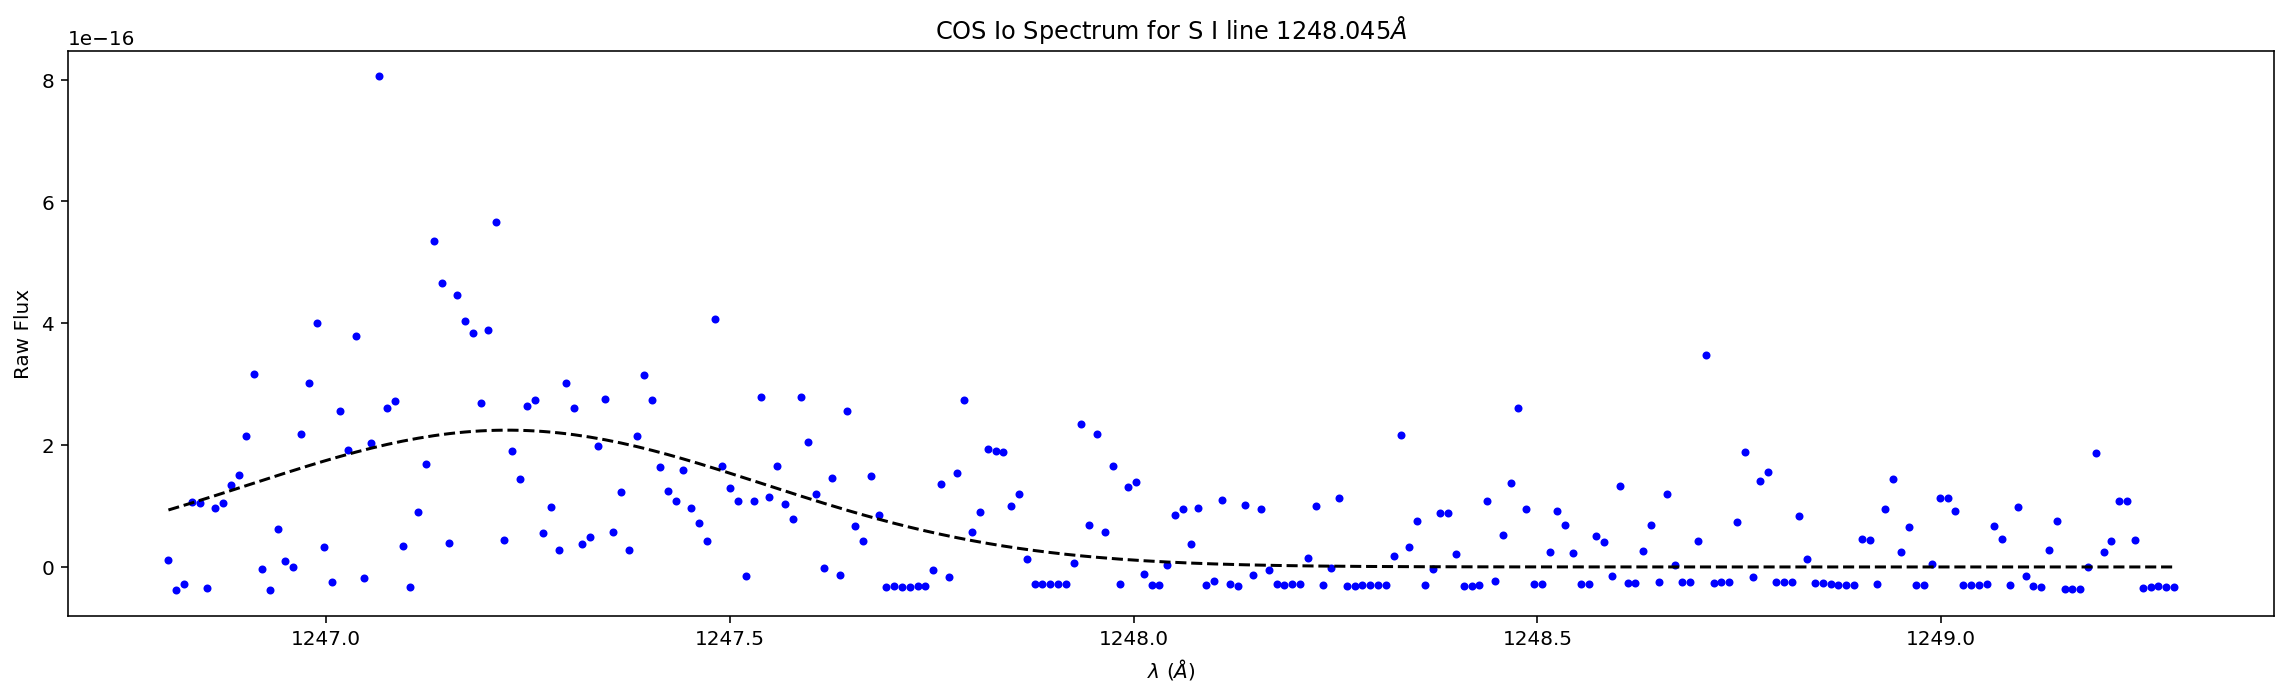

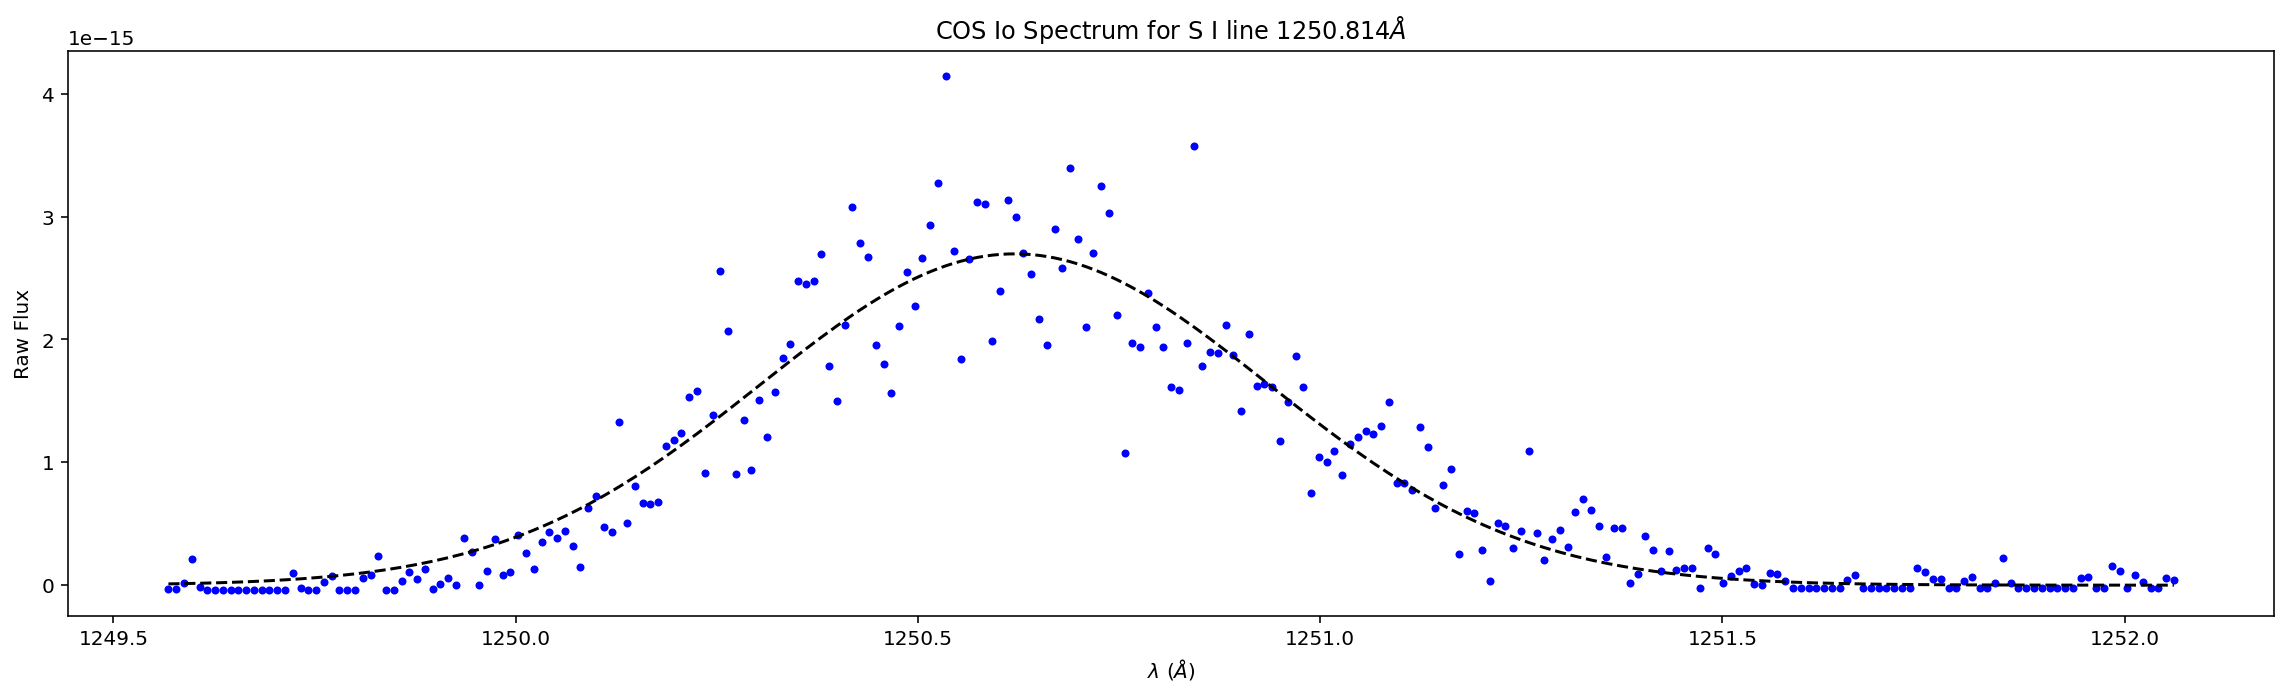

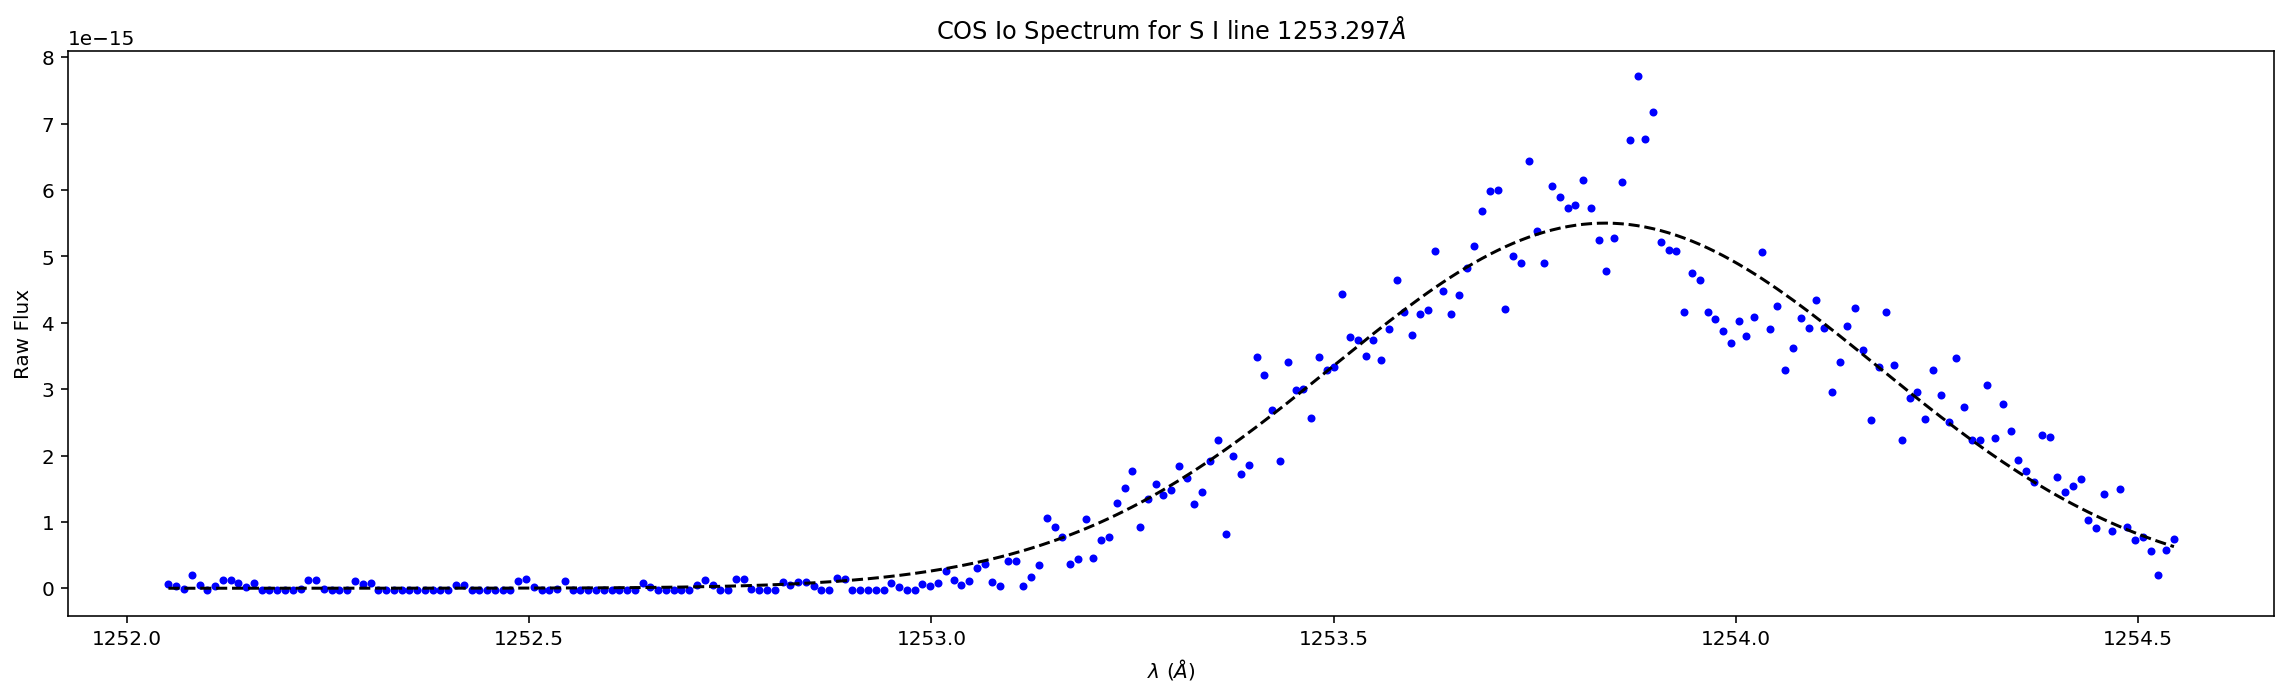

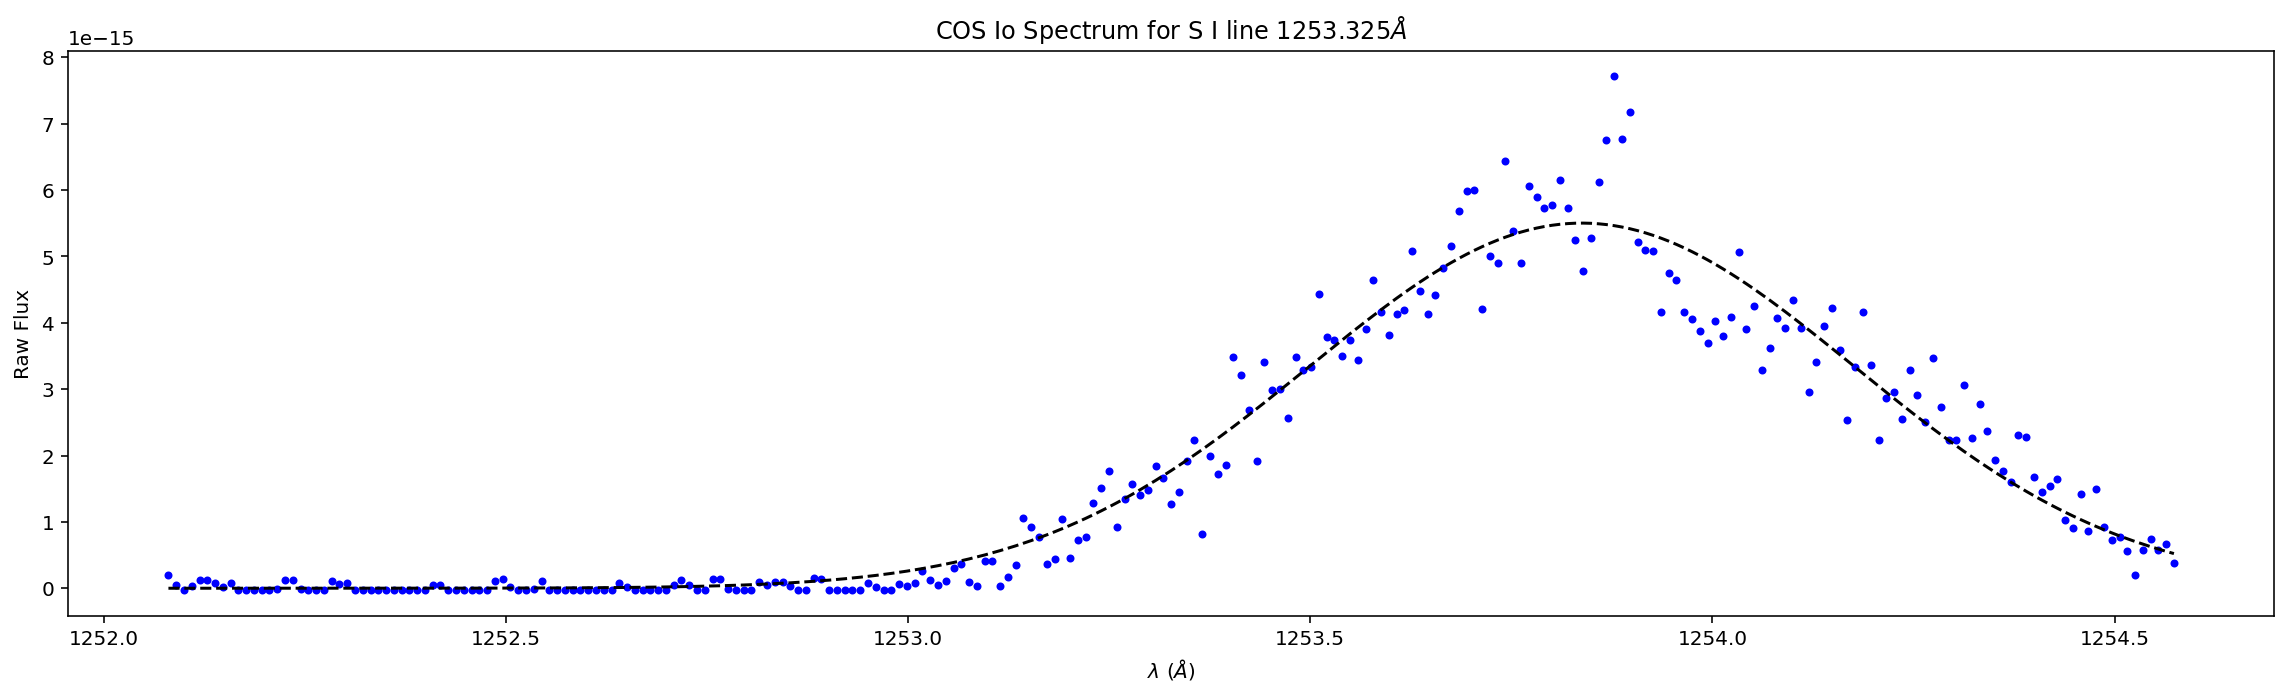

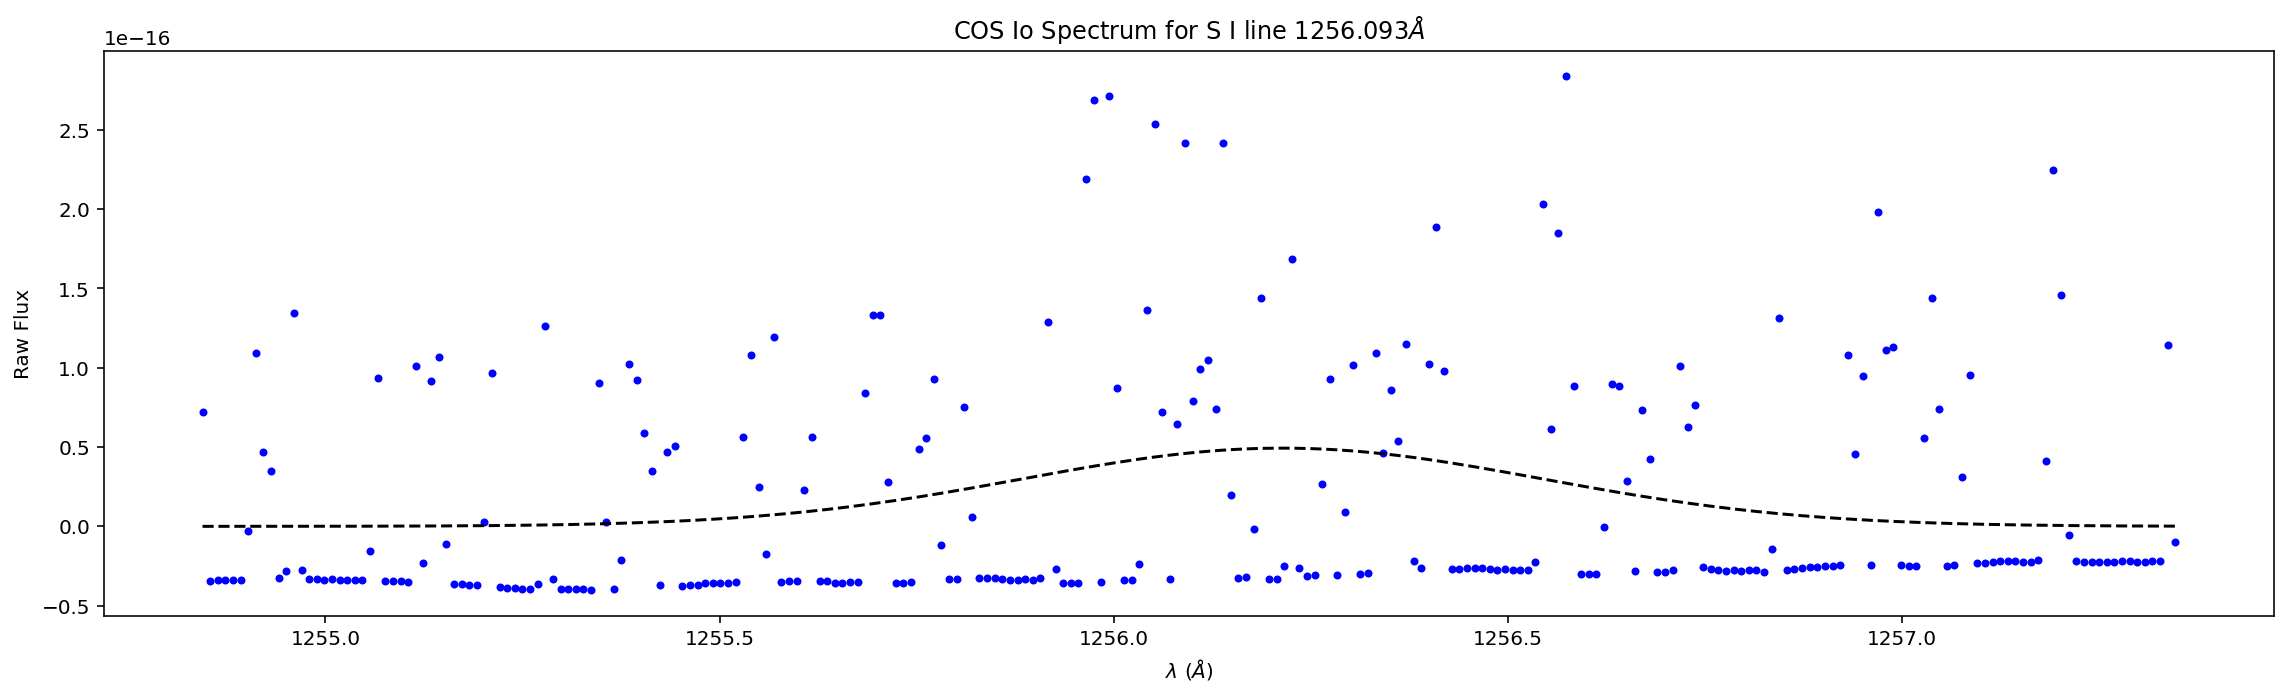

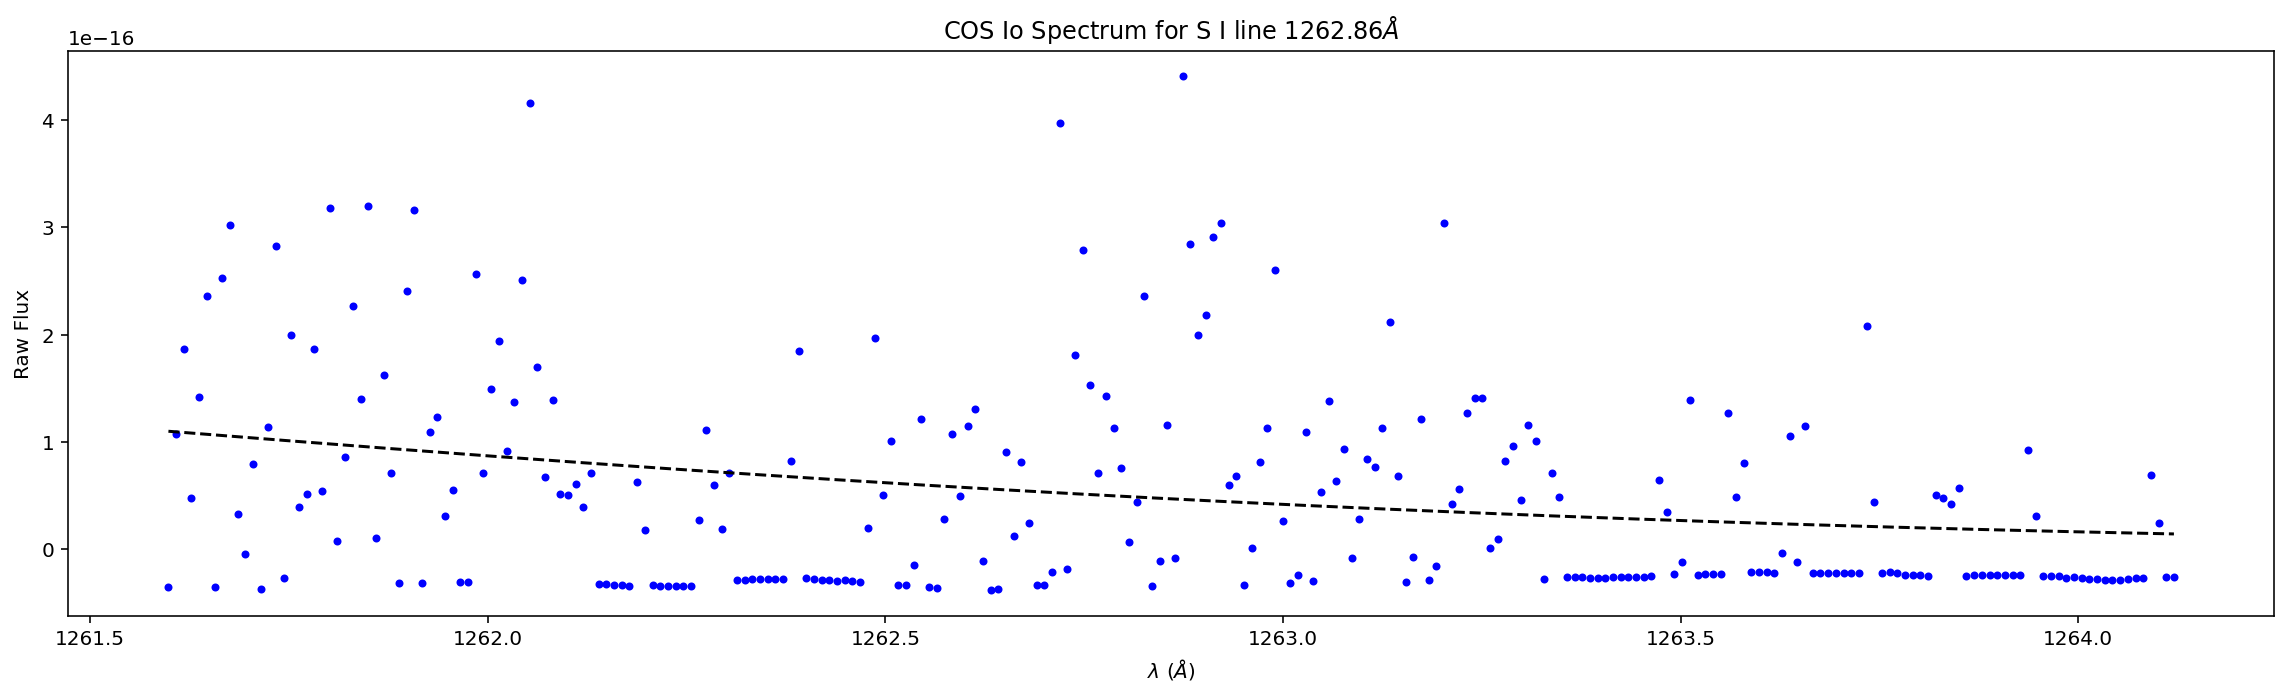

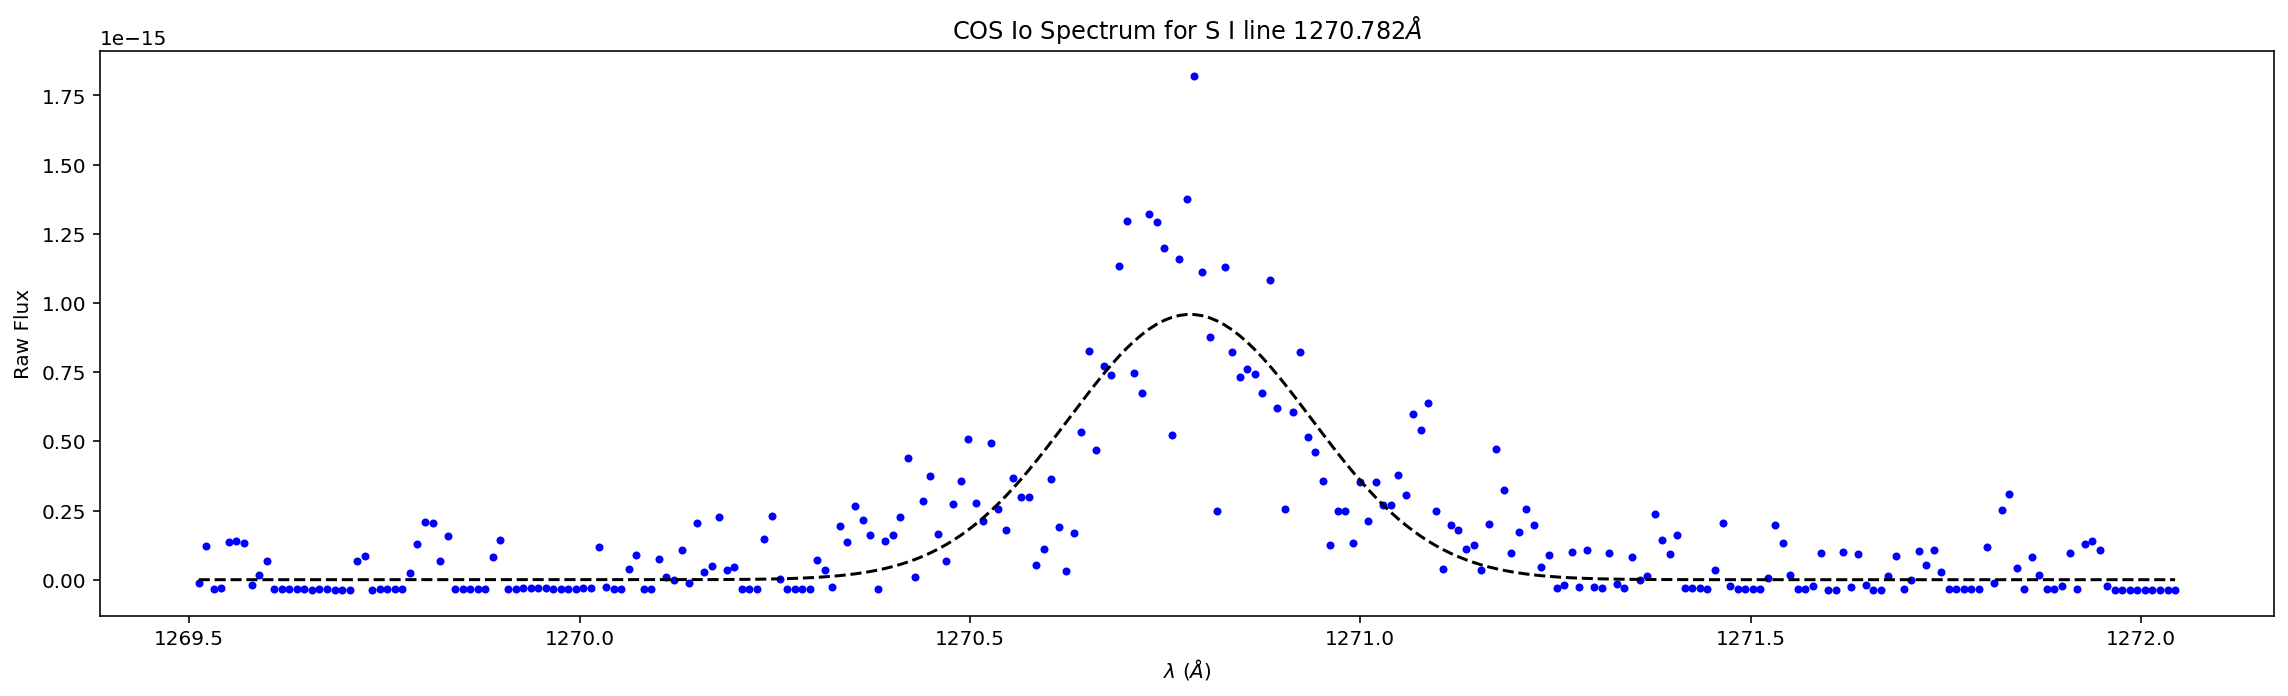

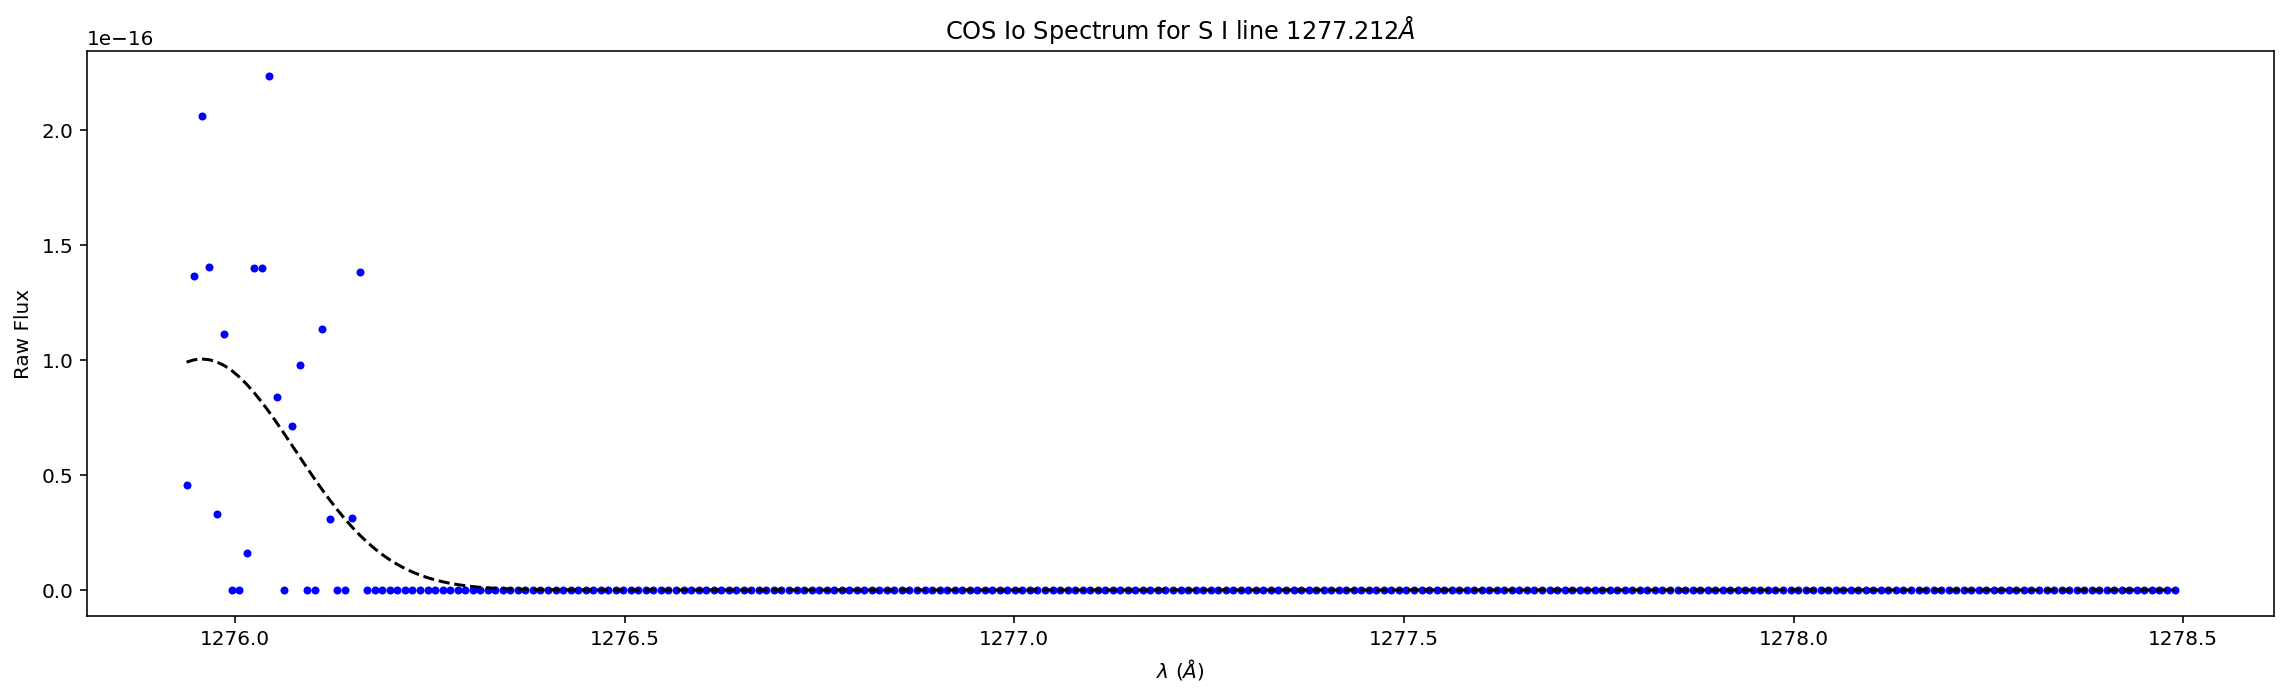

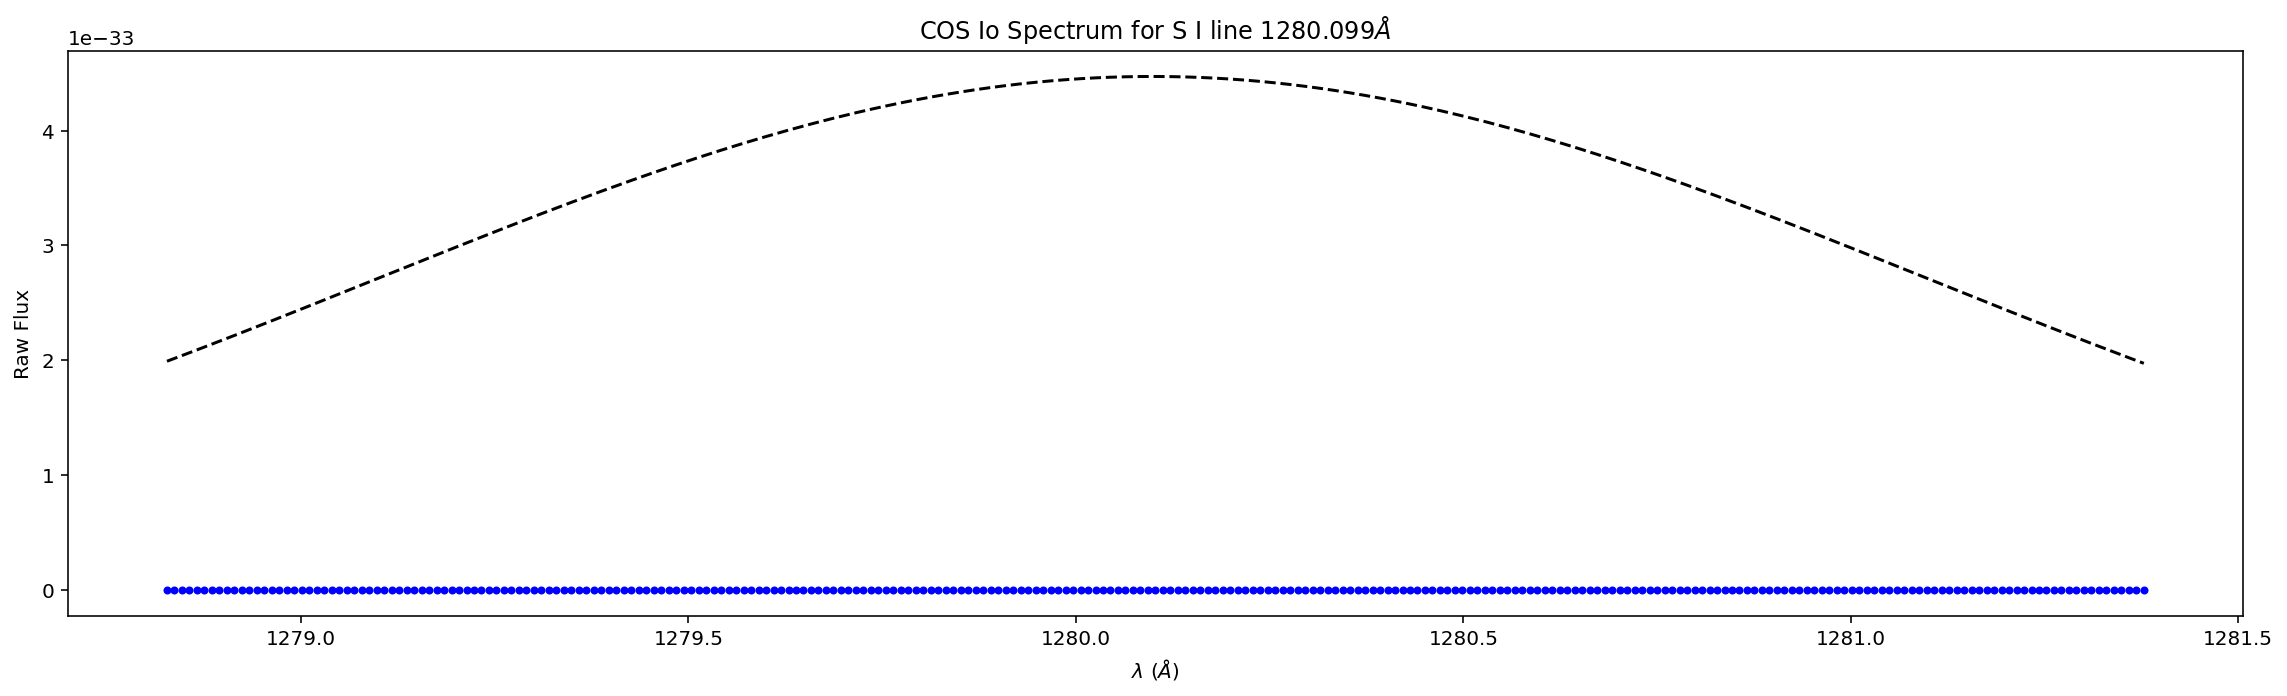

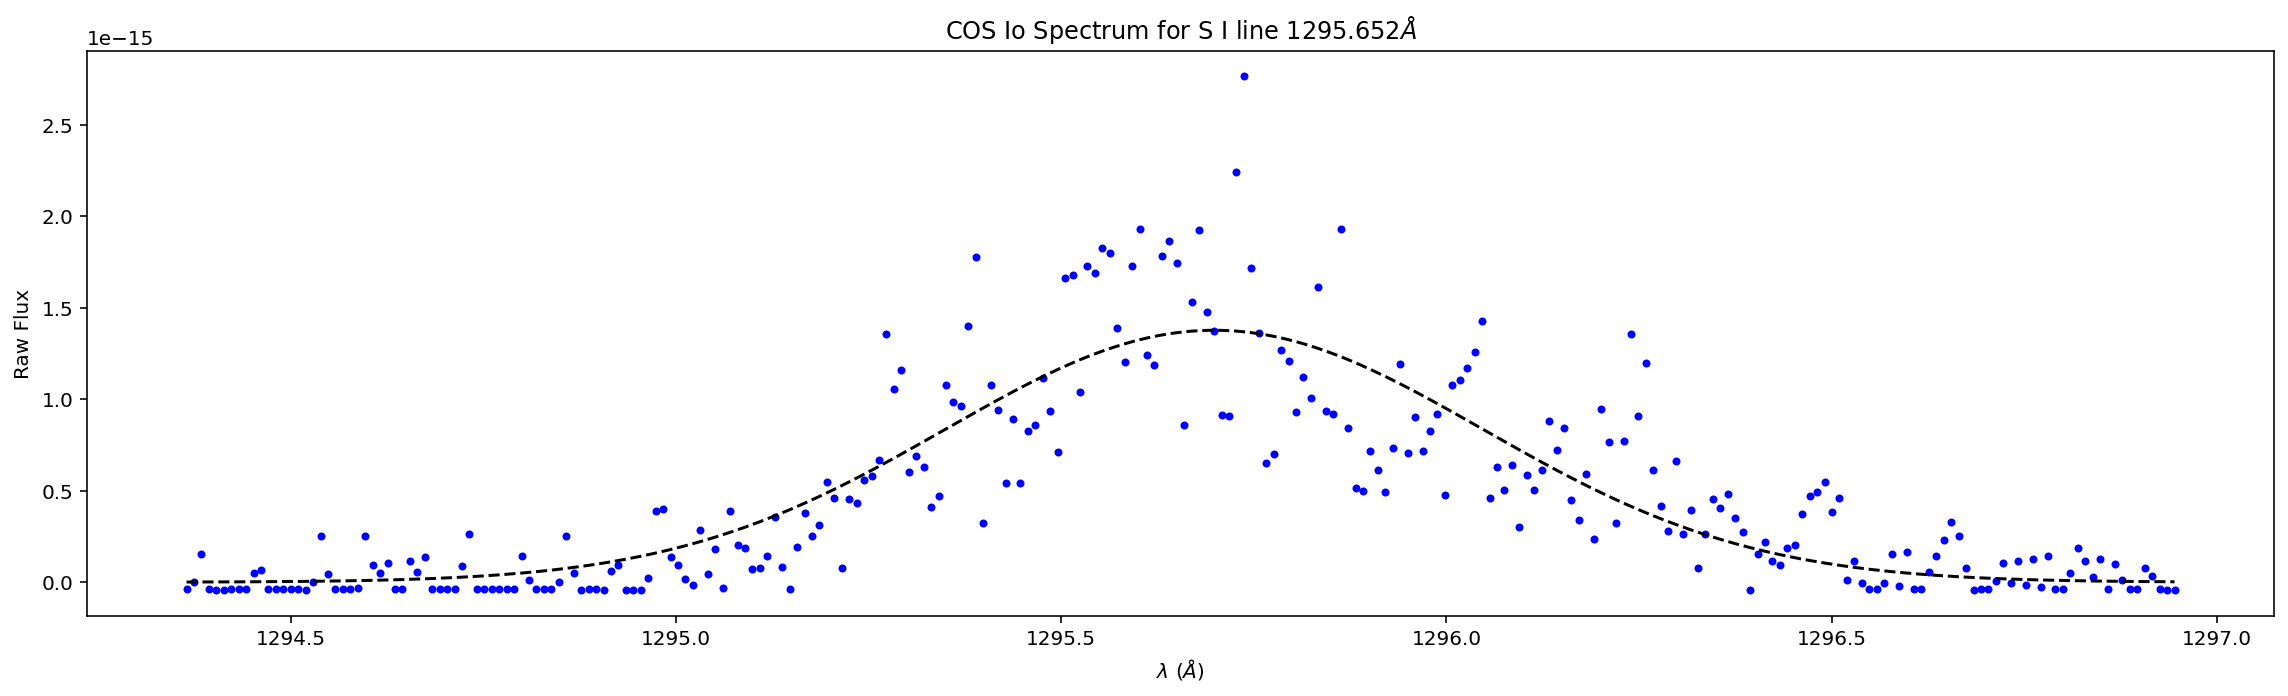

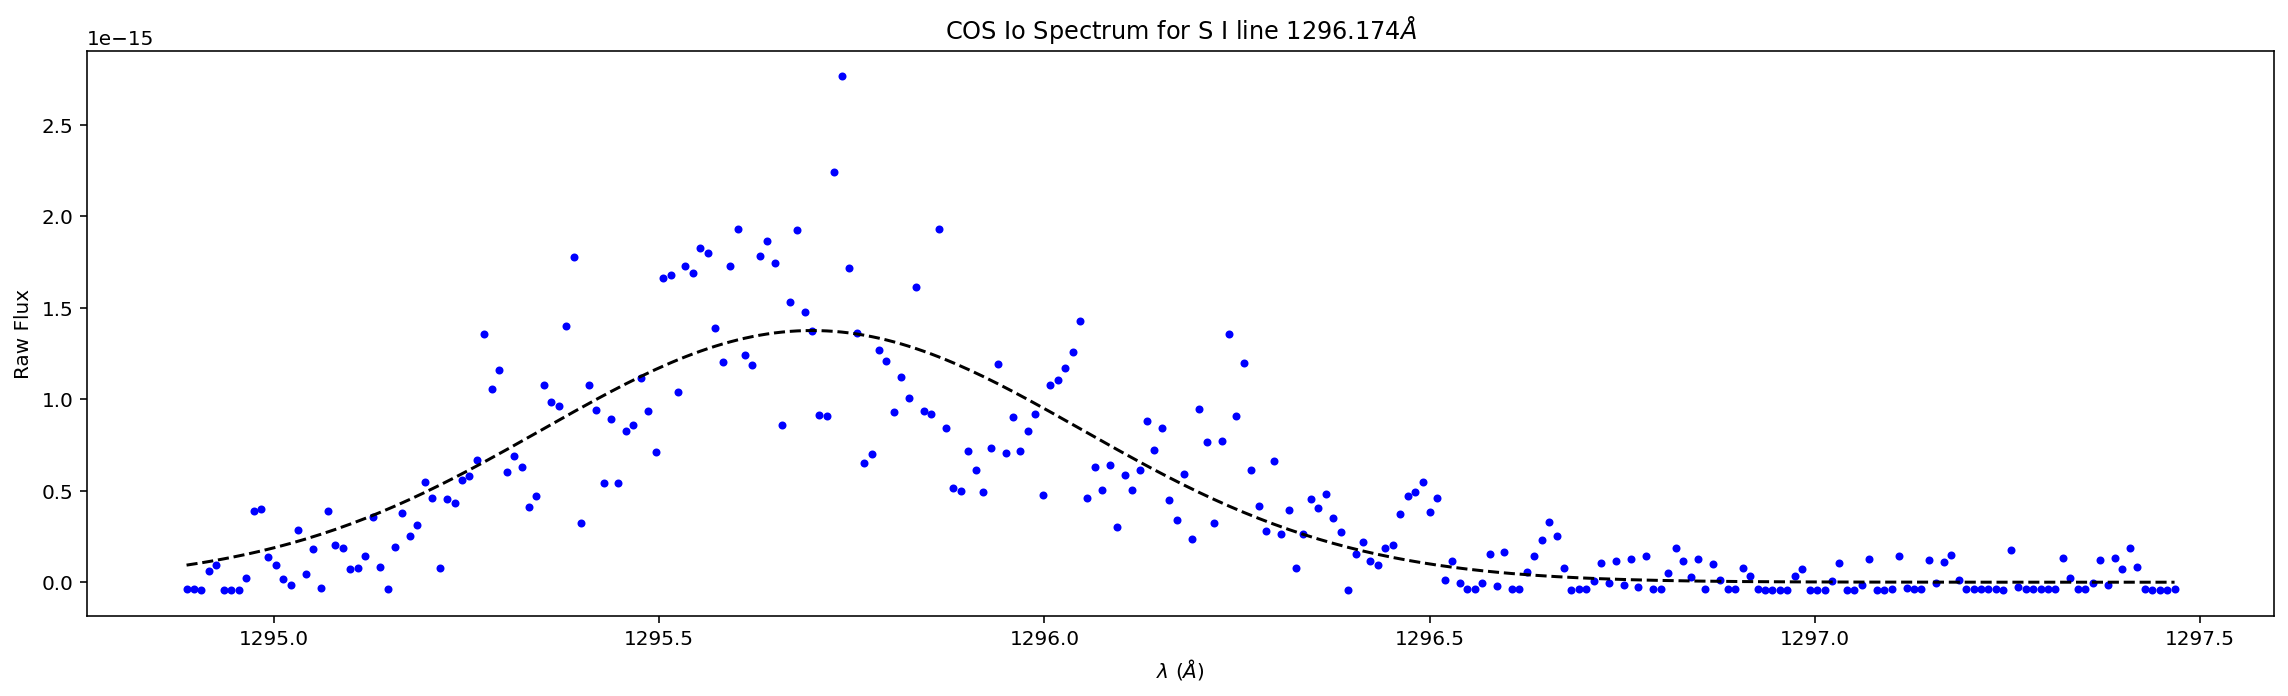

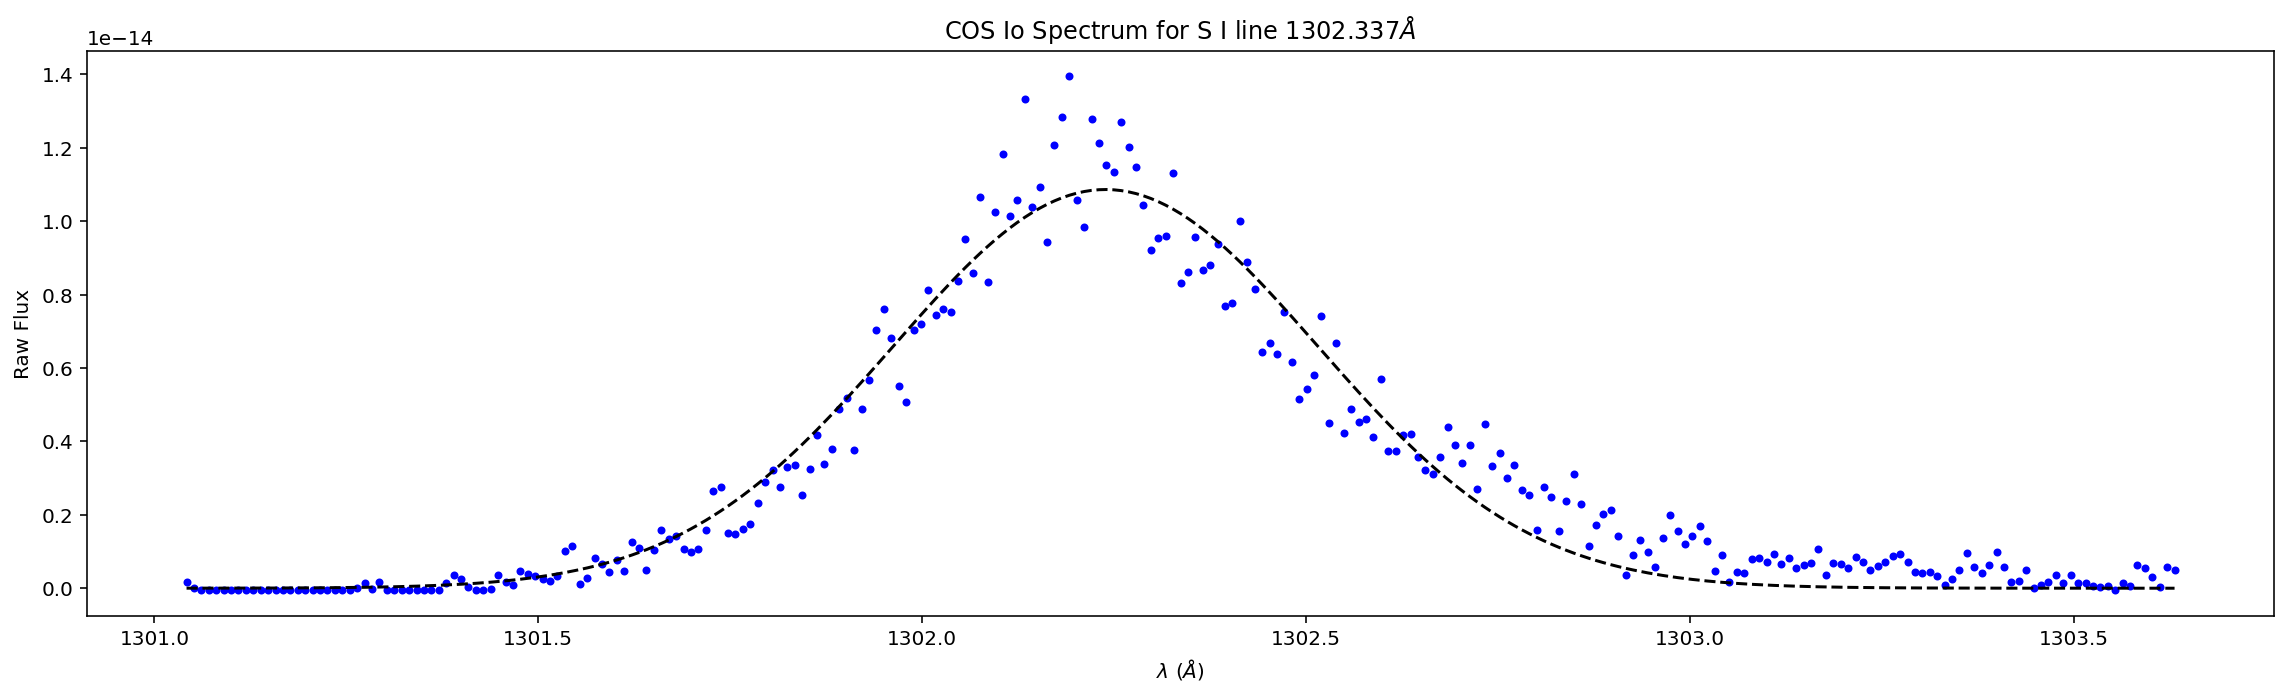

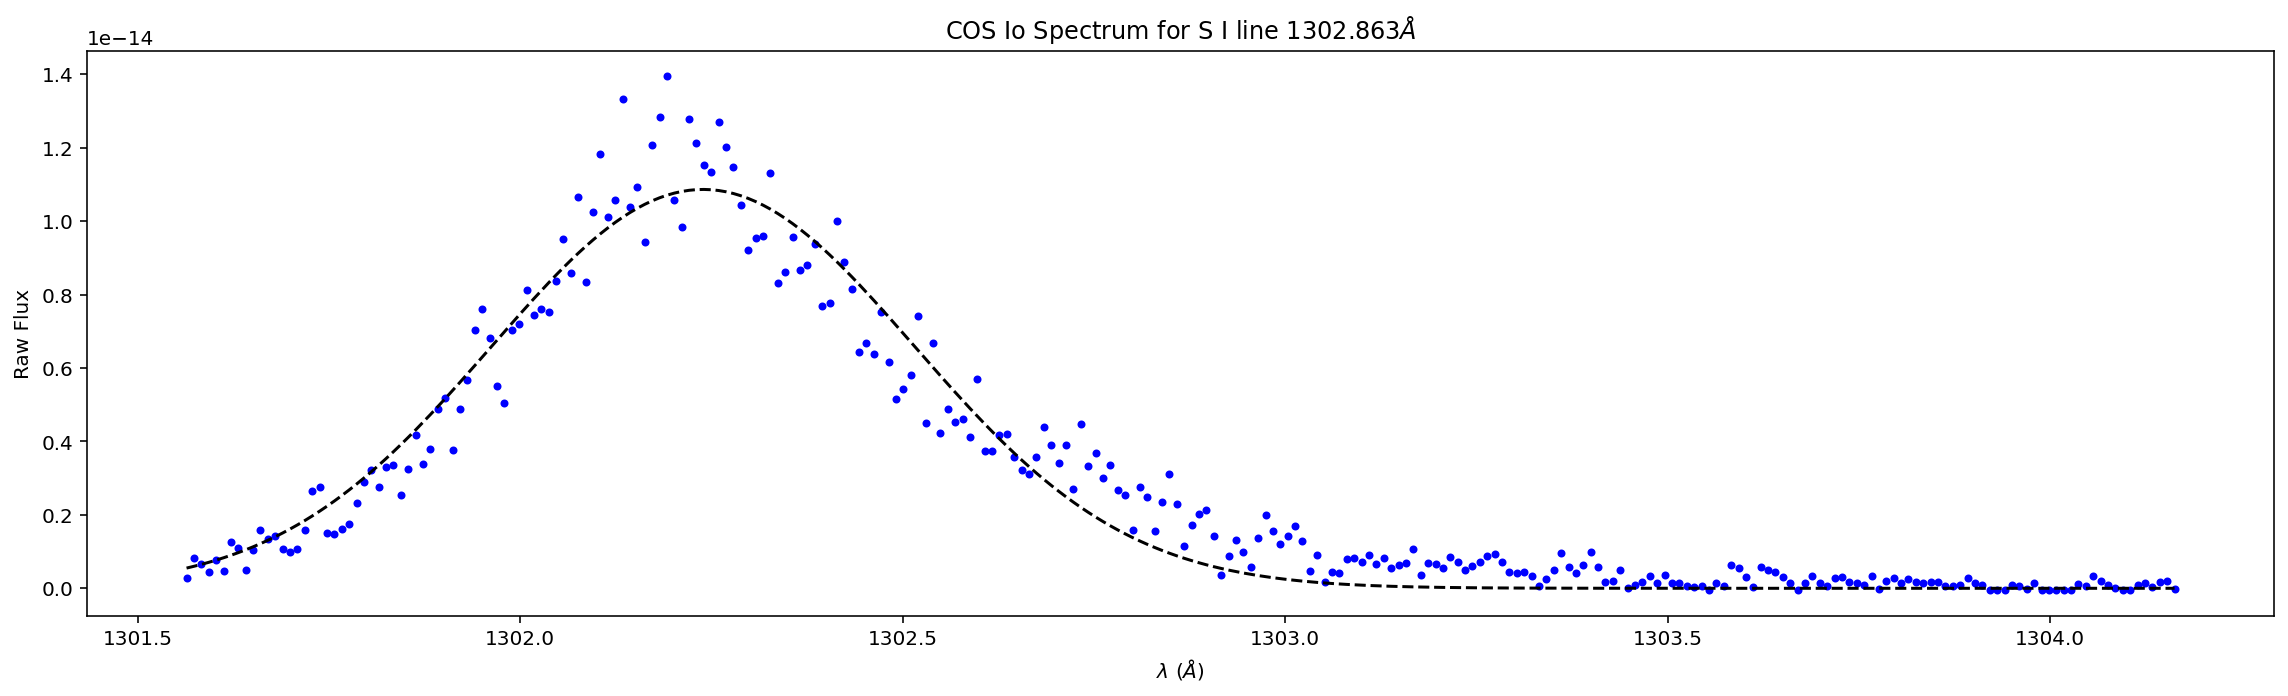

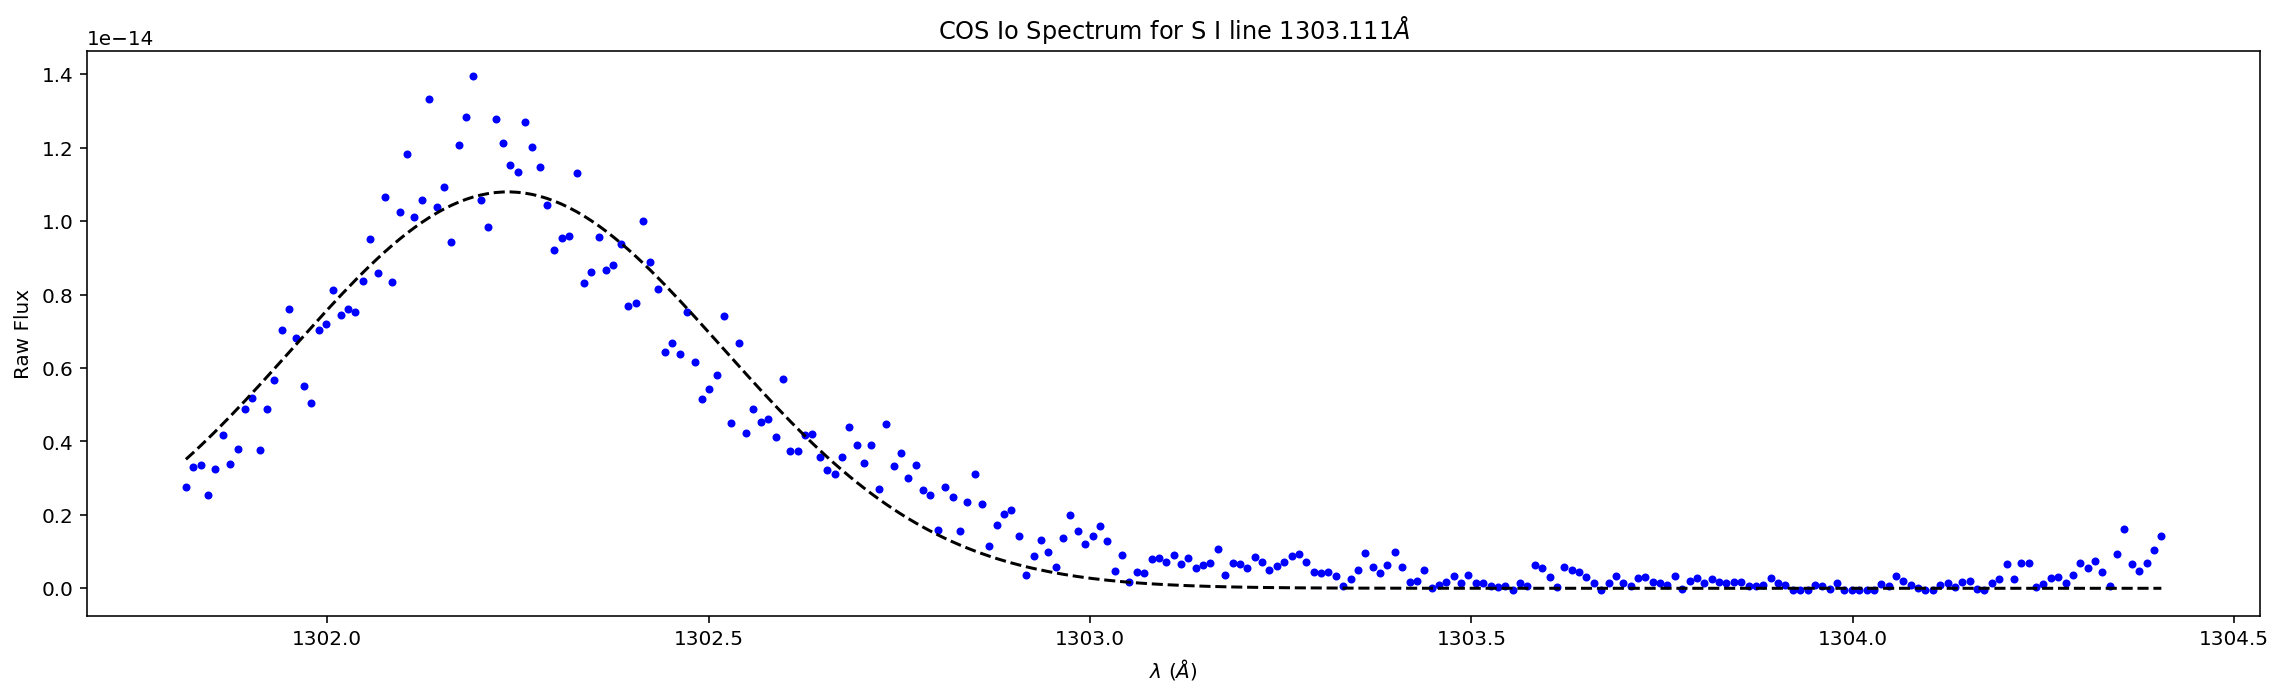

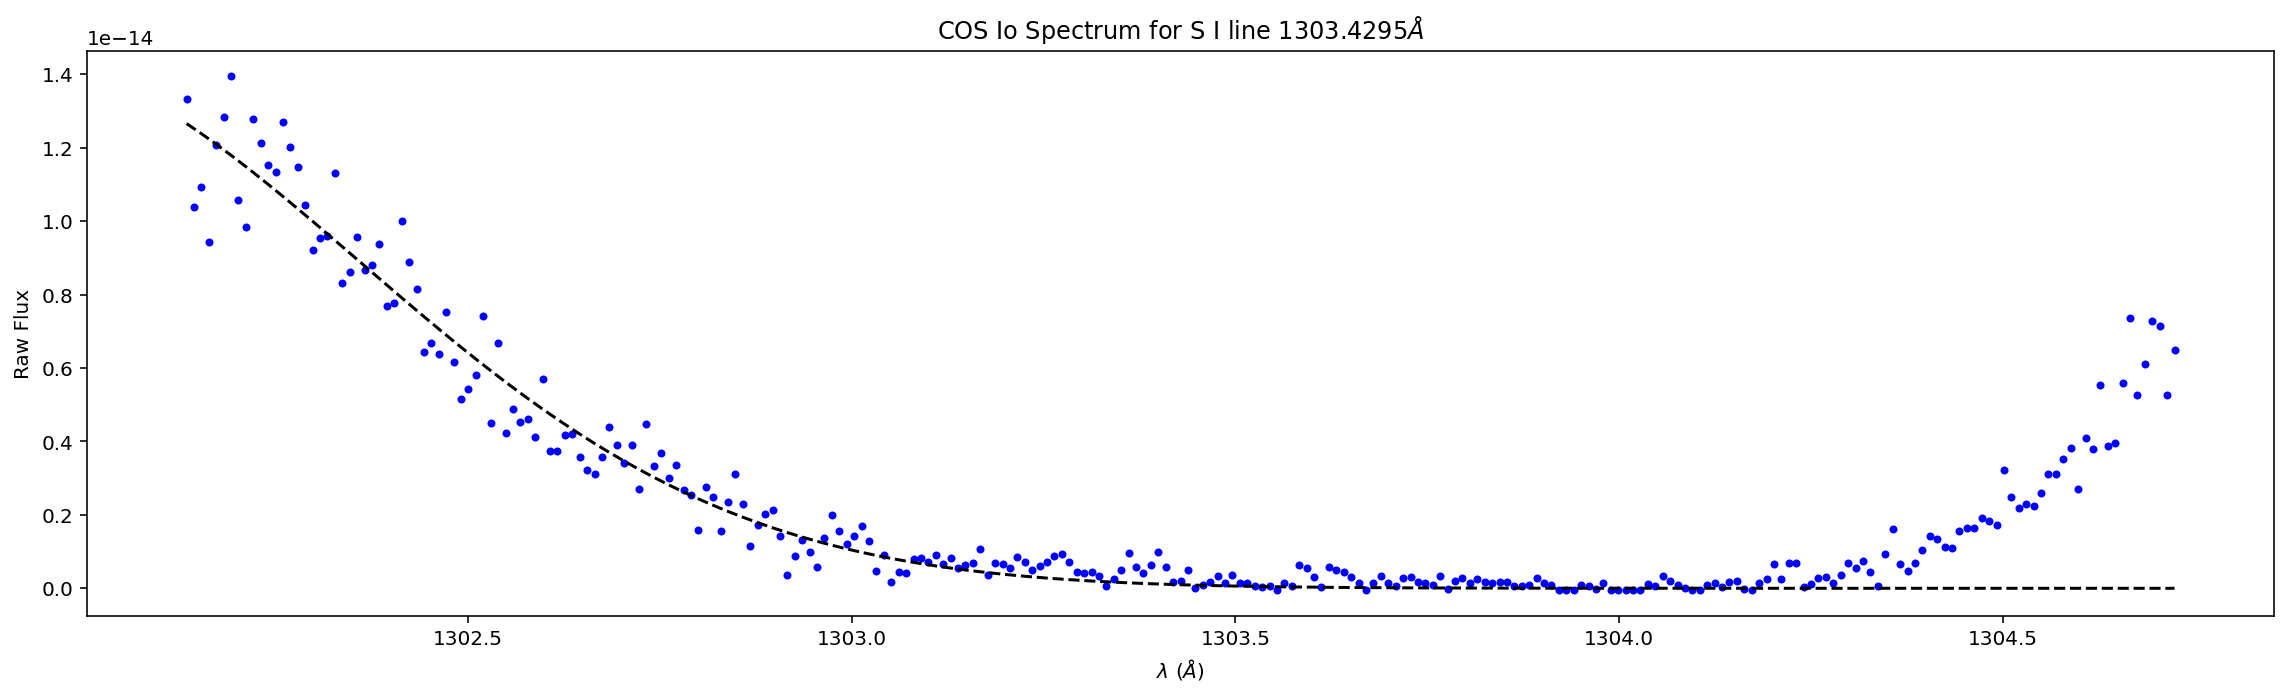

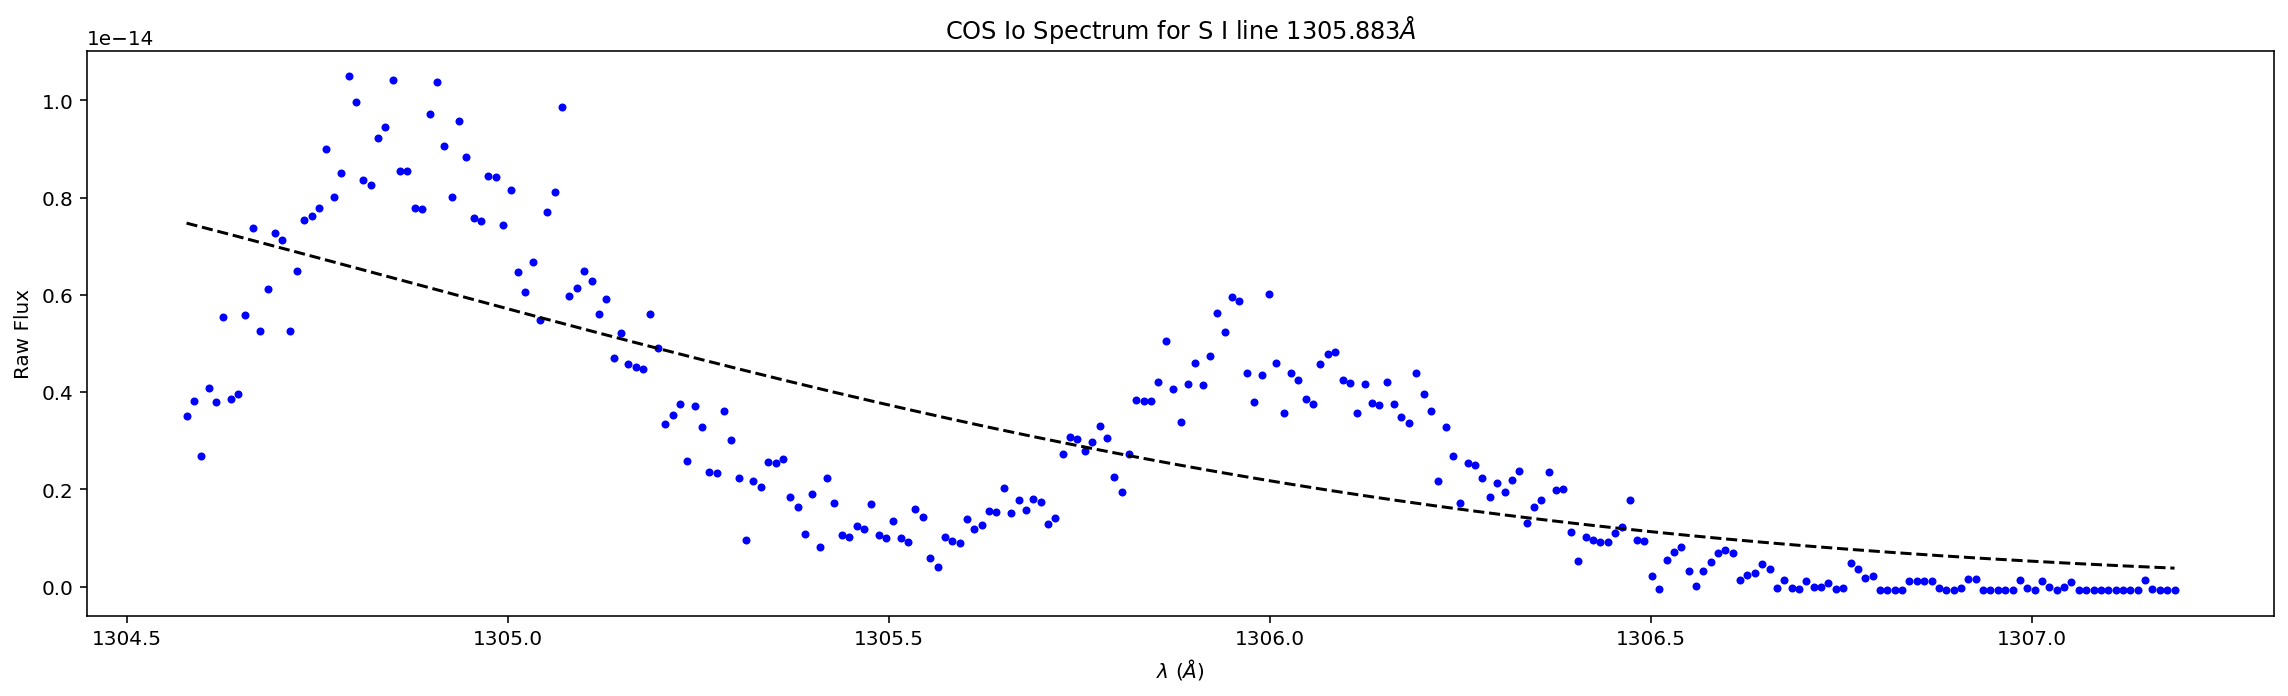

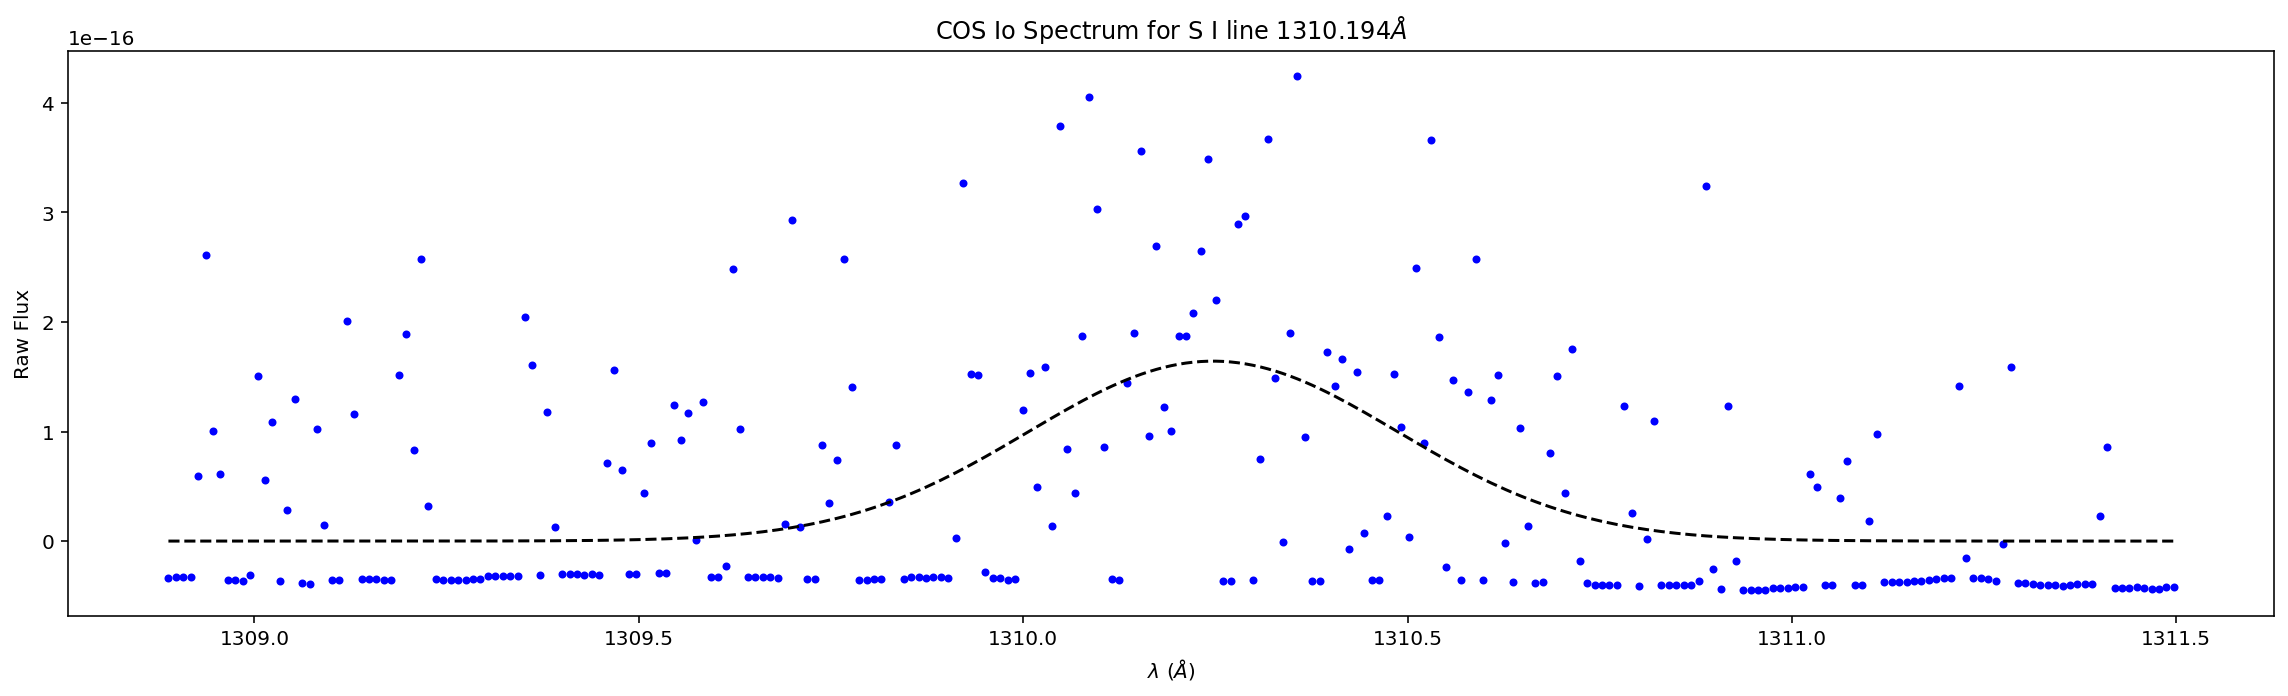

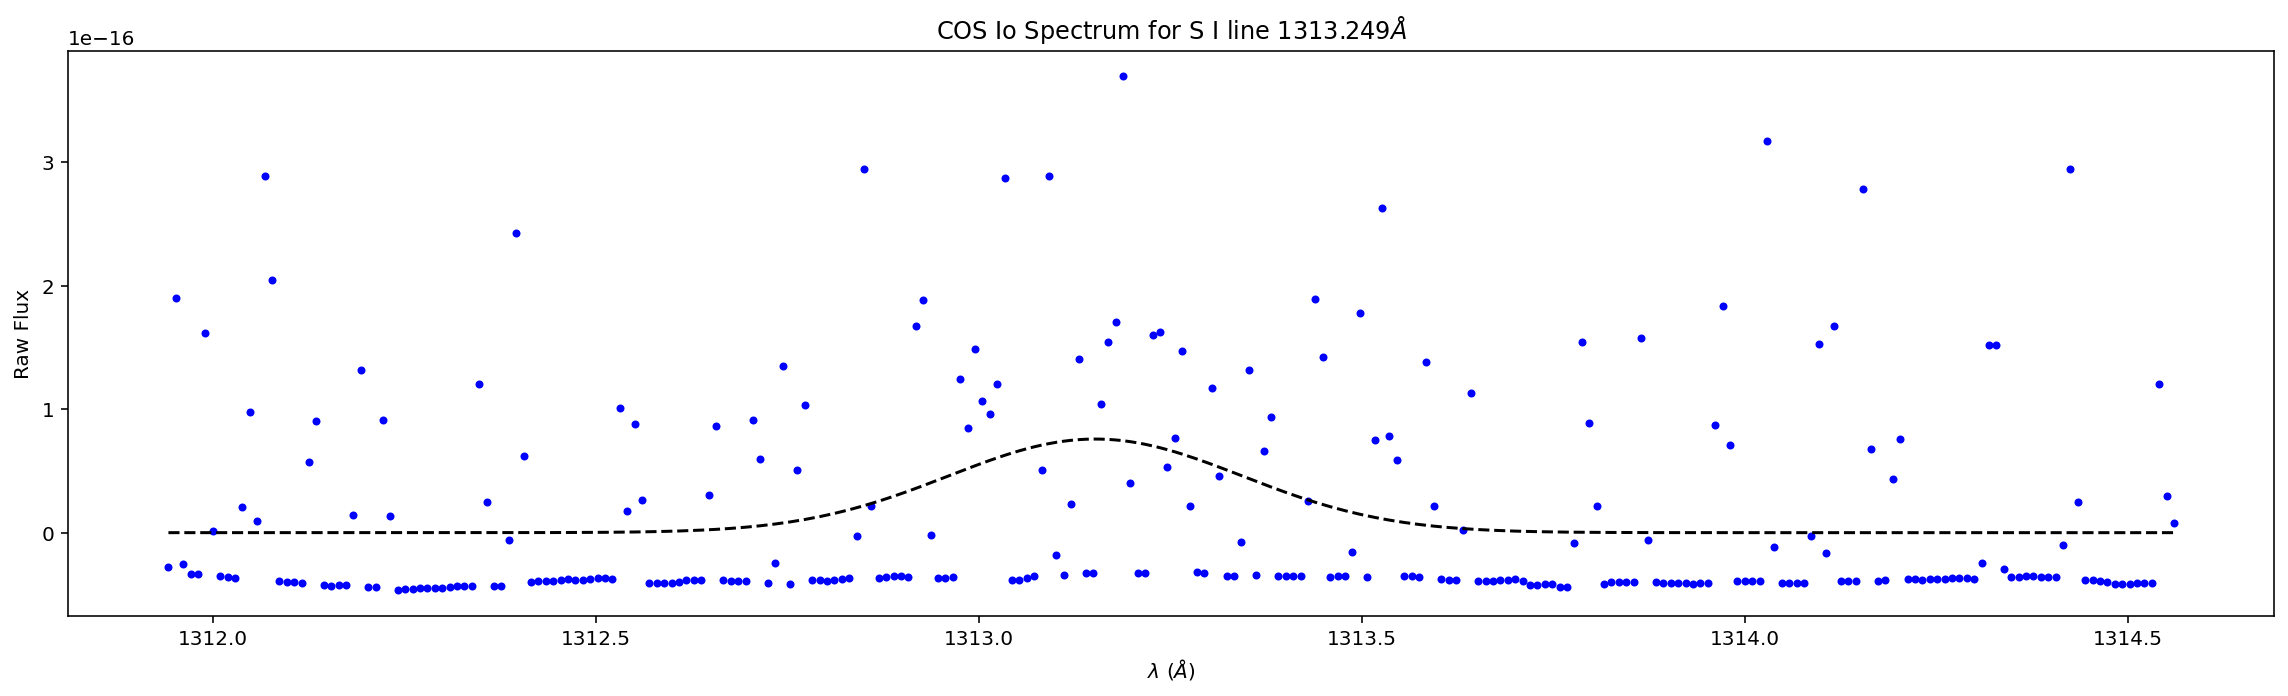

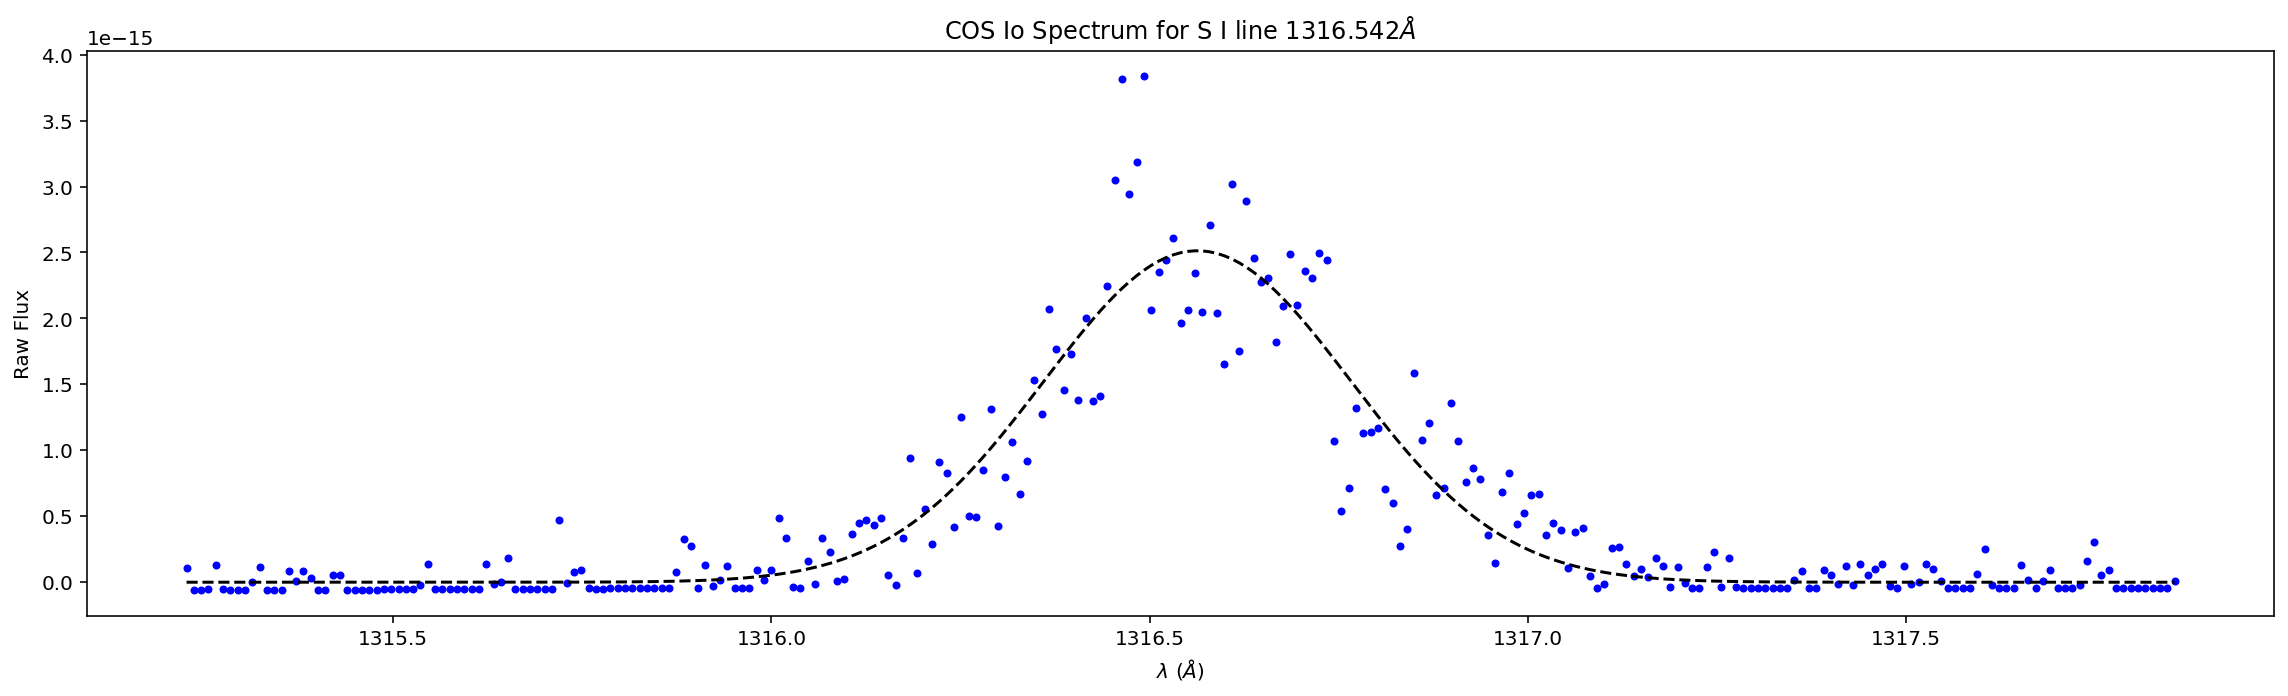

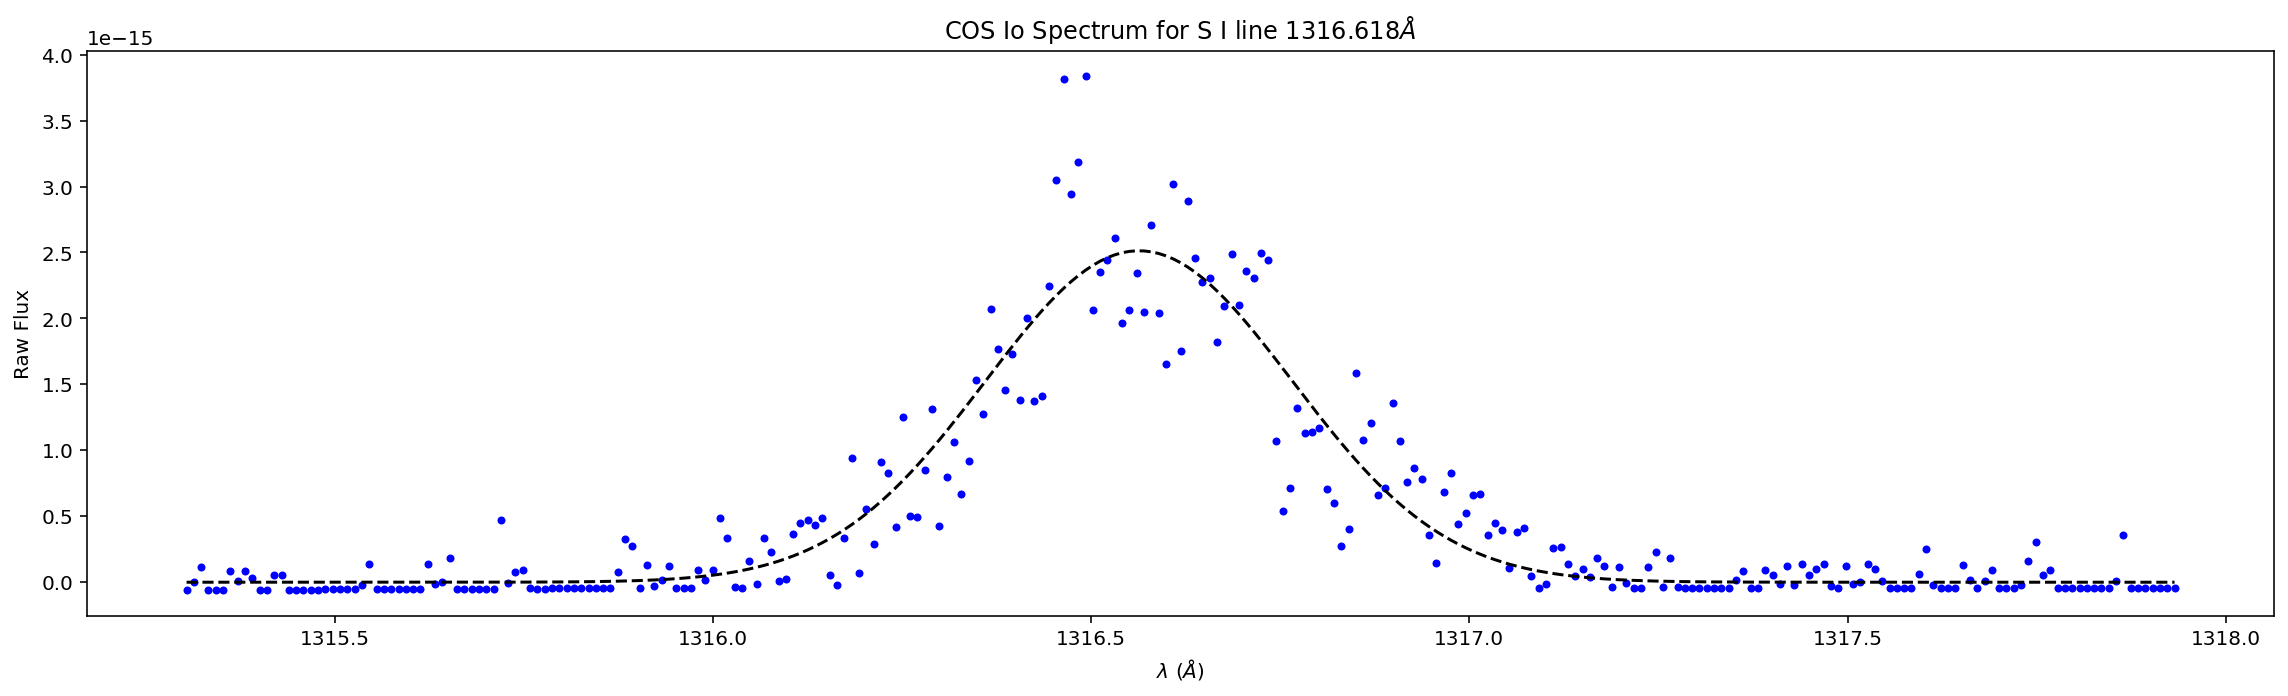

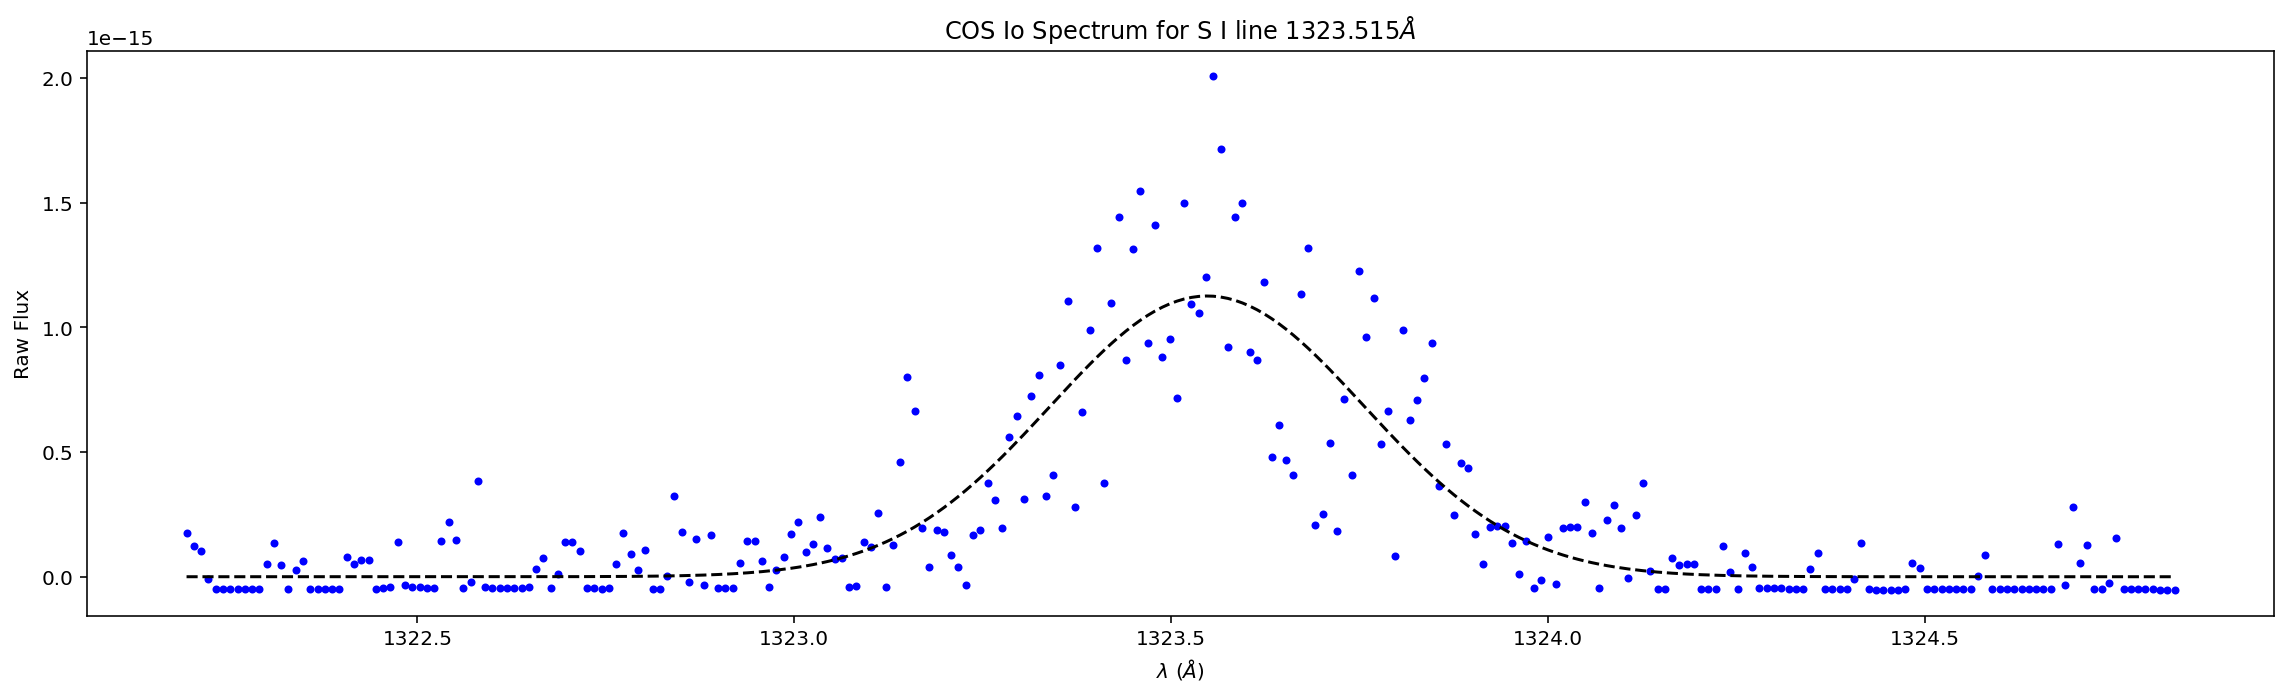

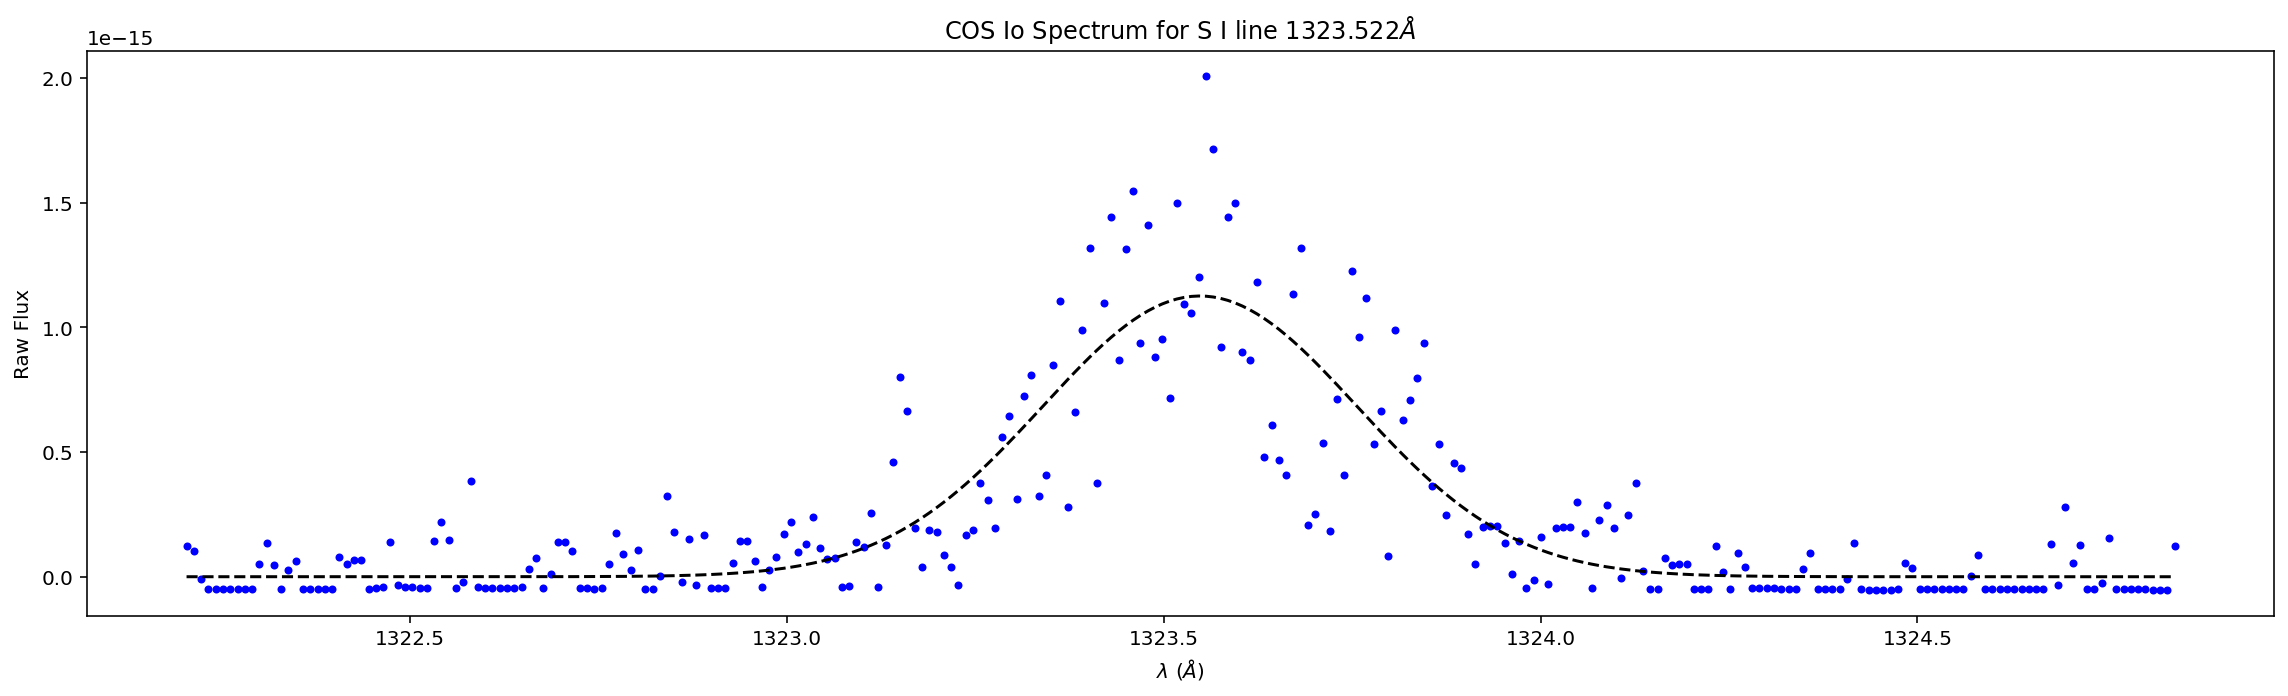

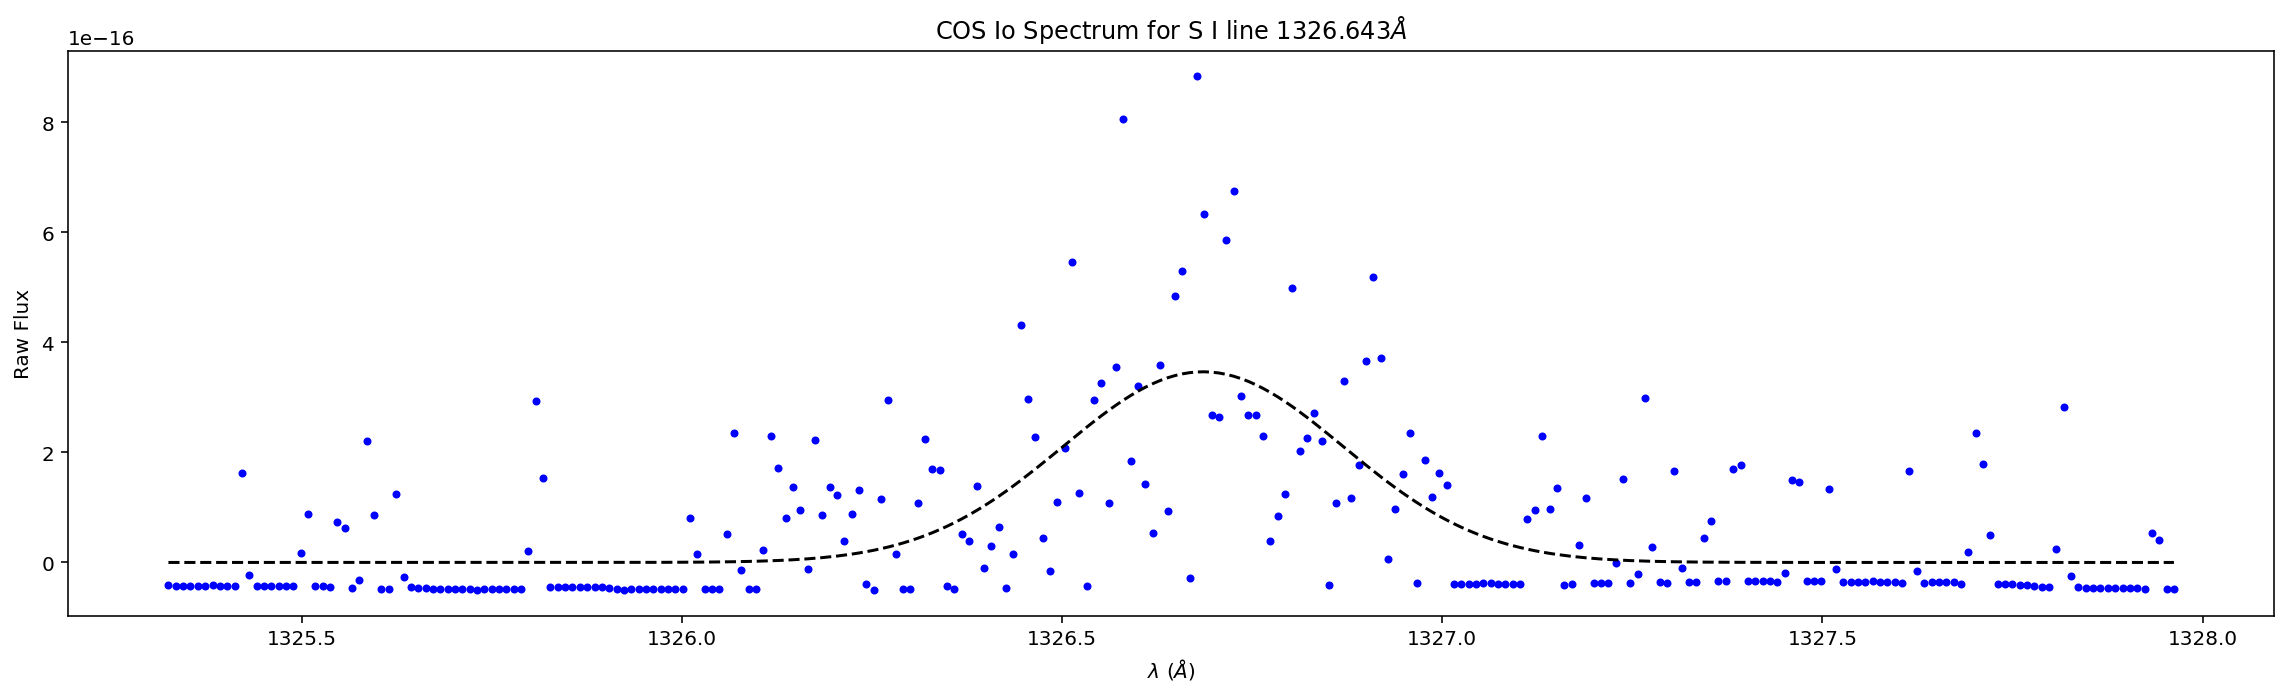

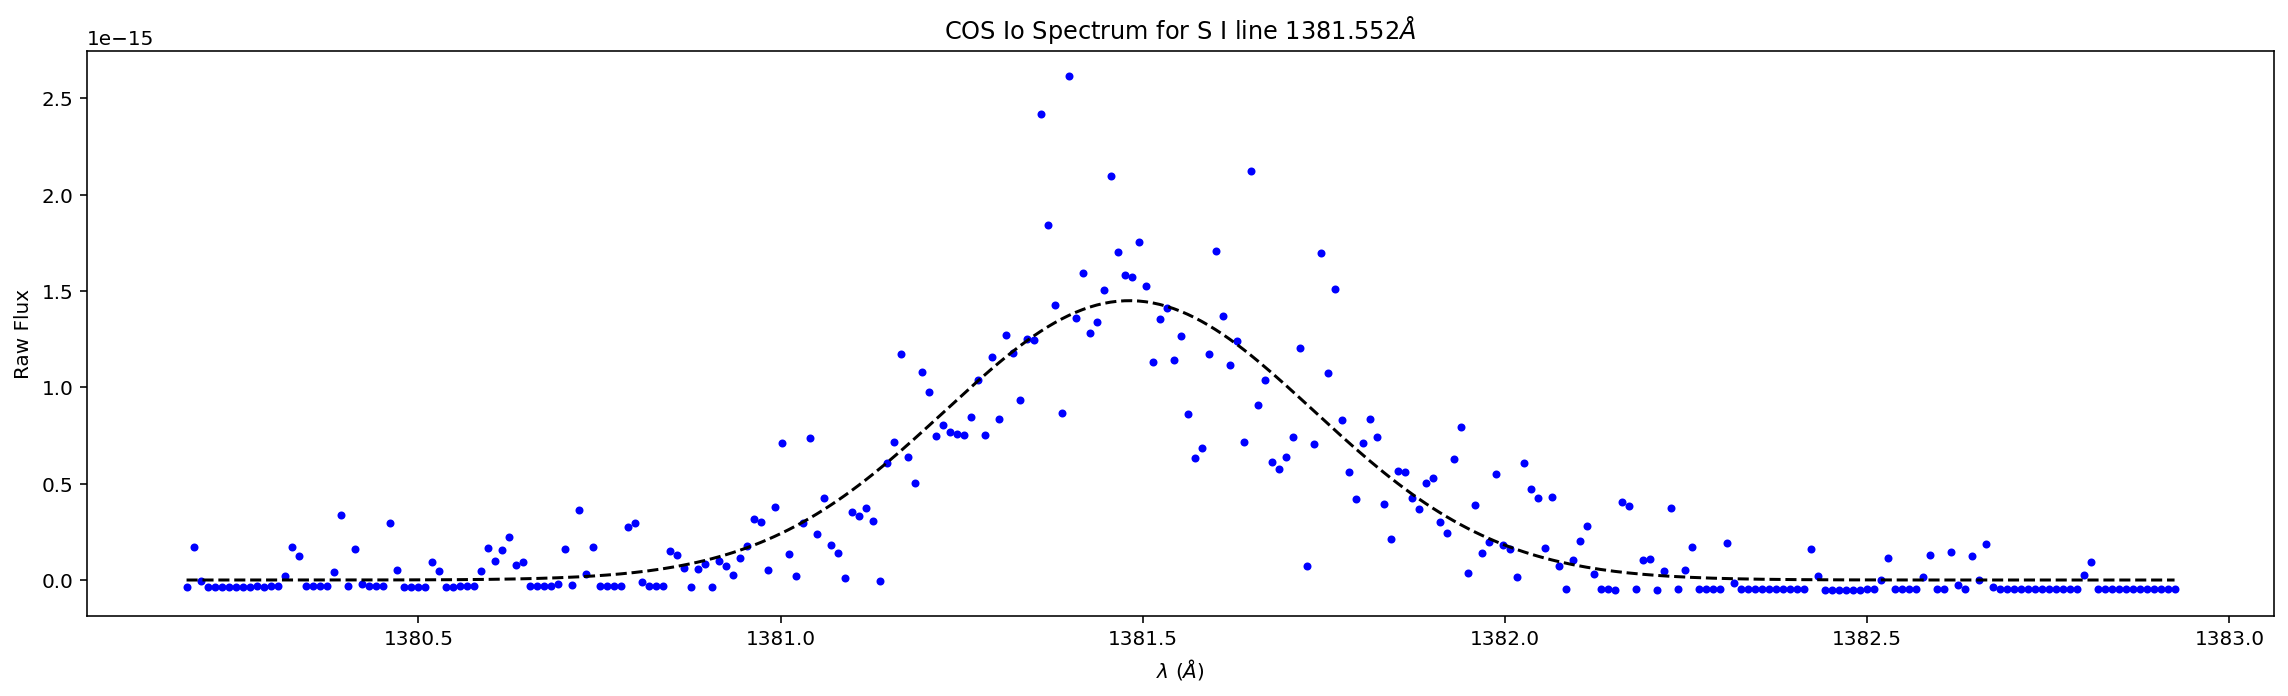

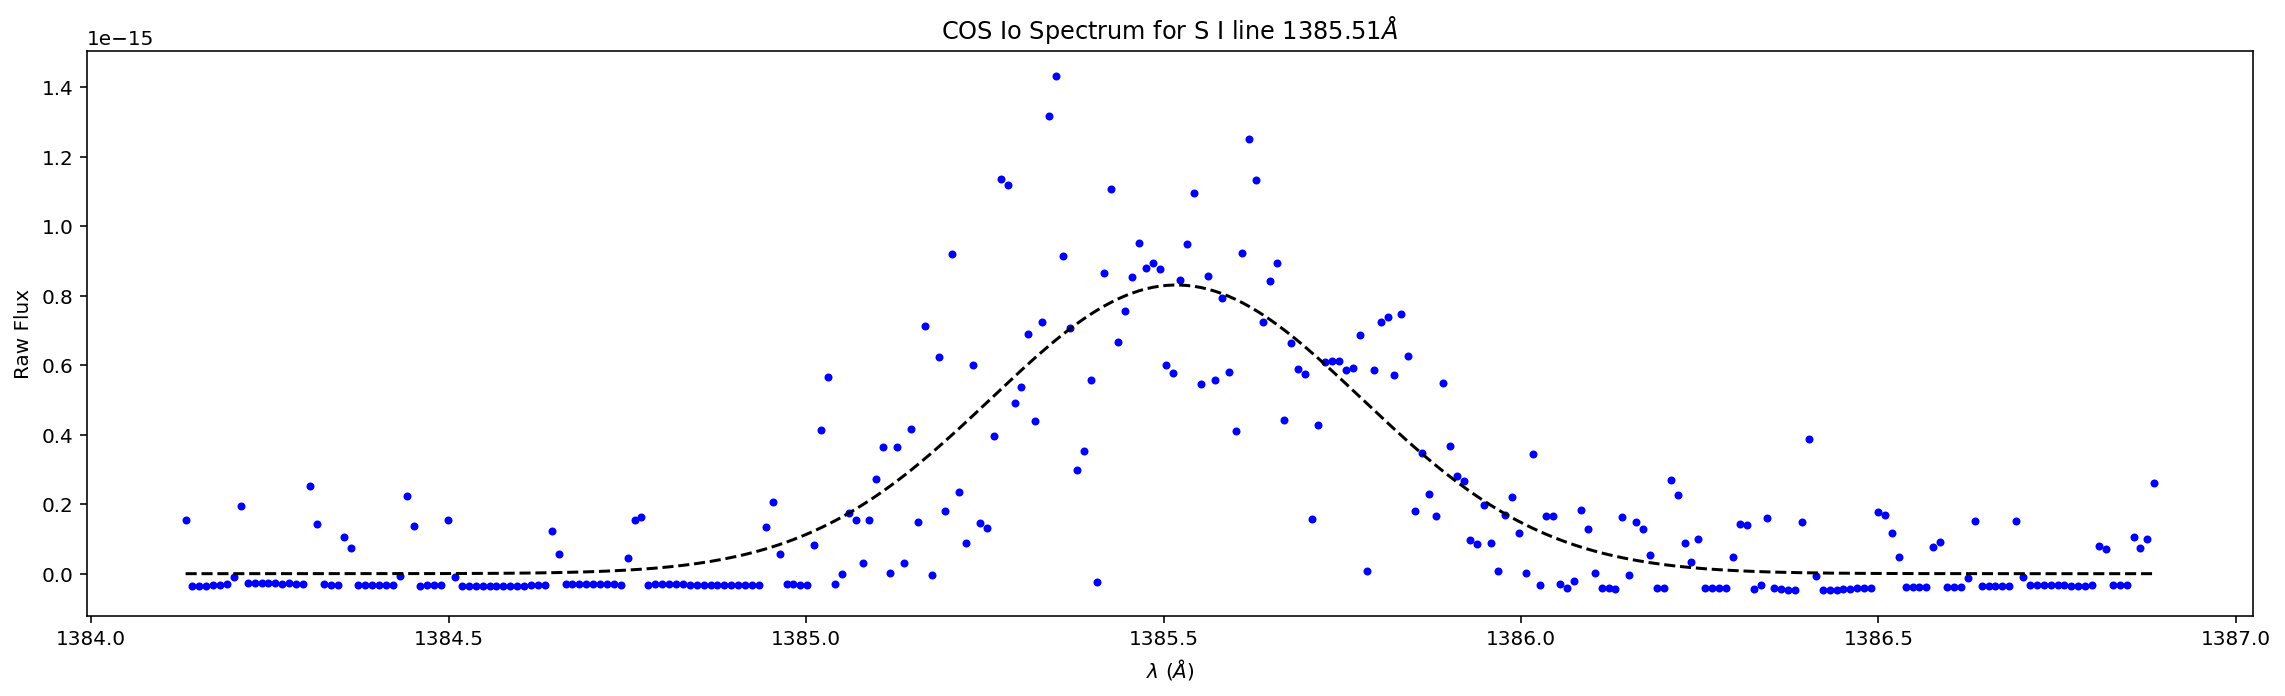

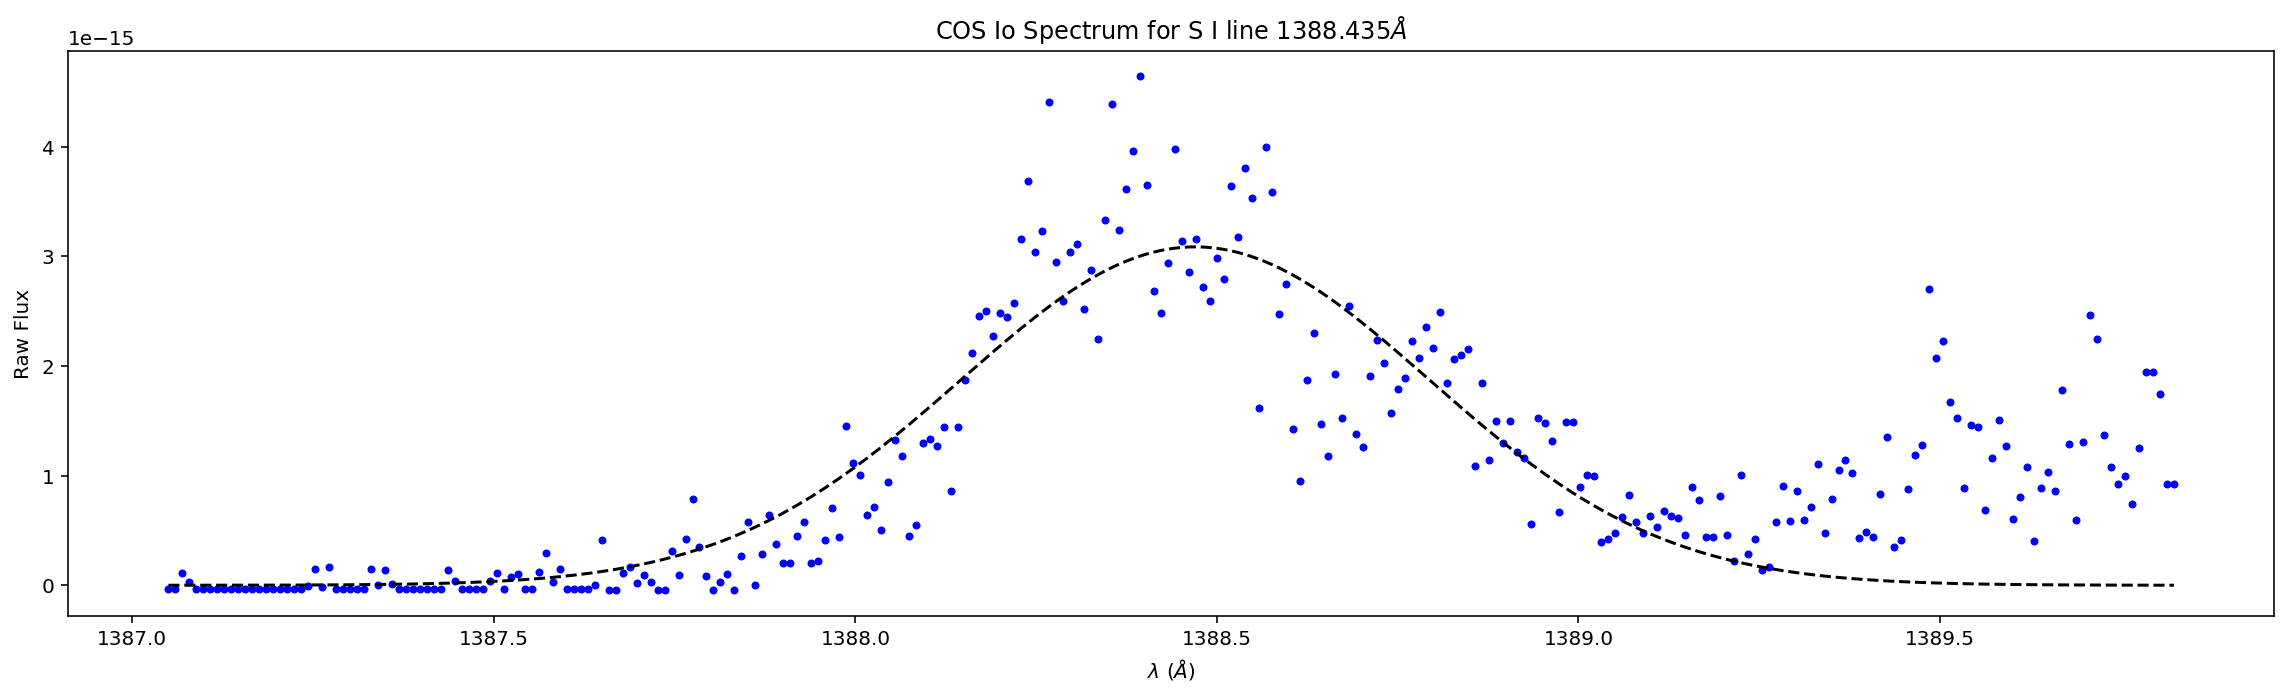

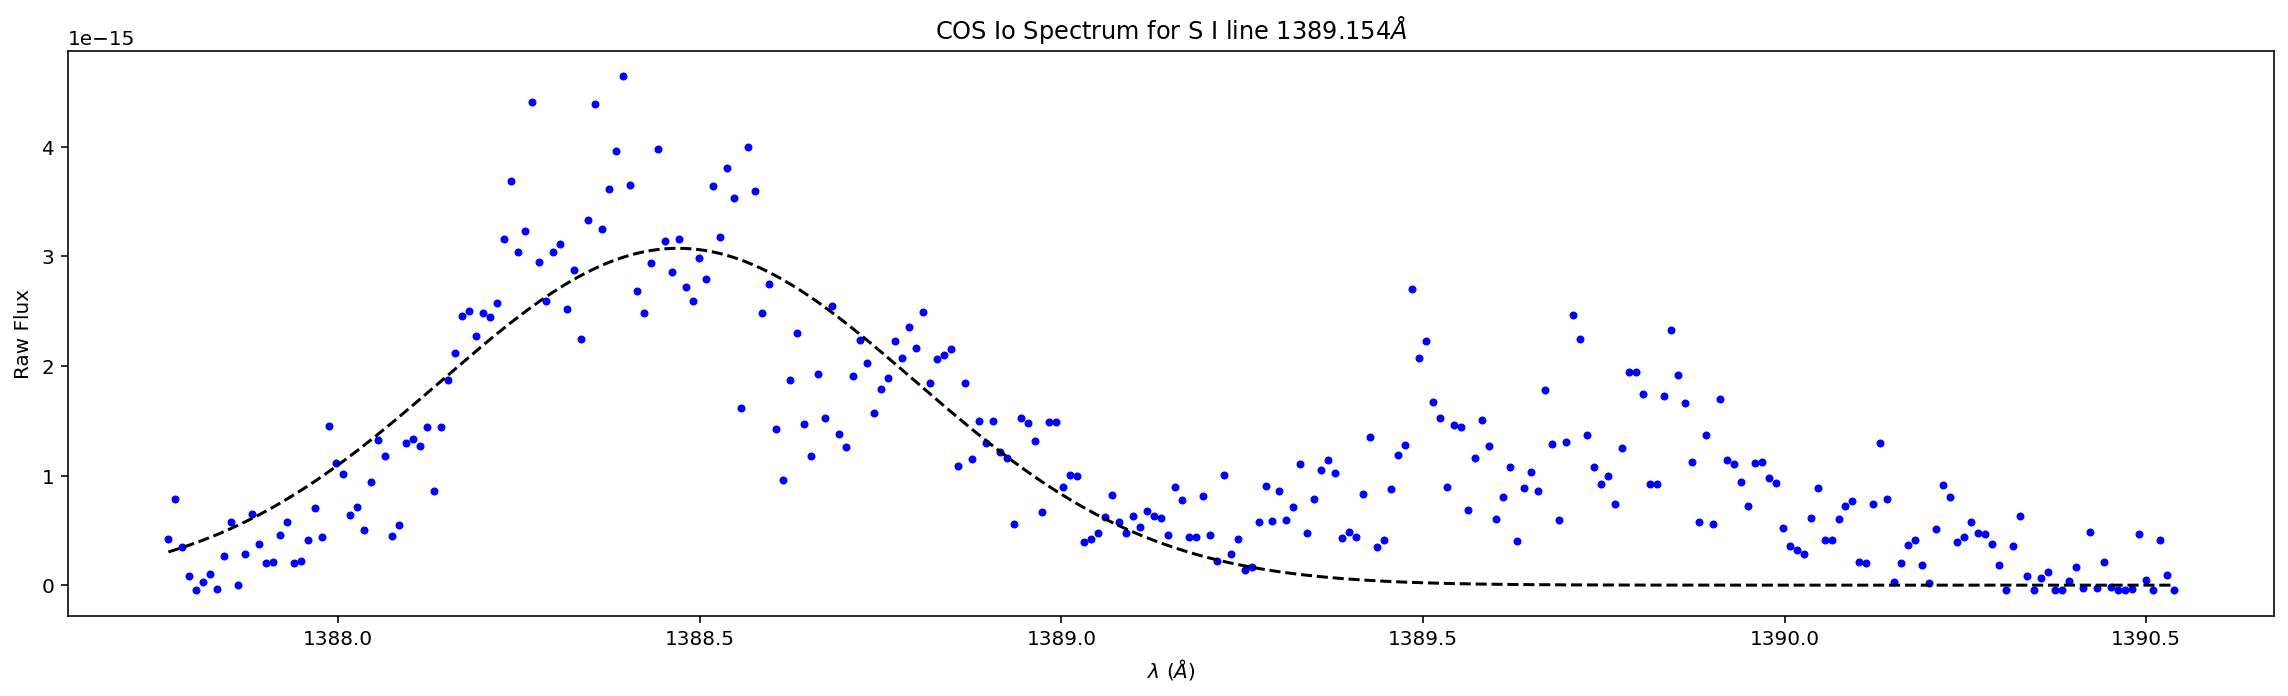

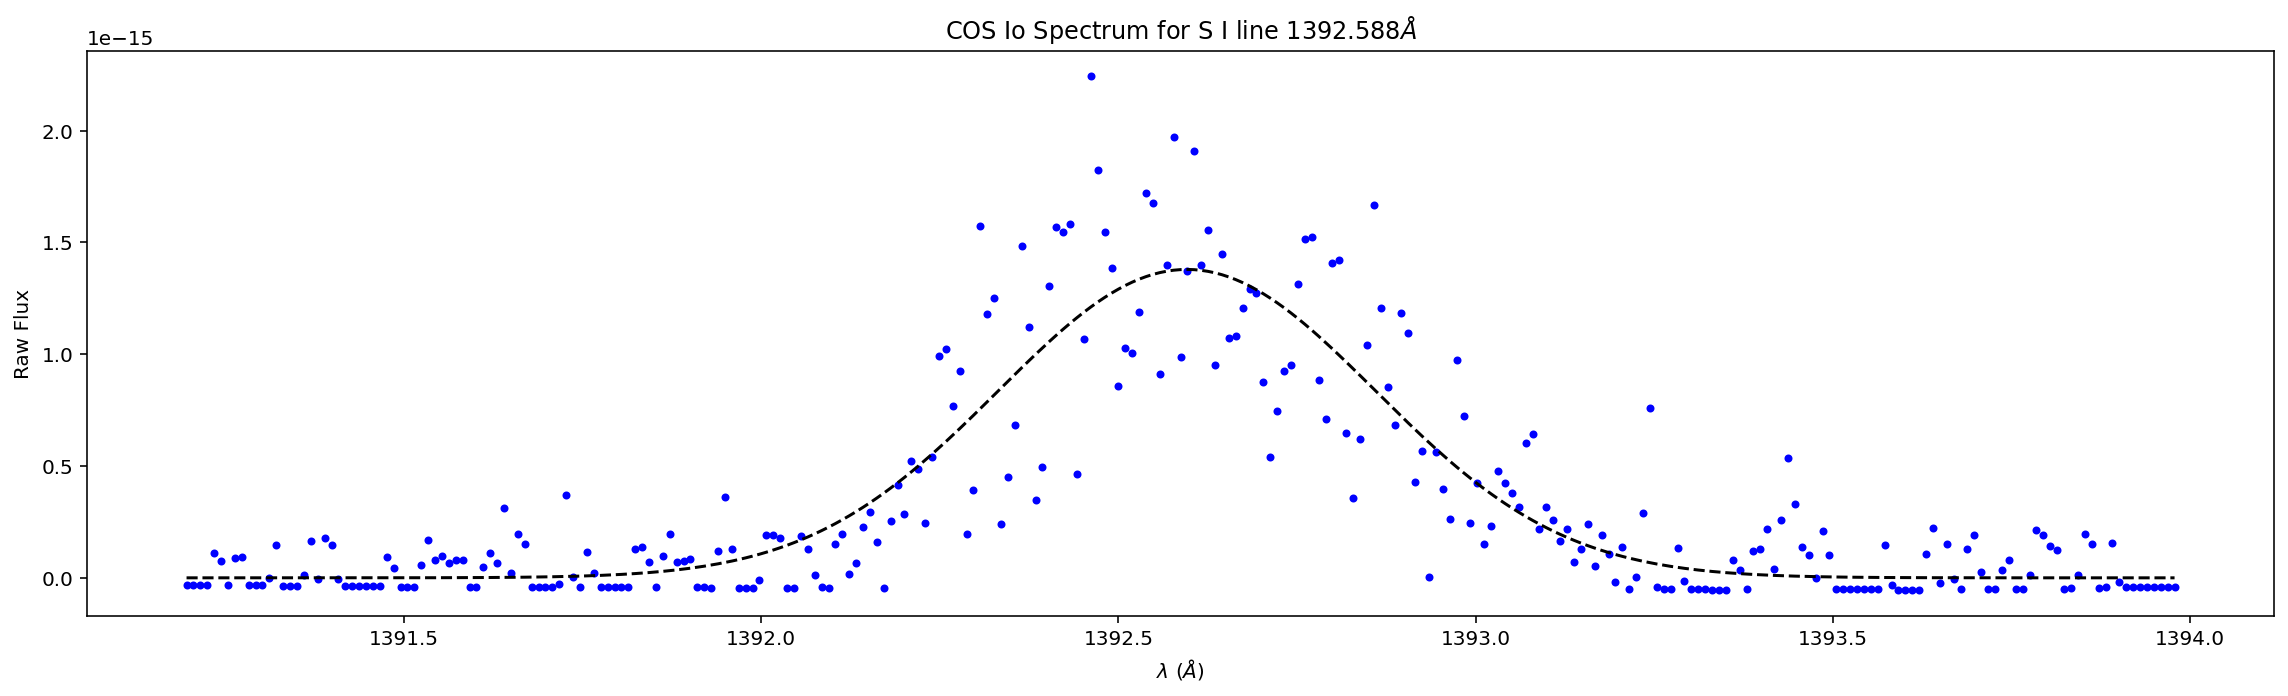

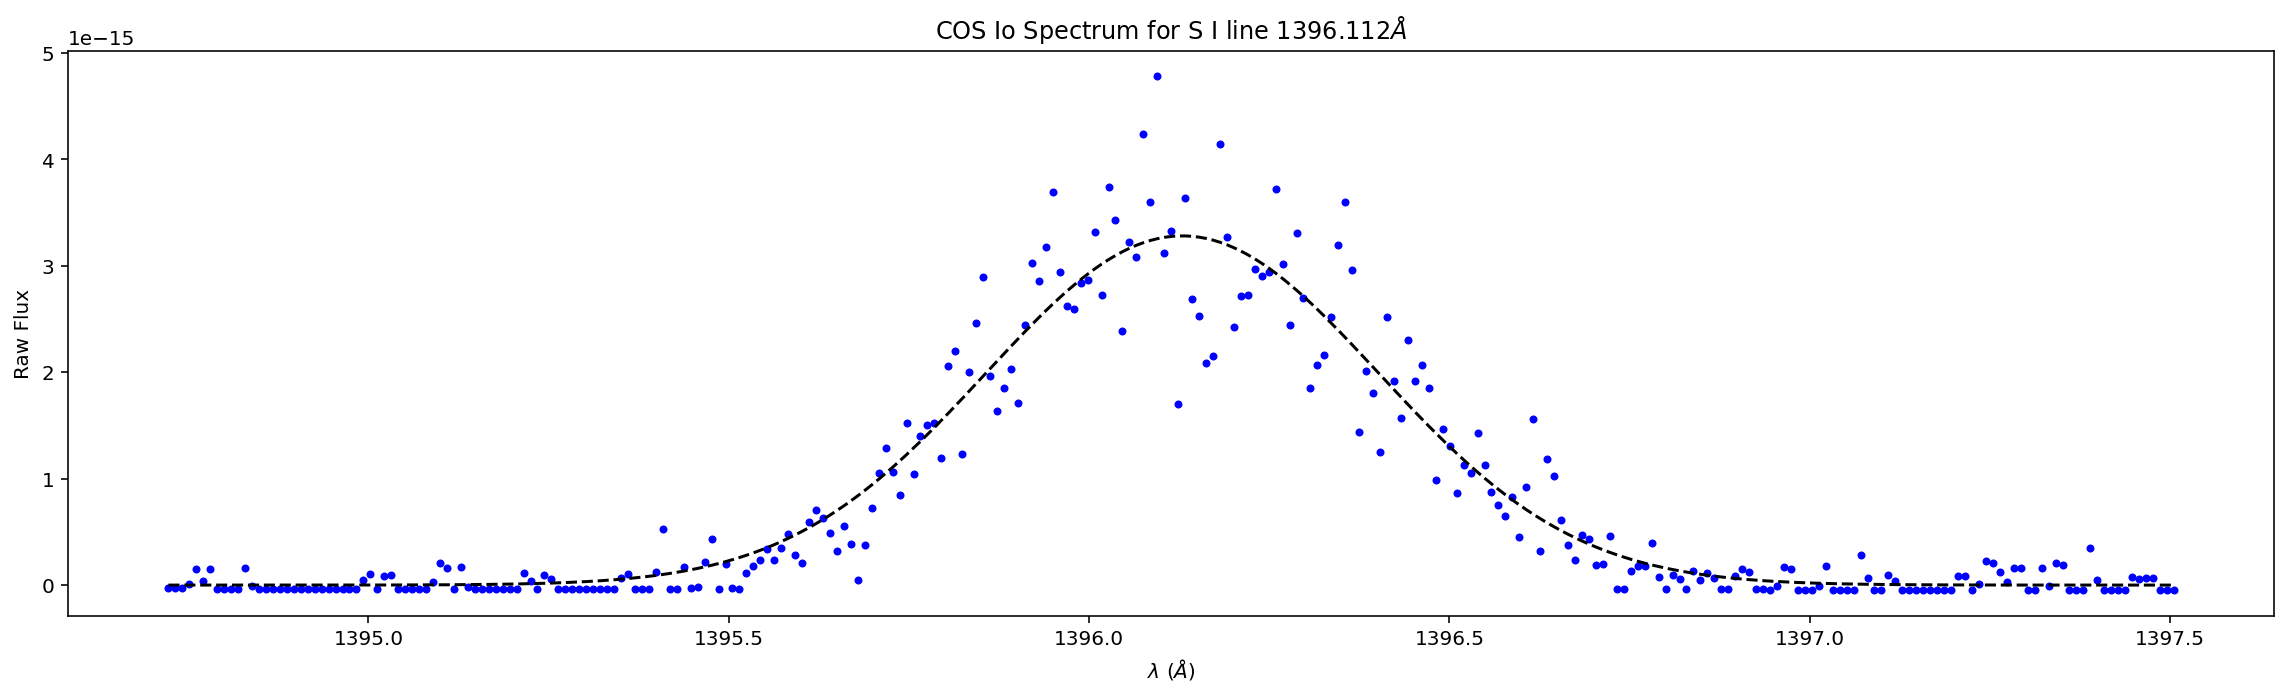

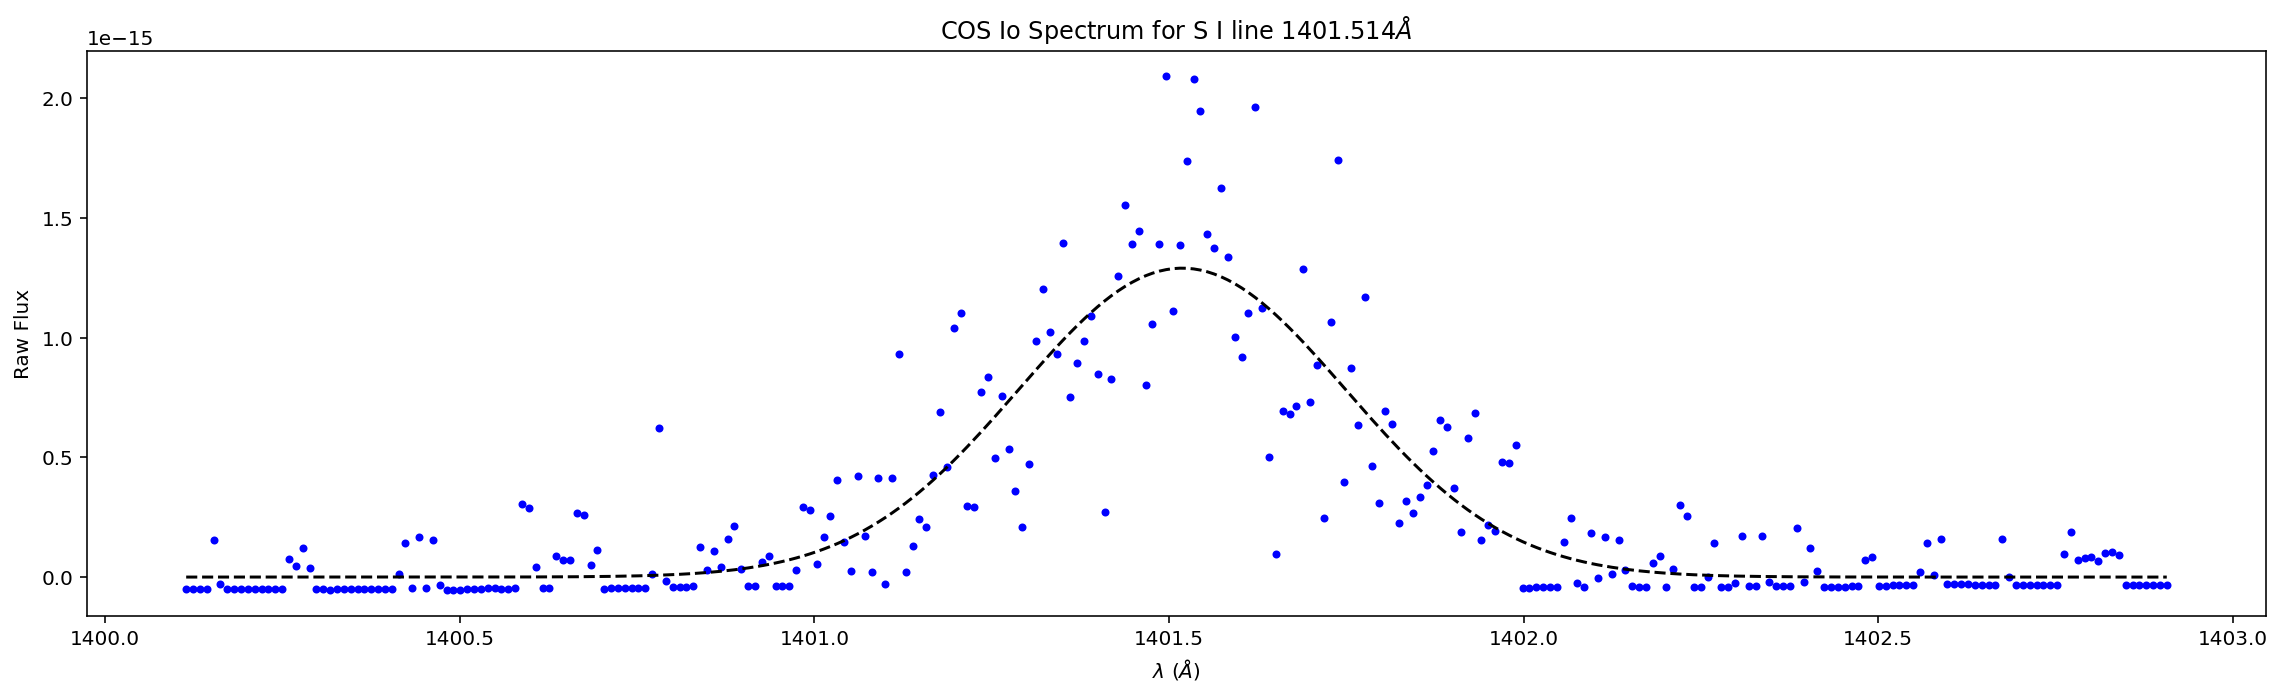

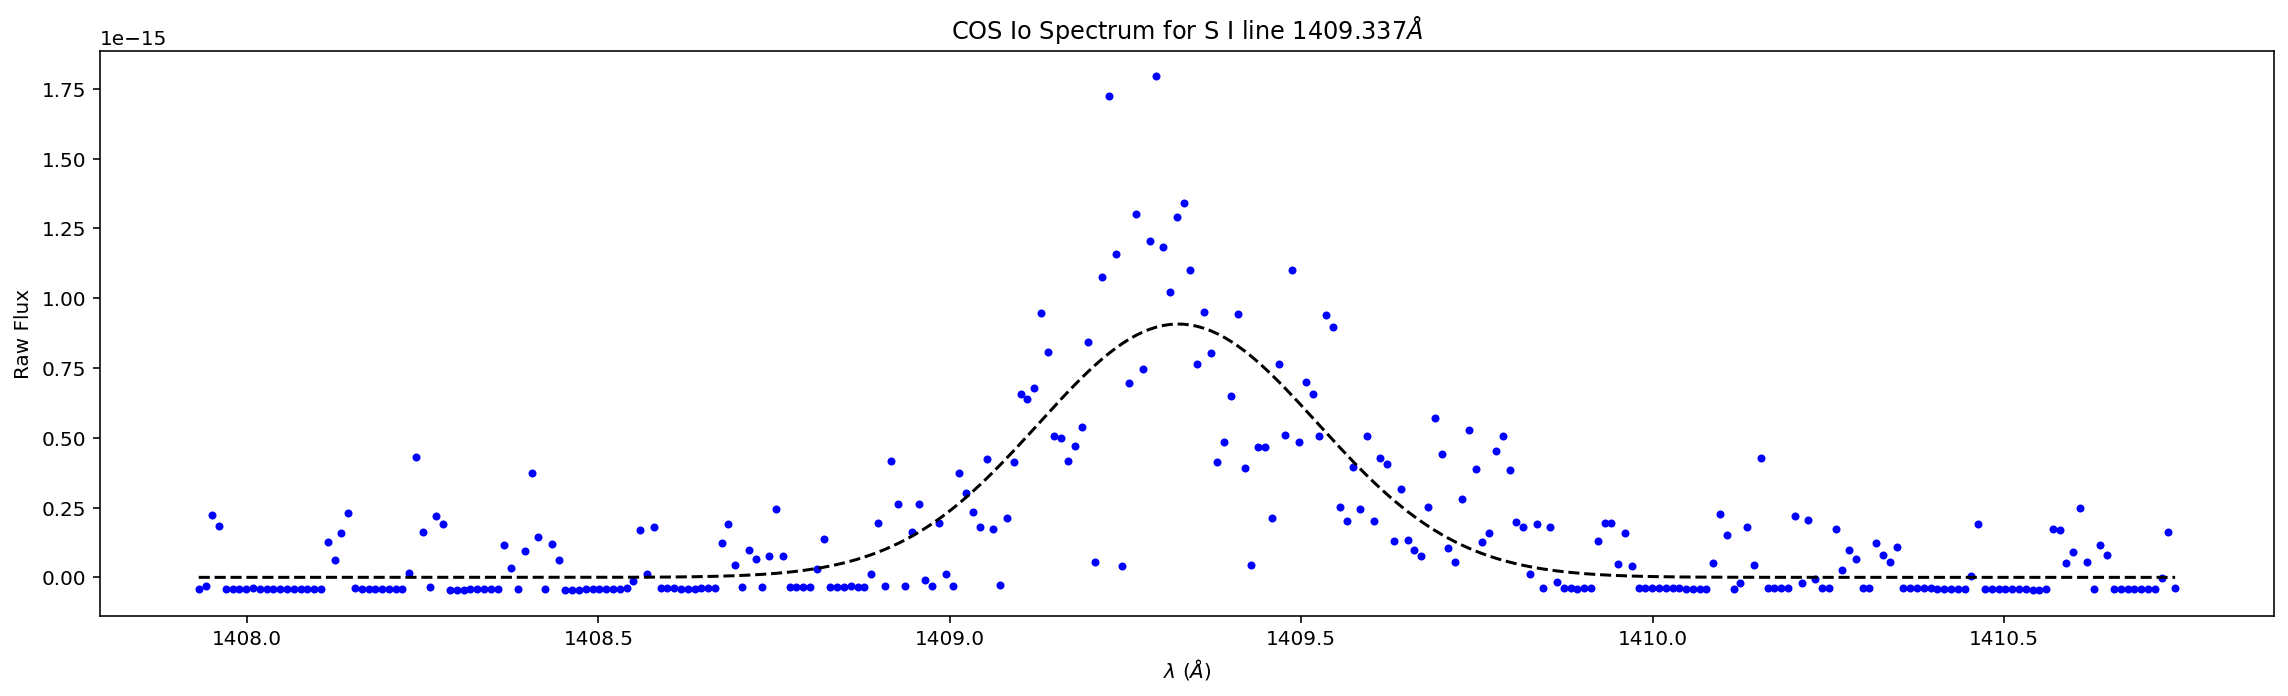

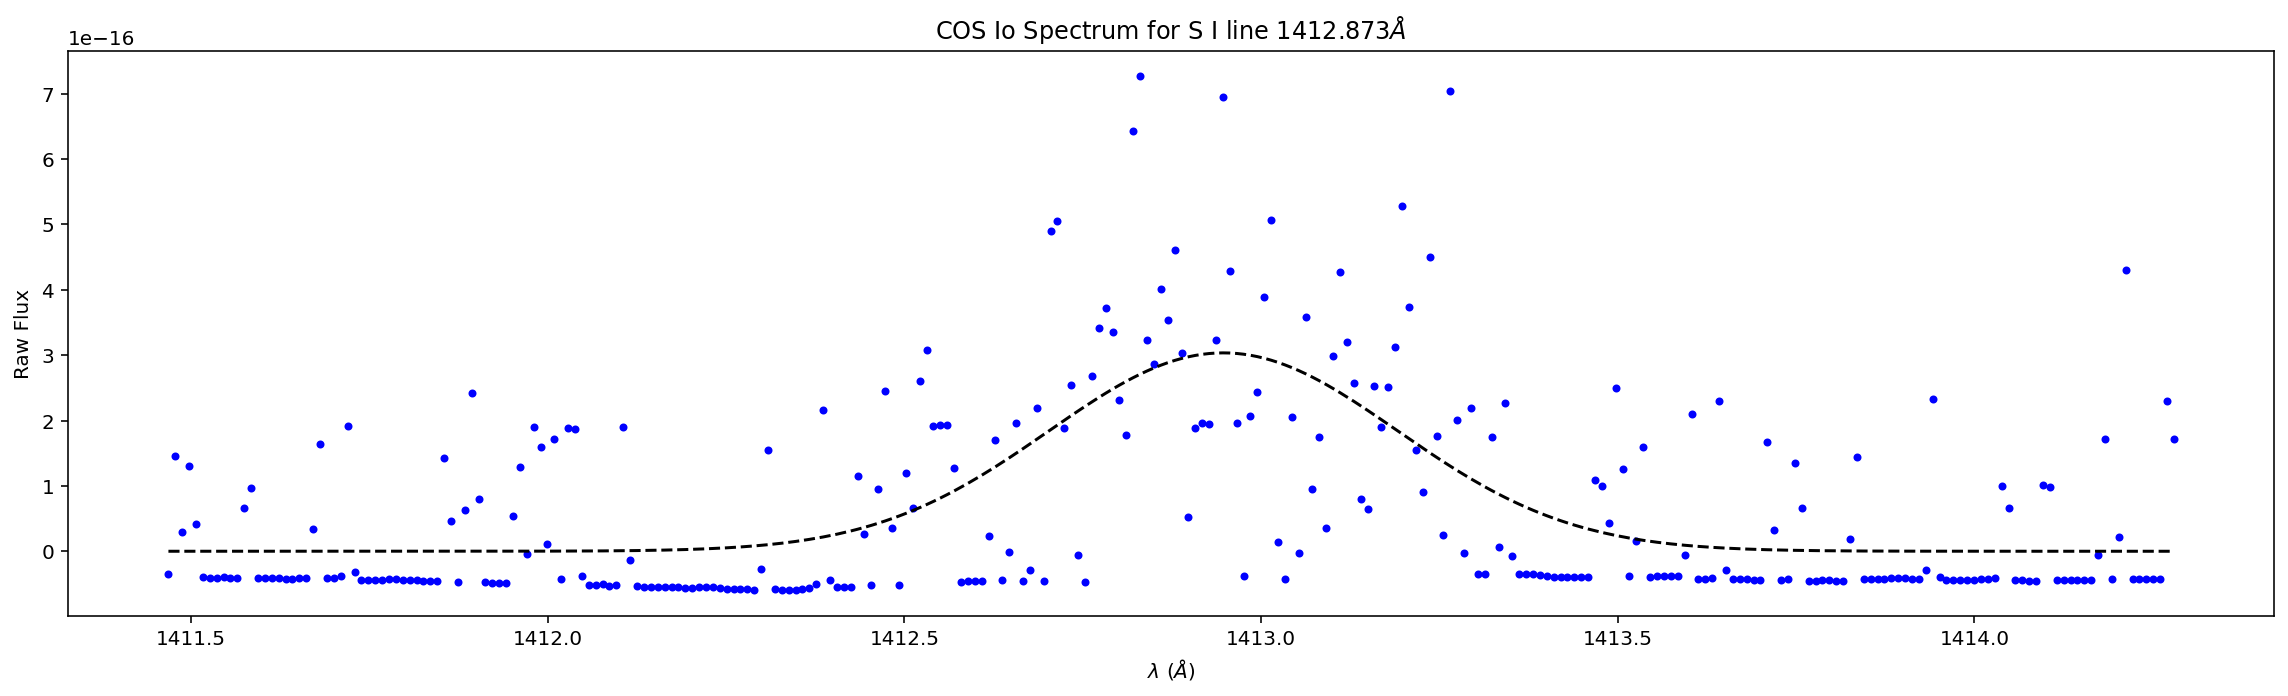

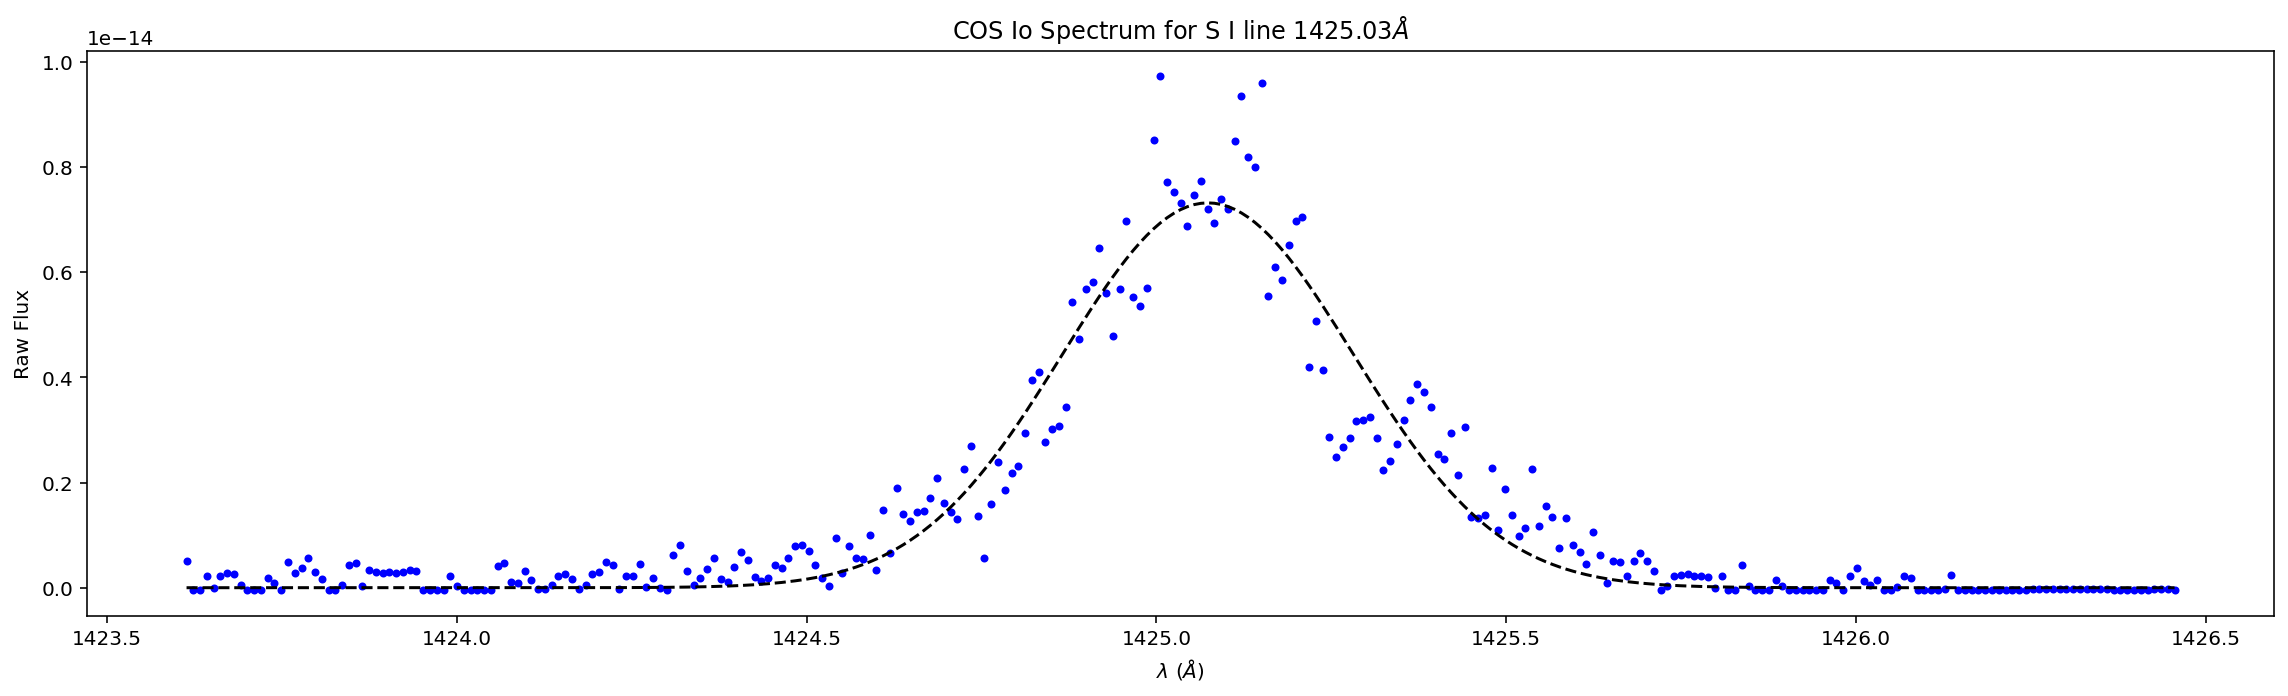

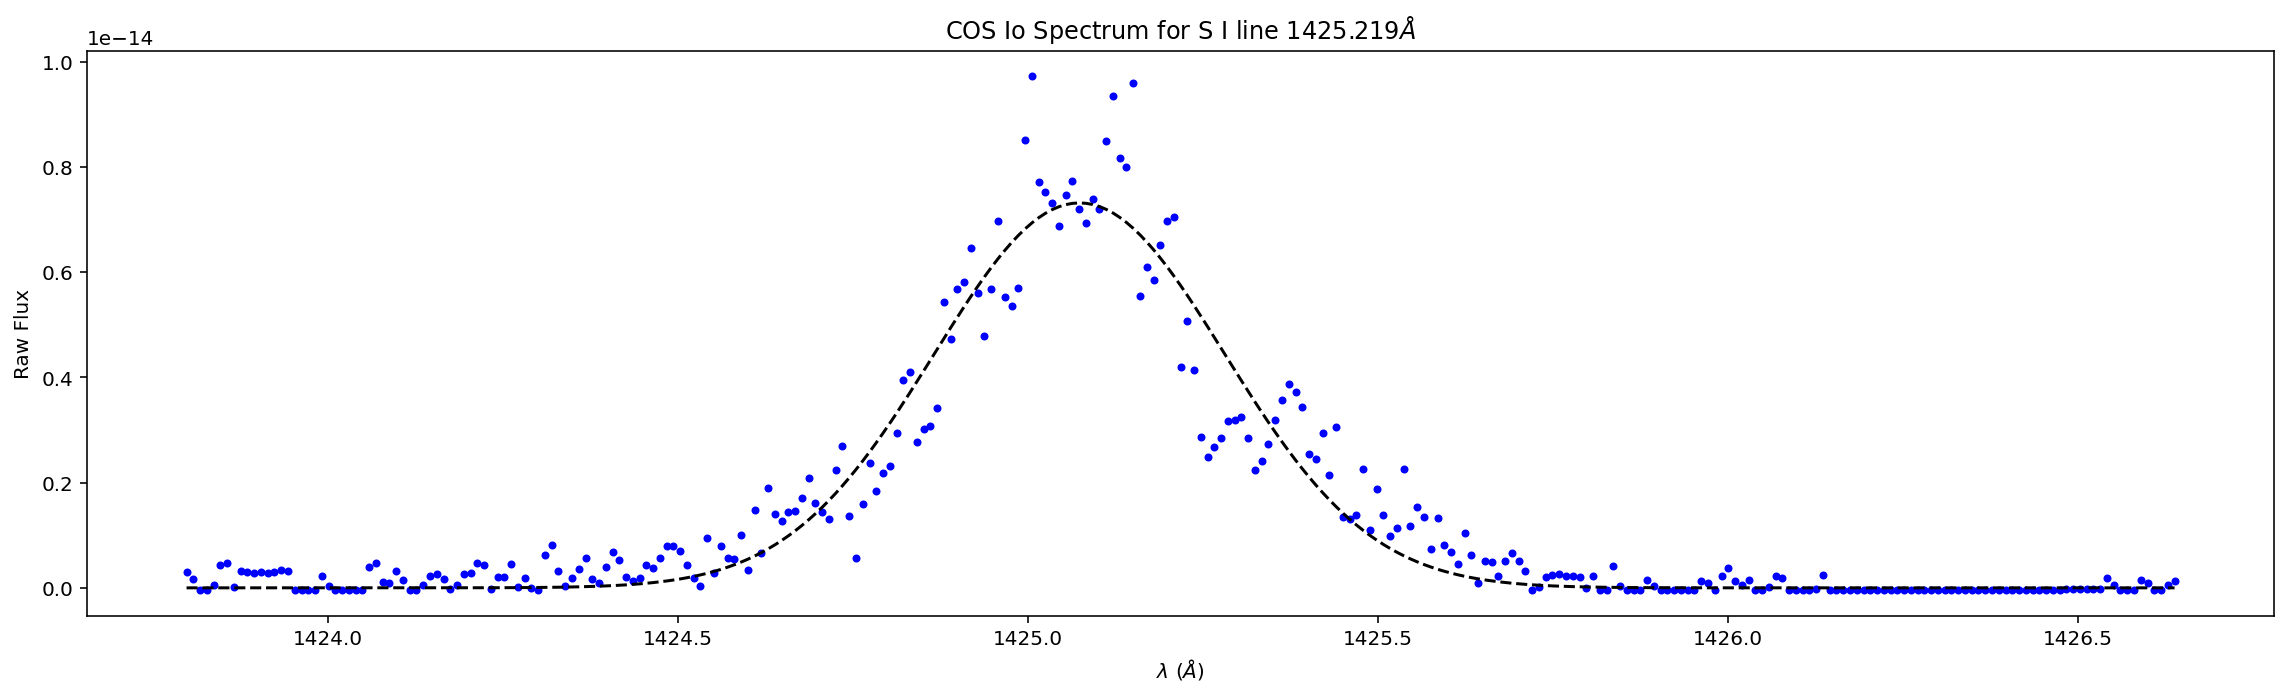

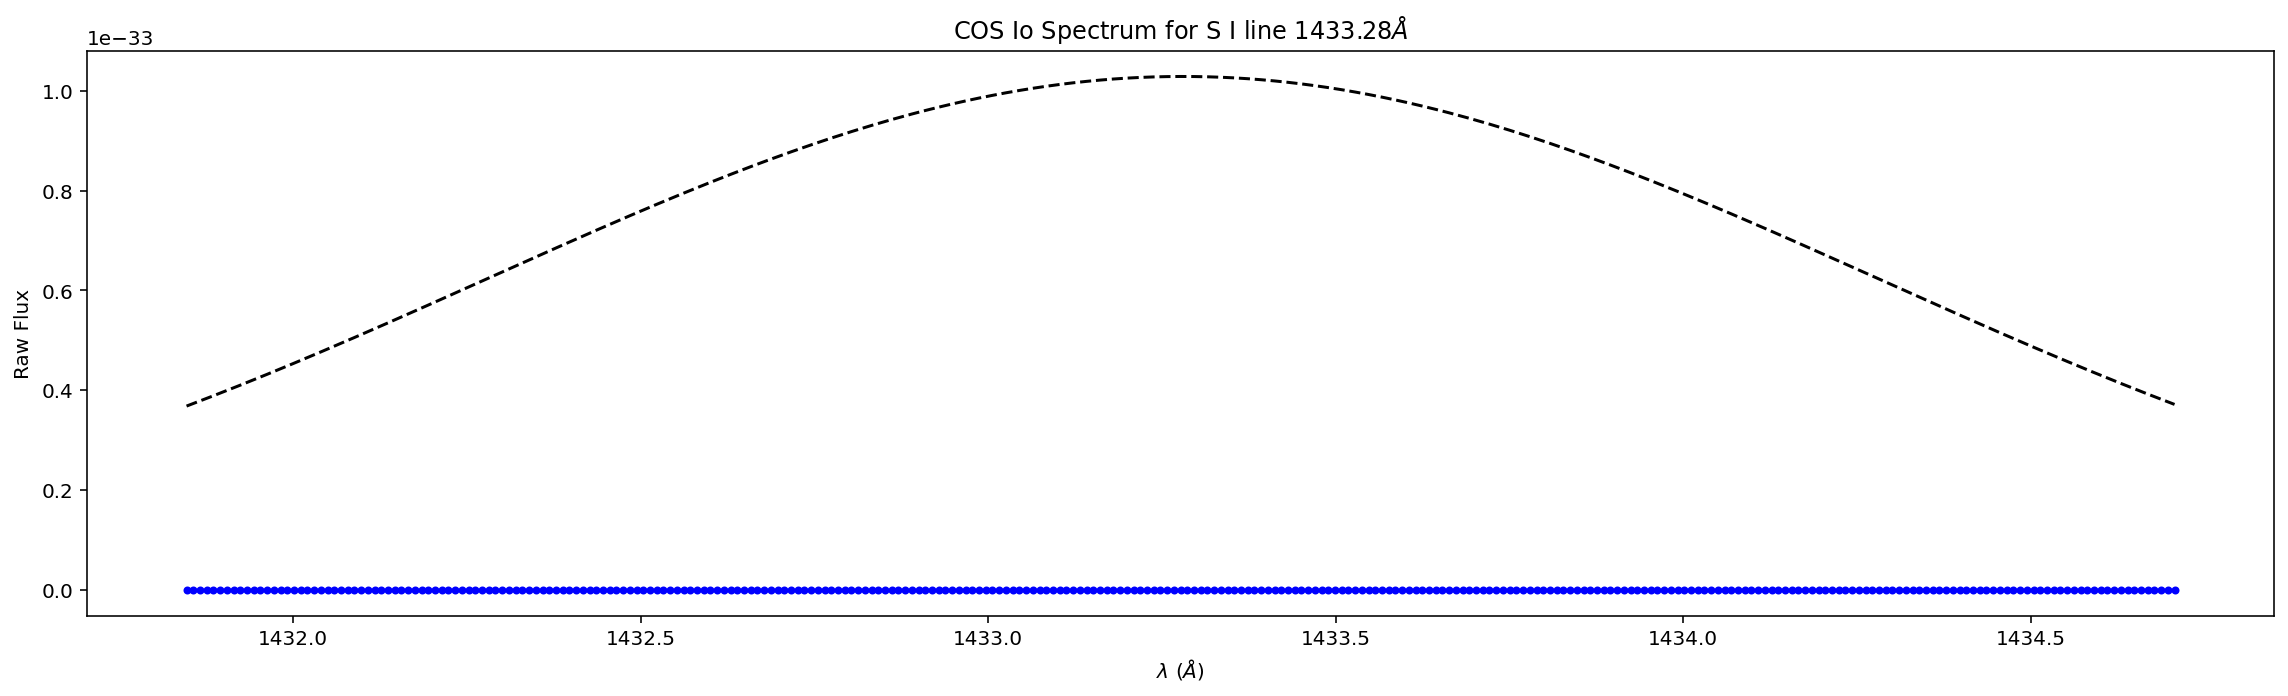

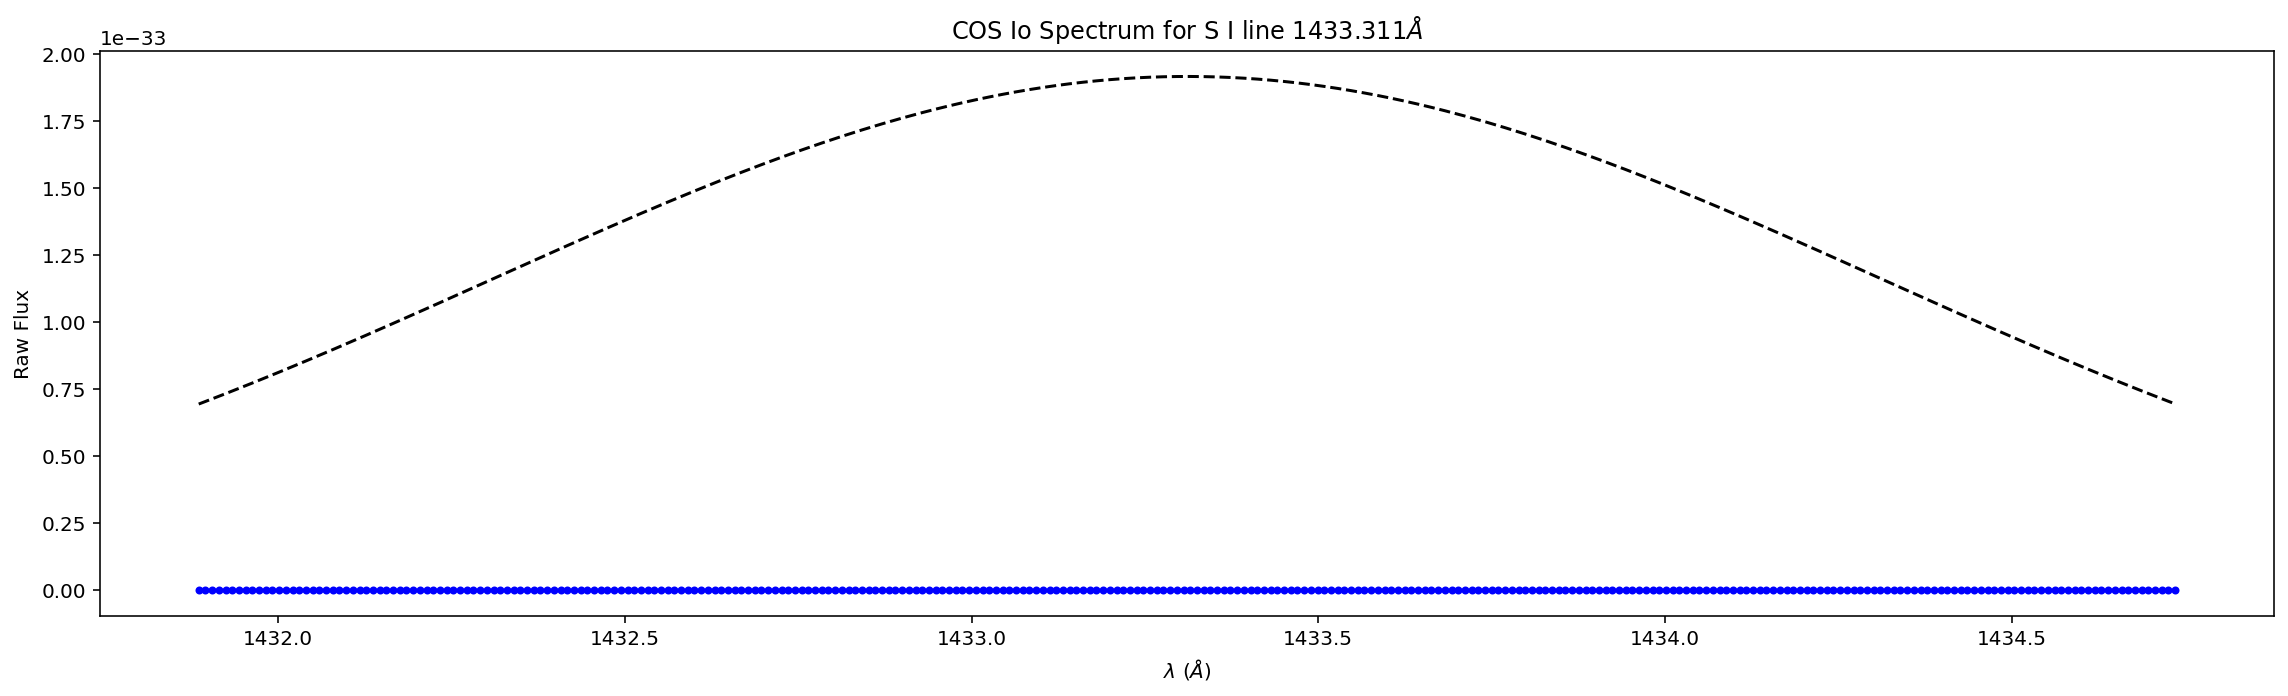

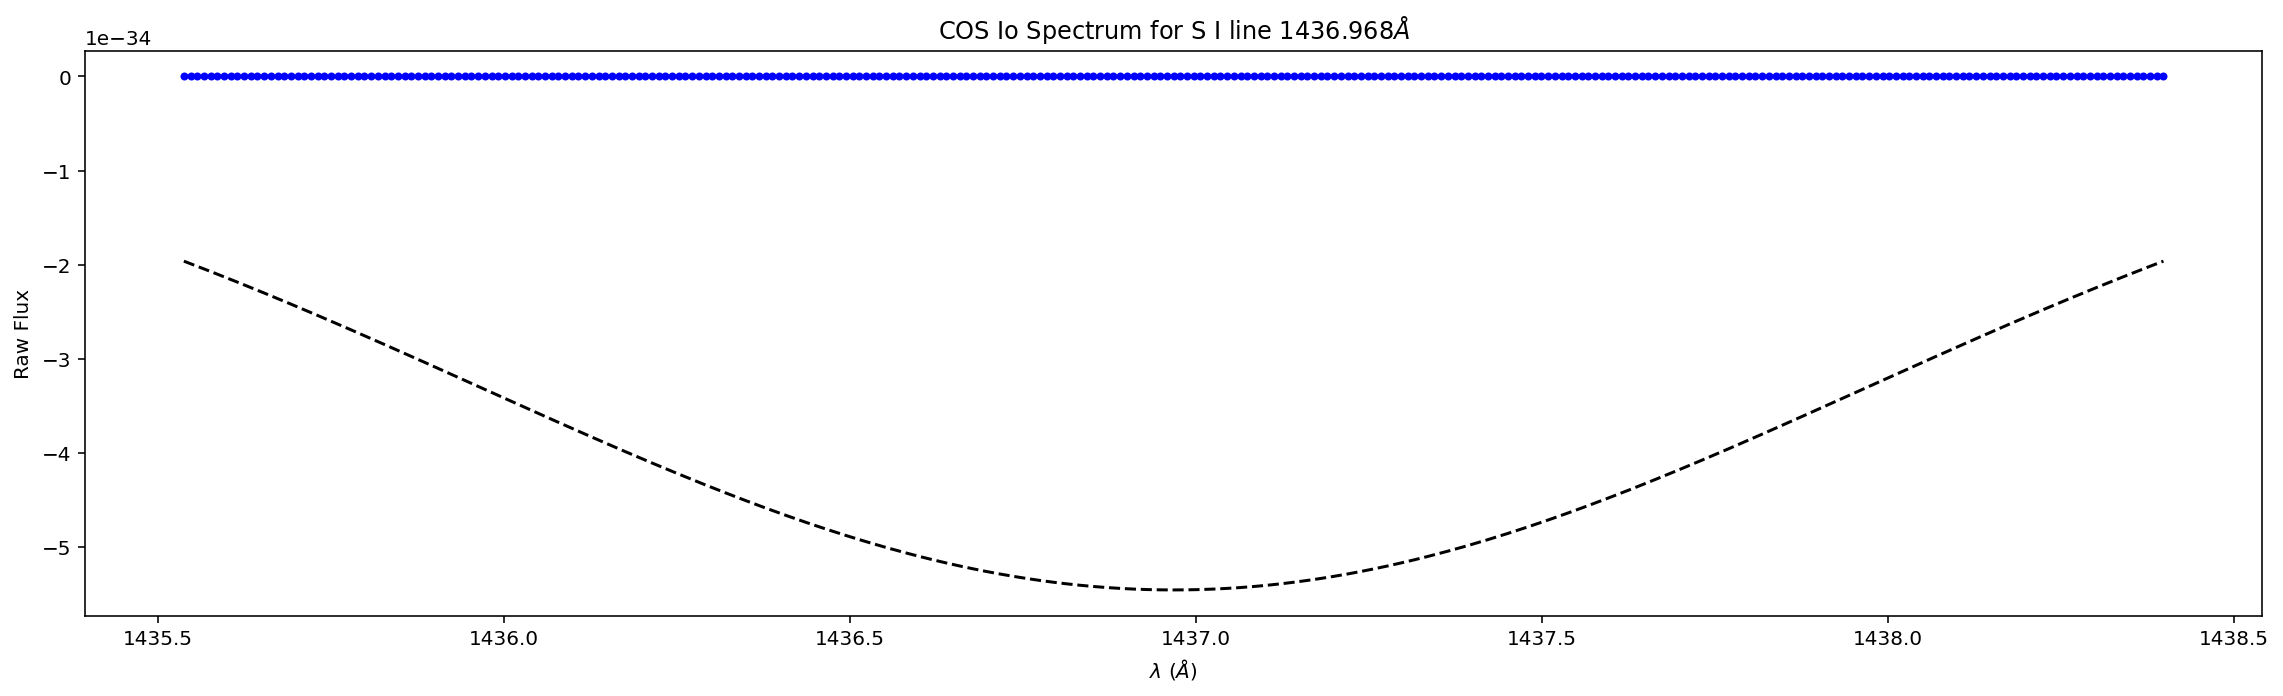

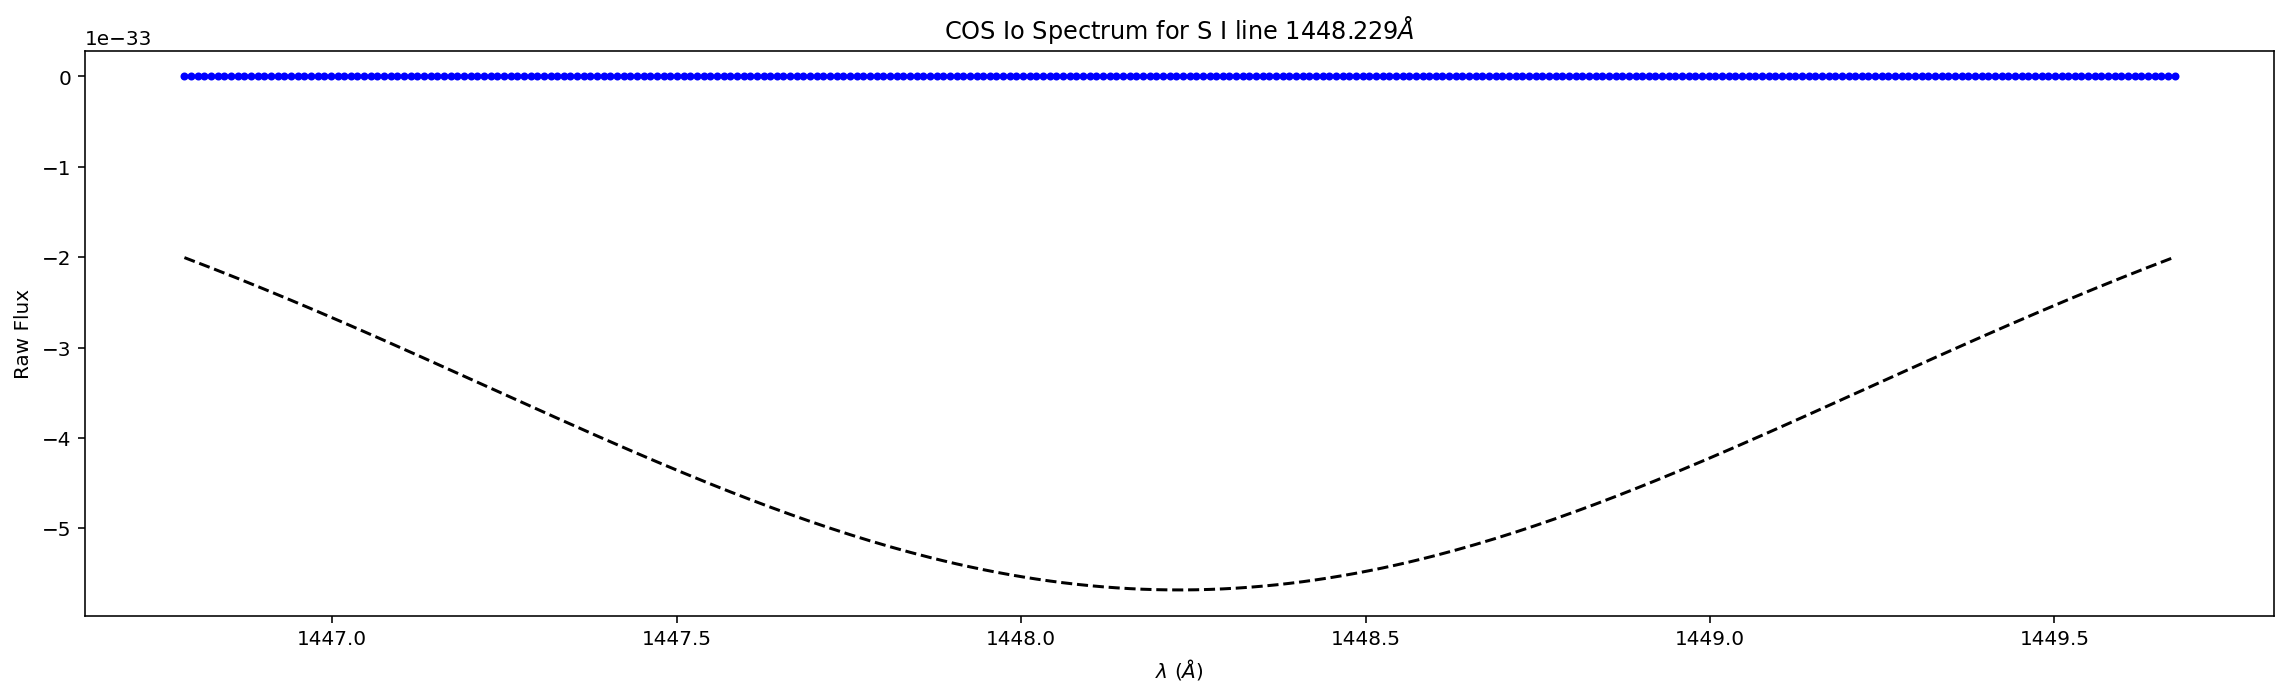

In [23]:
for index in tqdm(range(0, len(wavelength_list))):
    #len(wavelength_list) for whole list
    
    line = wavelength_list[index]
    try:
        left_bound = 0.999*line
        right_bound = 1.001*line

        sub_region = (evt_data['WAVELENGTH'] > left_bound) & (evt_data['WAVELENGTH'] < right_bound) #only take values within this area
        wl = evt_data['WAVELENGTH'][sub_region]
        flux = evt_data['FLUX'][sub_region]
        unc = 0.1*flux #placeholder uncertainty
        wl_array = wl.data
        flux_array = flux.data

        amp1 = 1*10**-15
        sigma1 = 1
        cen1 = line

        popt_gauss, pcov_gauss = scipy.optimize.curve_fit(_1gaussian, wl_array, flux_array, p0=[amp1, cen1, sigma1])

        perr_gauss = np.sqrt(np.diag(pcov_gauss))

        a = popt_gauss[0]
        a_err = perr_gauss[0]
        mu = popt_gauss[1]
        mu_err = perr_gauss[1]
        w = popt_gauss[2]
        w_err = perr_gauss[2]

        print("\ngiven line is = {} ".format(line))
        print("amplitude = {} (+/-) {}".format("{:e}".format(a), "{:e}".format(a_err)))
        print("mu = {} (+/-) {}".format(mu, "{:e}".format(mu_err)))
        print("sigma = {} (+/-) {}".format((w), "{:e}".format(w_err)))
        
        plt.figure(figsize=(16, 5))
        plt.plot(wl_array,flux_array,'b.') #make it columns instead of rows bc otherwise will be a blank plot
        plt.plot(wl_array, _1gaussian(wl_array, *popt_gauss), 'k--')
        plt.xlabel('$\lambda$ ($\AA$)');
        plt.ylabel('Raw Flux')
        plt.title("COS Io Spectrum for S I line {}$\AA$".format(line))
        plt.tight_layout()
        save_place = '/Users/jojoa/GitHub/io_brightness/data/figures/single_fit/'
        plt.savefig(save_place+"gauss_fit_{}.jpg".format(line), format="jpg",dpi=1000)

        brightness = ((2*np.pi)**.5)*(a*w)
        #print("The brightness of S I at {} Angstrom is {}.".format(line,brightness))

        gauss_width = w
        gauss_width_unc = w_err
        obs_line_center = mu
        obs_line_center_unc = mu_err
        gauss_amp = a
        gauss_amp_unc = a_err

        temp = {'int_wv':line, 'obs_line_center':obs_line_center, 'obs_line_center_unc':obs_line_center_unc, 
                'gaussian_width':gauss_width, 'gaussian_width_unc':gauss_width_unc, 'gauss_amp':gauss_amp, 
                'gauss_amp_unc':gauss_amp_unc, 'brightness':brightness}

        df_results = df_results.append(temp, ignore_index=True)
        if (index % 10) == 0:
                    #print(index, fn[-49:])
                    df_results.to_csv('../data/single_gauss_fit/io_results_june_9.csv',index=False)
                    
    except:
        print("Fail:", line)
        problem_files[index] = line
        prob_data = list(problem_files.items())
        problem_array = np.array(prob_data)

Now that we have run the loop, let us save the file for later use.

In [24]:
prob_data = list(problem_files.items())
problem_array = np.array(prob_data)
problem_array

array([[   2.   , 1211.38 ],
       [   3.   , 1212.795],
       [  18.   , 1269.209],
       [  20.   , 1277.199]])